In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-scatter 2.1.0+pt113cu116
Uninstalling torch-scatter-2.1.0+pt113cu116:
  Successfully uninstalled torch-scatter-2.1.0+pt113cu116
Found existing installation: torch-sparse 0.6.16+pt113cu116
Uninstalling torch-sparse-0.6.16+pt113cu116:
  Successfully uninstalled torch-sparse-0.6.16+pt113cu116
Found existing installation: torch-geometric 2.3.0
Uninstalling torch-geometric-2.3.0:
  Successfully uninstalled torch-geometric-2.3.0
Found existing installation: torch-cluster 1.6.0+pt113cu116
Uninstalling torch-cluster-1.6.0+pt113cu116:
  Successfully uninstalled torch-cluster-1.6.0+pt113cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
  Using cached https://data.pyg.org/whl/torch-1.13.0%2Bcu116/torch_scatter-2.1.0%2Bpt113cu116-cp38-cp38-linux_x86_64.whl (9.4 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import from_smiles
from tqdm import tqdm

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Prepate data from csv to work
def convert_csv_to_graph(path, smiles, sol):
  df = pd.read_csv(path, sep=',')
  df.head()

  data = []

  for index, row in df.iterrows():
    sample = from_smiles(row[smiles])
    sample.y = torch.tensor([[row[sol]]])
    data.append(sample)
  print("Dataset sample: ", data[0])
  print("Sample  nodes: ", data[0].num_nodes)
  print("Sample  edges: ", data[0].num_edges) 
  return data

In [6]:
# Get datasets from github
!wget https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/curated-solubility-dataset.csv #AQSOL
!wget https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/delaney-processed.csv 

--2023-01-25 12:00:22--  https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/curated-solubility-dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3750208 (3.6M) [text/plain]
Saving to: ‘curated-solubility-dataset.csv.1’

curated-solubility- 100%[===================>]   3.58M  --.-KB/s    in 0.02s   

2023-01-25 12:00:23 (186 MB/s) - ‘curated-solubility-dataset.csv.1’ saved [3750208/3750208]

--2023-01-25 12:00:23--  https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP requ

In [7]:
data = convert_csv_to_graph('delaney-processed.csv', 'smiles', 'ESOL predicted log solubility in mols per litre')
#data = convert_csv_to_graph('curated-solubility-dataset.csv', 'SMILES', 'Solubility')

Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Sample  nodes:  32
Sample  edges:  68


In [8]:
hidden_channels = 64
num_features = len(data[0].x[0])
batch_size = 64


class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels*2, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = F.leaky_relu(self.conv1(x, edge_index))
        hidden = F.leaky_relu(self.conv2(hidden, edge_index))
        hidden = F.leaky_relu(self.conv3(hidden, edge_index))

        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        out = self.out(hidden)
        return out, hidden

In [9]:
model = GCN(num_features=num_features, hidden_channels=hidden_channels)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
data_size = len(data)
loader = DataLoader(data[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
print(data_size)

1128


In [11]:
def train(data):
    for batch in loader:
      batch.to(device)  
      optimizer.zero_grad() 
      prediction, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = torch.sqrt(loss_fn(prediction, batch.y))       
      loss.backward()  
      optimizer.step()   
    return loss, embedding

In [12]:
epochs = 3000
losses = []
for epoch in tqdm(range(epochs)):
    loss, h = train(data)
    losses.append(loss)
    print(f"Epoch {epoch} | Train Loss {loss}")

  0%|          | 1/3000 [00:00<11:20,  4.41it/s]

Epoch 0 | Train Loss 1.6809446811676025


  0%|          | 2/3000 [00:00<10:43,  4.66it/s]

Epoch 1 | Train Loss 2.191957950592041


  0%|          | 3/3000 [00:00<10:41,  4.67it/s]

Epoch 2 | Train Loss 1.8377201557159424


  0%|          | 4/3000 [00:00<10:50,  4.60it/s]

Epoch 3 | Train Loss 1.2604632377624512


  0%|          | 5/3000 [00:01<10:51,  4.60it/s]

Epoch 4 | Train Loss 1.8885650634765625


  0%|          | 6/3000 [00:01<10:58,  4.54it/s]

Epoch 5 | Train Loss 1.6330926418304443


  0%|          | 7/3000 [00:01<11:23,  4.38it/s]

Epoch 6 | Train Loss 1.3661999702453613


  0%|          | 8/3000 [00:01<11:22,  4.38it/s]

Epoch 7 | Train Loss 0.8182925581932068


  0%|          | 9/3000 [00:02<15:13,  3.27it/s]

Epoch 8 | Train Loss 1.126424789428711


  0%|          | 10/3000 [00:02<17:09,  2.90it/s]

Epoch 9 | Train Loss 1.0468060970306396


  0%|          | 11/3000 [00:03<17:50,  2.79it/s]

Epoch 10 | Train Loss 2.393528699874878


  0%|          | 12/3000 [00:03<18:24,  2.71it/s]

Epoch 11 | Train Loss 1.1687370538711548


  0%|          | 13/3000 [00:03<19:38,  2.53it/s]

Epoch 12 | Train Loss 1.1483683586120605


  0%|          | 14/3000 [00:04<18:50,  2.64it/s]

Epoch 13 | Train Loss 1.6969577074050903


  0%|          | 15/3000 [00:04<19:17,  2.58it/s]

Epoch 14 | Train Loss 0.9398192763328552


  1%|          | 16/3000 [00:05<20:36,  2.41it/s]

Epoch 15 | Train Loss 1.499405860900879


  1%|          | 17/3000 [00:05<20:11,  2.46it/s]

Epoch 16 | Train Loss 2.5112593173980713


  1%|          | 18/3000 [00:06<21:30,  2.31it/s]

Epoch 17 | Train Loss 1.54689359664917


  1%|          | 19/3000 [00:06<20:50,  2.38it/s]

Epoch 18 | Train Loss 2.6484193801879883


  1%|          | 20/3000 [00:07<25:20,  1.96it/s]

Epoch 19 | Train Loss 0.897504985332489


  1%|          | 21/3000 [00:07<25:19,  1.96it/s]

Epoch 20 | Train Loss 0.9498735666275024


  1%|          | 22/3000 [00:08<24:09,  2.05it/s]

Epoch 21 | Train Loss 1.9463566541671753


  1%|          | 23/3000 [00:08<22:32,  2.20it/s]

Epoch 22 | Train Loss 1.6562845706939697


  1%|          | 24/3000 [00:08<21:39,  2.29it/s]

Epoch 23 | Train Loss 1.0525898933410645


  1%|          | 25/3000 [00:09<22:37,  2.19it/s]

Epoch 24 | Train Loss 1.5053009986877441


  1%|          | 26/3000 [00:09<21:27,  2.31it/s]

Epoch 25 | Train Loss 1.1082911491394043


  1%|          | 27/3000 [00:10<22:52,  2.17it/s]

Epoch 26 | Train Loss 1.5683977603912354


  1%|          | 28/3000 [00:10<20:59,  2.36it/s]

Epoch 27 | Train Loss 1.070251226425171


  1%|          | 29/3000 [00:11<21:29,  2.30it/s]

Epoch 28 | Train Loss 0.8897489309310913


  1%|          | 30/3000 [00:11<23:35,  2.10it/s]

Epoch 29 | Train Loss 1.348930835723877


  1%|          | 31/3000 [00:12<23:03,  2.15it/s]

Epoch 30 | Train Loss 1.2346305847167969


  1%|          | 32/3000 [00:12<23:25,  2.11it/s]

Epoch 31 | Train Loss 0.5714024901390076


  1%|          | 33/3000 [00:13<23:05,  2.14it/s]

Epoch 32 | Train Loss 1.105758547782898


  1%|          | 34/3000 [00:13<22:38,  2.18it/s]

Epoch 33 | Train Loss 1.4559732675552368


  1%|          | 35/3000 [00:14<24:50,  1.99it/s]

Epoch 34 | Train Loss 0.9916753172874451


  1%|          | 36/3000 [00:14<24:58,  1.98it/s]

Epoch 35 | Train Loss 1.0255763530731201


  1%|          | 37/3000 [00:14<23:24,  2.11it/s]

Epoch 36 | Train Loss 1.1960867643356323


  1%|▏         | 38/3000 [00:15<24:34,  2.01it/s]

Epoch 37 | Train Loss 1.0492373704910278


  1%|▏         | 39/3000 [00:16<25:19,  1.95it/s]

Epoch 38 | Train Loss 0.7020217776298523


  1%|▏         | 40/3000 [00:16<23:29,  2.10it/s]

Epoch 39 | Train Loss 0.9826284050941467


  1%|▏         | 41/3000 [00:16<21:46,  2.26it/s]

Epoch 40 | Train Loss 1.4272081851959229


  1%|▏         | 42/3000 [00:17<21:53,  2.25it/s]

Epoch 41 | Train Loss 0.9191901087760925


  1%|▏         | 43/3000 [00:17<22:24,  2.20it/s]

Epoch 42 | Train Loss 0.9010810256004333


  1%|▏         | 44/3000 [00:18<28:14,  1.74it/s]

Epoch 43 | Train Loss 1.25422203540802


  2%|▏         | 45/3000 [00:19<28:48,  1.71it/s]

Epoch 44 | Train Loss 0.9917435050010681


  2%|▏         | 46/3000 [00:19<28:24,  1.73it/s]

Epoch 45 | Train Loss 0.8373093008995056


  2%|▏         | 48/3000 [00:20<19:11,  2.56it/s]

Epoch 46 | Train Loss 1.241674780845642
Epoch 47 | Train Loss 0.720023512840271


  2%|▏         | 50/3000 [00:20<14:13,  3.46it/s]

Epoch 48 | Train Loss 2.867082118988037
Epoch 49 | Train Loss 1.086756706237793


  2%|▏         | 51/3000 [00:20<12:47,  3.84it/s]

Epoch 50 | Train Loss 0.4614662826061249


  2%|▏         | 52/3000 [00:21<12:17,  3.99it/s]

Epoch 51 | Train Loss 1.0867817401885986


  2%|▏         | 53/3000 [00:21<13:48,  3.56it/s]

Epoch 52 | Train Loss 0.8088215589523315


  2%|▏         | 54/3000 [00:21<15:06,  3.25it/s]

Epoch 53 | Train Loss 0.7473750114440918


  2%|▏         | 56/3000 [00:22<12:51,  3.81it/s]

Epoch 54 | Train Loss 0.6914985775947571
Epoch 55 | Train Loss 0.6018857359886169


  2%|▏         | 58/3000 [00:22<11:09,  4.39it/s]

Epoch 56 | Train Loss 0.8789803385734558
Epoch 57 | Train Loss 1.7200088500976562


  2%|▏         | 59/3000 [00:22<10:39,  4.60it/s]

Epoch 58 | Train Loss 0.8956496119499207


  2%|▏         | 60/3000 [00:22<10:42,  4.57it/s]

Epoch 59 | Train Loss 0.8353846073150635


  2%|▏         | 61/3000 [00:23<10:45,  4.56it/s]

Epoch 60 | Train Loss 1.5102620124816895


  2%|▏         | 62/3000 [00:23<10:52,  4.50it/s]

Epoch 61 | Train Loss 0.5121574401855469


  2%|▏         | 63/3000 [00:23<11:03,  4.42it/s]

Epoch 62 | Train Loss 0.9835660457611084


  2%|▏         | 64/3000 [00:23<10:58,  4.46it/s]

Epoch 63 | Train Loss 0.8029568195343018


  2%|▏         | 65/3000 [00:24<10:56,  4.47it/s]

Epoch 64 | Train Loss 2.94413423538208


  2%|▏         | 66/3000 [00:24<10:43,  4.56it/s]

Epoch 65 | Train Loss 0.8316479325294495


  2%|▏         | 68/3000 [00:24<10:34,  4.62it/s]

Epoch 66 | Train Loss 1.5192523002624512
Epoch 67 | Train Loss 1.220043420791626


  2%|▏         | 70/3000 [00:25<09:55,  4.92it/s]

Epoch 68 | Train Loss 0.9628476500511169
Epoch 69 | Train Loss 0.86247718334198


  2%|▏         | 72/3000 [00:25<09:45,  5.00it/s]

Epoch 70 | Train Loss 0.871926486492157
Epoch 71 | Train Loss 0.3741992712020874


  2%|▏         | 74/3000 [00:25<09:36,  5.08it/s]

Epoch 72 | Train Loss 0.7695422768592834
Epoch 73 | Train Loss 0.5472858548164368


  3%|▎         | 76/3000 [00:26<09:32,  5.11it/s]

Epoch 74 | Train Loss 0.6193029284477234
Epoch 75 | Train Loss 0.5188396573066711


  3%|▎         | 77/3000 [00:26<09:28,  5.15it/s]

Epoch 76 | Train Loss 0.6728747487068176


  3%|▎         | 79/3000 [00:26<09:29,  5.13it/s]

Epoch 77 | Train Loss 0.4247027337551117
Epoch 78 | Train Loss 1.2359206676483154


  3%|▎         | 81/3000 [00:27<09:26,  5.15it/s]

Epoch 79 | Train Loss 0.9470481276512146
Epoch 80 | Train Loss 0.6929065585136414


  3%|▎         | 82/3000 [00:27<09:46,  4.97it/s]

Epoch 81 | Train Loss 0.7205745577812195


  3%|▎         | 83/3000 [00:27<09:59,  4.87it/s]

Epoch 82 | Train Loss 0.8947617411613464


  3%|▎         | 84/3000 [00:27<10:14,  4.75it/s]

Epoch 83 | Train Loss 0.9844436645507812


  3%|▎         | 85/3000 [00:28<10:15,  4.74it/s]

Epoch 84 | Train Loss 0.832531750202179


  3%|▎         | 86/3000 [00:28<10:25,  4.66it/s]

Epoch 85 | Train Loss 0.9752123355865479


  3%|▎         | 88/3000 [00:28<10:20,  4.70it/s]

Epoch 86 | Train Loss 0.8495135307312012
Epoch 87 | Train Loss 0.8891538381576538


  3%|▎         | 90/3000 [00:29<09:58,  4.86it/s]

Epoch 88 | Train Loss 0.4911498725414276
Epoch 89 | Train Loss 0.9389008283615112


  3%|▎         | 92/3000 [00:29<09:35,  5.06it/s]

Epoch 90 | Train Loss 0.49502745270729065
Epoch 91 | Train Loss 0.4047054350376129


  3%|▎         | 93/3000 [00:29<09:34,  5.06it/s]

Epoch 92 | Train Loss 2.8411166667938232


  3%|▎         | 95/3000 [00:30<09:33,  5.06it/s]

Epoch 93 | Train Loss 0.934759795665741
Epoch 94 | Train Loss 0.45561665296554565


  3%|▎         | 97/3000 [00:30<09:22,  5.16it/s]

Epoch 95 | Train Loss 0.6780272722244263
Epoch 96 | Train Loss 0.5616276264190674


  3%|▎         | 99/3000 [00:30<09:29,  5.09it/s]

Epoch 97 | Train Loss 0.7813682556152344
Epoch 98 | Train Loss 0.6354649662971497


  3%|▎         | 101/3000 [00:31<09:23,  5.14it/s]

Epoch 99 | Train Loss 0.551624059677124
Epoch 100 | Train Loss 0.6679893136024475


  3%|▎         | 102/3000 [00:31<09:30,  5.08it/s]

Epoch 101 | Train Loss 0.4975367784500122


  3%|▎         | 103/3000 [00:31<09:57,  4.85it/s]

Epoch 102 | Train Loss 0.4226229190826416


  3%|▎         | 104/3000 [00:32<10:06,  4.77it/s]

Epoch 103 | Train Loss 0.5254147052764893


  4%|▎         | 106/3000 [00:32<09:56,  4.85it/s]

Epoch 104 | Train Loss 0.7970311641693115
Epoch 105 | Train Loss 0.6864593029022217


  4%|▎         | 108/3000 [00:32<09:40,  4.98it/s]

Epoch 106 | Train Loss 0.7158880233764648
Epoch 107 | Train Loss 0.7990049123764038


  4%|▎         | 110/3000 [00:33<09:19,  5.17it/s]

Epoch 108 | Train Loss 1.0053353309631348
Epoch 109 | Train Loss 0.4006255269050598


  4%|▎         | 112/3000 [00:33<09:14,  5.21it/s]

Epoch 110 | Train Loss 0.804262101650238
Epoch 111 | Train Loss 0.5637894868850708


  4%|▍         | 113/3000 [00:33<09:25,  5.10it/s]

Epoch 112 | Train Loss 1.183308482170105


  4%|▍         | 114/3000 [00:33<09:42,  4.95it/s]

Epoch 113 | Train Loss 0.48974698781967163


  4%|▍         | 115/3000 [00:34<09:49,  4.89it/s]

Epoch 114 | Train Loss 1.4128526449203491


  4%|▍         | 116/3000 [00:34<10:58,  4.38it/s]

Epoch 115 | Train Loss 1.0374776124954224


  4%|▍         | 117/3000 [00:34<14:12,  3.38it/s]

Epoch 116 | Train Loss 0.8204203844070435


  4%|▍         | 118/3000 [00:35<15:36,  3.08it/s]

Epoch 117 | Train Loss 0.6408592462539673


  4%|▍         | 119/3000 [00:35<17:50,  2.69it/s]

Epoch 118 | Train Loss 0.44184669852256775


  4%|▍         | 120/3000 [00:36<20:38,  2.32it/s]

Epoch 119 | Train Loss 1.1231002807617188


  4%|▍         | 121/3000 [00:36<22:08,  2.17it/s]

Epoch 120 | Train Loss 0.5304346084594727


  4%|▍         | 122/3000 [00:37<21:41,  2.21it/s]

Epoch 121 | Train Loss 0.6991822719573975


  4%|▍         | 123/3000 [00:37<21:17,  2.25it/s]

Epoch 122 | Train Loss 0.8788768649101257


  4%|▍         | 124/3000 [00:38<21:09,  2.27it/s]

Epoch 123 | Train Loss 0.8164030909538269


  4%|▍         | 125/3000 [00:38<21:01,  2.28it/s]

Epoch 124 | Train Loss 0.6344040036201477


  4%|▍         | 126/3000 [00:39<20:17,  2.36it/s]

Epoch 125 | Train Loss 0.9113622903823853


  4%|▍         | 127/3000 [00:39<19:51,  2.41it/s]

Epoch 126 | Train Loss 0.4664382338523865


  4%|▍         | 128/3000 [00:39<20:57,  2.28it/s]

Epoch 127 | Train Loss 0.4718513786792755


  4%|▍         | 129/3000 [00:40<20:40,  2.31it/s]

Epoch 128 | Train Loss 0.8420404195785522


  4%|▍         | 130/3000 [00:40<20:59,  2.28it/s]

Epoch 129 | Train Loss 0.7329426407814026


  4%|▍         | 131/3000 [00:41<21:36,  2.21it/s]

Epoch 130 | Train Loss 0.7070430517196655


  4%|▍         | 132/3000 [00:41<21:52,  2.18it/s]

Epoch 131 | Train Loss 0.7687771916389465


  4%|▍         | 133/3000 [00:42<22:16,  2.14it/s]

Epoch 132 | Train Loss 1.4388889074325562


  4%|▍         | 134/3000 [00:42<21:59,  2.17it/s]

Epoch 133 | Train Loss 1.3789219856262207


  4%|▍         | 135/3000 [00:43<22:02,  2.17it/s]

Epoch 134 | Train Loss 0.722448468208313


  5%|▍         | 136/3000 [00:43<21:55,  2.18it/s]

Epoch 135 | Train Loss 0.7440028190612793


  5%|▍         | 137/3000 [00:43<20:42,  2.30it/s]

Epoch 136 | Train Loss 1.2979663610458374


  5%|▍         | 138/3000 [00:44<21:15,  2.24it/s]

Epoch 137 | Train Loss 0.5415230393409729


  5%|▍         | 139/3000 [00:44<21:23,  2.23it/s]

Epoch 138 | Train Loss 0.44287776947021484


  5%|▍         | 140/3000 [00:45<21:30,  2.22it/s]

Epoch 139 | Train Loss 0.5640484094619751


  5%|▍         | 141/3000 [00:45<20:23,  2.34it/s]

Epoch 140 | Train Loss 1.1135241985321045


  5%|▍         | 142/3000 [00:46<25:15,  1.89it/s]

Epoch 141 | Train Loss 0.5282704830169678


  5%|▍         | 143/3000 [00:46<24:26,  1.95it/s]

Epoch 142 | Train Loss 0.5395225286483765


  5%|▍         | 144/3000 [00:47<22:03,  2.16it/s]

Epoch 143 | Train Loss 0.8623492121696472


  5%|▍         | 145/3000 [00:47<21:47,  2.18it/s]

Epoch 144 | Train Loss 0.7252031564712524


  5%|▍         | 146/3000 [00:48<21:50,  2.18it/s]

Epoch 145 | Train Loss 0.38869133591651917


  5%|▍         | 147/3000 [00:48<23:25,  2.03it/s]

Epoch 146 | Train Loss 0.4943047761917114


  5%|▍         | 149/3000 [00:49<18:22,  2.59it/s]

Epoch 147 | Train Loss 0.8581023216247559
Epoch 148 | Train Loss 1.2215903997421265


  5%|▌         | 151/3000 [00:49<13:45,  3.45it/s]

Epoch 149 | Train Loss 0.5690264105796814
Epoch 150 | Train Loss 0.49800097942352295


  5%|▌         | 153/3000 [00:50<11:25,  4.15it/s]

Epoch 151 | Train Loss 1.0516120195388794
Epoch 152 | Train Loss 0.30555459856987


  5%|▌         | 154/3000 [00:50<10:42,  4.43it/s]

Epoch 153 | Train Loss 0.6582186818122864


  5%|▌         | 155/3000 [00:50<10:30,  4.52it/s]

Epoch 154 | Train Loss 0.6235886812210083


  5%|▌         | 156/3000 [00:50<10:25,  4.55it/s]

Epoch 155 | Train Loss 0.2755884528160095


  5%|▌         | 158/3000 [00:51<10:08,  4.67it/s]

Epoch 156 | Train Loss 0.712078332901001
Epoch 157 | Train Loss 0.70321124792099


  5%|▌         | 160/3000 [00:51<09:41,  4.88it/s]

Epoch 158 | Train Loss 0.44448965787887573
Epoch 159 | Train Loss 0.9089769721031189


  5%|▌         | 161/3000 [00:51<09:43,  4.87it/s]

Epoch 160 | Train Loss 0.6530817747116089


  5%|▌         | 162/3000 [00:52<09:53,  4.79it/s]

Epoch 161 | Train Loss 1.2768676280975342


  5%|▌         | 164/3000 [00:52<09:39,  4.89it/s]

Epoch 162 | Train Loss 1.1159008741378784
Epoch 163 | Train Loss 0.69947350025177


  6%|▌         | 166/3000 [00:52<09:29,  4.98it/s]

Epoch 164 | Train Loss 0.8137830495834351
Epoch 165 | Train Loss 0.6879168748855591


  6%|▌         | 168/3000 [00:53<09:13,  5.12it/s]

Epoch 166 | Train Loss 0.6291231513023376
Epoch 167 | Train Loss 0.7221560478210449


  6%|▌         | 169/3000 [00:53<09:21,  5.04it/s]

Epoch 168 | Train Loss 0.7119767665863037


  6%|▌         | 170/3000 [00:53<09:26,  4.99it/s]

Epoch 169 | Train Loss 0.4144149720668793


  6%|▌         | 172/3000 [00:54<09:20,  5.04it/s]

Epoch 170 | Train Loss 0.33189794421195984
Epoch 171 | Train Loss 0.6429436802864075


  6%|▌         | 173/3000 [00:54<09:12,  5.12it/s]

Epoch 172 | Train Loss 0.5731214284896851


  6%|▌         | 175/3000 [00:54<09:17,  5.06it/s]

Epoch 173 | Train Loss 0.27842724323272705
Epoch 174 | Train Loss 0.5846971869468689


  6%|▌         | 177/3000 [00:54<09:14,  5.09it/s]

Epoch 175 | Train Loss 0.7893164753913879
Epoch 176 | Train Loss 0.6557624936103821


  6%|▌         | 178/3000 [00:55<09:06,  5.16it/s]

Epoch 177 | Train Loss 0.3050213158130646
Epoch 178 | Train Loss 1.1467229127883911


  6%|▌         | 181/3000 [00:55<09:06,  5.16it/s]

Epoch 179 | Train Loss 0.825690507888794
Epoch 180 | Train Loss 1.1187576055526733


  6%|▌         | 183/3000 [00:56<09:05,  5.17it/s]

Epoch 181 | Train Loss 0.5688357353210449
Epoch 182 | Train Loss 0.5871175527572632


  6%|▌         | 185/3000 [00:56<09:12,  5.10it/s]

Epoch 183 | Train Loss 0.5001569986343384
Epoch 184 | Train Loss 0.9912472367286682


  6%|▌         | 187/3000 [00:56<09:00,  5.20it/s]

Epoch 185 | Train Loss 0.5171133279800415
Epoch 186 | Train Loss 0.39787235856056213


  6%|▋         | 189/3000 [00:57<09:04,  5.16it/s]

Epoch 187 | Train Loss 0.5147415399551392
Epoch 188 | Train Loss 0.4455426335334778


  6%|▋         | 190/3000 [00:57<09:13,  5.08it/s]

Epoch 189 | Train Loss 0.4210924506187439


  6%|▋         | 192/3000 [00:57<09:19,  5.01it/s]

Epoch 190 | Train Loss 0.919091522693634
Epoch 191 | Train Loss 0.6772196888923645


  6%|▋         | 194/3000 [00:58<09:08,  5.12it/s]

Epoch 192 | Train Loss 0.36708810925483704
Epoch 193 | Train Loss 0.9997692108154297


  6%|▋         | 195/3000 [00:58<09:06,  5.13it/s]

Epoch 194 | Train Loss 0.4295121431350708


  7%|▋         | 197/3000 [00:58<09:13,  5.06it/s]

Epoch 195 | Train Loss 1.1974413394927979
Epoch 196 | Train Loss 0.5003301501274109


  7%|▋         | 199/3000 [00:59<09:00,  5.18it/s]

Epoch 197 | Train Loss 1.174005150794983
Epoch 198 | Train Loss 0.316150426864624


  7%|▋         | 201/3000 [00:59<09:05,  5.14it/s]

Epoch 199 | Train Loss 0.6757462024688721
Epoch 200 | Train Loss 0.9842372536659241


  7%|▋         | 203/3000 [01:00<09:11,  5.07it/s]

Epoch 201 | Train Loss 0.3590528666973114
Epoch 202 | Train Loss 0.4818316698074341


  7%|▋         | 205/3000 [01:00<09:08,  5.09it/s]

Epoch 203 | Train Loss 0.6168152689933777
Epoch 204 | Train Loss 0.5172160863876343


  7%|▋         | 206/3000 [01:00<09:06,  5.11it/s]

Epoch 205 | Train Loss 0.9089819192886353


  7%|▋         | 208/3000 [01:01<09:06,  5.11it/s]

Epoch 206 | Train Loss 2.6111276149749756
Epoch 207 | Train Loss 0.6964594721794128


  7%|▋         | 209/3000 [01:01<09:06,  5.10it/s]

Epoch 208 | Train Loss 0.5332022309303284


  7%|▋         | 211/3000 [01:01<09:06,  5.10it/s]

Epoch 209 | Train Loss 0.8101899027824402
Epoch 210 | Train Loss 0.6042373180389404


  7%|▋         | 213/3000 [01:02<09:03,  5.12it/s]

Epoch 211 | Train Loss 1.1097354888916016
Epoch 212 | Train Loss 0.4931645393371582


  7%|▋         | 215/3000 [01:02<09:03,  5.12it/s]

Epoch 213 | Train Loss 0.7164024710655212
Epoch 214 | Train Loss 0.651658296585083


  7%|▋         | 216/3000 [01:02<09:08,  5.08it/s]

Epoch 215 | Train Loss 0.5644500255584717


  7%|▋         | 217/3000 [01:02<09:19,  4.97it/s]

Epoch 216 | Train Loss 0.5091513395309448


  7%|▋         | 219/3000 [01:03<09:21,  4.95it/s]

Epoch 217 | Train Loss 0.9878994822502136
Epoch 218 | Train Loss 0.733151912689209


  7%|▋         | 220/3000 [01:03<09:19,  4.97it/s]

Epoch 219 | Train Loss 0.849731981754303


  7%|▋         | 221/3000 [01:03<09:27,  4.89it/s]

Epoch 220 | Train Loss 0.7039824724197388


  7%|▋         | 222/3000 [01:03<09:37,  4.81it/s]

Epoch 221 | Train Loss 0.9831924438476562


  7%|▋         | 224/3000 [01:04<09:25,  4.91it/s]

Epoch 222 | Train Loss 0.8700106143951416
Epoch 223 | Train Loss 0.48821473121643066


  8%|▊         | 225/3000 [01:04<09:22,  4.94it/s]

Epoch 224 | Train Loss 0.4022991359233856


  8%|▊         | 227/3000 [01:04<09:23,  4.92it/s]

Epoch 225 | Train Loss 0.9985374212265015
Epoch 226 | Train Loss 0.6680018305778503


  8%|▊         | 229/3000 [01:05<09:01,  5.11it/s]

Epoch 227 | Train Loss 0.6483134031295776
Epoch 228 | Train Loss 0.40316060185432434


  8%|▊         | 230/3000 [01:05<09:08,  5.05it/s]

Epoch 229 | Train Loss 0.4172452986240387


  8%|▊         | 232/3000 [01:05<09:12,  5.01it/s]

Epoch 230 | Train Loss 0.5978130102157593
Epoch 231 | Train Loss 0.8723034262657166


  8%|▊         | 234/3000 [01:06<09:01,  5.11it/s]

Epoch 232 | Train Loss 0.8234947919845581
Epoch 233 | Train Loss 0.36101293563842773


  8%|▊         | 236/3000 [01:06<09:00,  5.11it/s]

Epoch 234 | Train Loss 0.44618427753448486
Epoch 235 | Train Loss 0.3882980942726135


  8%|▊         | 237/3000 [01:06<09:03,  5.08it/s]

Epoch 236 | Train Loss 1.177889347076416


  8%|▊         | 239/3000 [01:07<08:59,  5.12it/s]

Epoch 237 | Train Loss 0.5115195512771606
Epoch 238 | Train Loss 0.27947938442230225


  8%|▊         | 240/3000 [01:07<09:00,  5.10it/s]

Epoch 239 | Train Loss 2.5349459648132324


  8%|▊         | 242/3000 [01:07<09:23,  4.90it/s]

Epoch 240 | Train Loss 0.8153300881385803
Epoch 241 | Train Loss 0.3943864703178406


  8%|▊         | 244/3000 [01:08<08:54,  5.16it/s]

Epoch 242 | Train Loss 0.5729653239250183
Epoch 243 | Train Loss 0.6818161606788635


  8%|▊         | 245/3000 [01:08<08:49,  5.20it/s]

Epoch 244 | Train Loss 0.8009044528007507


  8%|▊         | 247/3000 [01:08<09:00,  5.10it/s]

Epoch 245 | Train Loss 0.5252572298049927
Epoch 246 | Train Loss 0.37262970209121704


  8%|▊         | 249/3000 [01:09<08:51,  5.17it/s]

Epoch 247 | Train Loss 1.0658042430877686
Epoch 248 | Train Loss 0.4548571705818176


  8%|▊         | 250/3000 [01:09<08:51,  5.18it/s]

Epoch 249 | Train Loss 0.6077030301094055


  8%|▊         | 251/3000 [01:09<09:14,  4.95it/s]

Epoch 250 | Train Loss 0.3986062705516815


  8%|▊         | 253/3000 [01:10<09:11,  4.99it/s]

Epoch 251 | Train Loss 0.7206435799598694
Epoch 252 | Train Loss 0.5243307948112488


  8%|▊         | 255/3000 [01:10<08:50,  5.17it/s]

Epoch 253 | Train Loss 0.29086729884147644
Epoch 254 | Train Loss 1.2597635984420776


  9%|▊         | 257/3000 [01:10<08:53,  5.14it/s]

Epoch 255 | Train Loss 0.43734362721443176
Epoch 256 | Train Loss 0.8374236822128296


  9%|▊         | 258/3000 [01:11<08:59,  5.08it/s]

Epoch 257 | Train Loss 0.838376522064209


  9%|▊         | 260/3000 [01:11<09:06,  5.01it/s]

Epoch 258 | Train Loss 0.21469394862651825
Epoch 259 | Train Loss 0.43621519207954407


  9%|▊         | 261/3000 [01:11<09:34,  4.77it/s]

Epoch 260 | Train Loss 0.5074078440666199
Epoch 261 | Train Loss 0.3313594460487366

  9%|▉         | 263/3000 [01:12<09:19,  4.89it/s]


Epoch 262 | Train Loss 0.5471382737159729


  9%|▉         | 265/3000 [01:12<08:59,  5.06it/s]

Epoch 263 | Train Loss 0.5913613438606262
Epoch 264 | Train Loss 0.8985989689826965


  9%|▉         | 266/3000 [01:12<09:21,  4.87it/s]

Epoch 265 | Train Loss 0.5265307426452637


  9%|▉         | 267/3000 [01:12<09:51,  4.62it/s]

Epoch 266 | Train Loss 0.6182267069816589


  9%|▉         | 269/3000 [01:13<09:36,  4.74it/s]

Epoch 267 | Train Loss 0.566096305847168
Epoch 268 | Train Loss 0.37811902165412903


  9%|▉         | 270/3000 [01:13<09:39,  4.71it/s]

Epoch 269 | Train Loss 1.0130345821380615


  9%|▉         | 271/3000 [01:13<11:57,  3.80it/s]

Epoch 270 | Train Loss 0.6647433638572693


  9%|▉         | 272/3000 [01:14<14:25,  3.15it/s]

Epoch 271 | Train Loss 0.7435500025749207


  9%|▉         | 273/3000 [01:14<15:48,  2.88it/s]

Epoch 272 | Train Loss 1.0574227571487427


  9%|▉         | 274/3000 [01:15<16:08,  2.81it/s]

Epoch 273 | Train Loss 0.6821407675743103


  9%|▉         | 275/3000 [01:15<16:23,  2.77it/s]

Epoch 274 | Train Loss 0.37732845544815063


  9%|▉         | 276/3000 [01:15<16:50,  2.70it/s]

Epoch 275 | Train Loss 0.5115836262702942


  9%|▉         | 277/3000 [01:16<16:55,  2.68it/s]

Epoch 276 | Train Loss 0.4092537462711334


  9%|▉         | 278/3000 [01:16<16:38,  2.73it/s]

Epoch 277 | Train Loss 0.640037477016449


  9%|▉         | 279/3000 [01:17<16:57,  2.67it/s]

Epoch 278 | Train Loss 1.12314772605896


  9%|▉         | 280/3000 [01:17<17:41,  2.56it/s]

Epoch 279 | Train Loss 0.6490734219551086


  9%|▉         | 281/3000 [01:17<18:08,  2.50it/s]

Epoch 280 | Train Loss 0.2476862072944641


  9%|▉         | 282/3000 [01:18<18:00,  2.52it/s]

Epoch 281 | Train Loss 0.6173954010009766


  9%|▉         | 283/3000 [01:18<17:10,  2.64it/s]

Epoch 282 | Train Loss 0.7720381021499634


  9%|▉         | 284/3000 [01:18<16:48,  2.69it/s]

Epoch 283 | Train Loss 1.158440351486206


 10%|▉         | 285/3000 [01:19<16:02,  2.82it/s]

Epoch 284 | Train Loss 0.9866846203804016


 10%|▉         | 286/3000 [01:19<15:35,  2.90it/s]

Epoch 285 | Train Loss 0.5897805094718933


 10%|▉         | 287/3000 [01:19<15:19,  2.95it/s]

Epoch 286 | Train Loss 0.5571467876434326


 10%|▉         | 288/3000 [01:20<15:10,  2.98it/s]

Epoch 287 | Train Loss 0.9482747316360474


 10%|▉         | 290/3000 [01:20<12:35,  3.59it/s]

Epoch 288 | Train Loss 0.5766354203224182
Epoch 289 | Train Loss 0.43126529455184937


 10%|▉         | 291/3000 [01:20<11:37,  3.88it/s]

Epoch 290 | Train Loss 0.6204261183738708


 10%|▉         | 293/3000 [01:21<10:11,  4.43it/s]

Epoch 291 | Train Loss 0.6469634175300598
Epoch 292 | Train Loss 0.377008318901062


 10%|▉         | 295/3000 [01:21<09:30,  4.74it/s]

Epoch 293 | Train Loss 0.8848278522491455
Epoch 294 | Train Loss 0.6110242009162903


 10%|▉         | 297/3000 [01:22<09:37,  4.68it/s]

Epoch 295 | Train Loss 0.5164287090301514
Epoch 296 | Train Loss 0.8821367621421814


 10%|▉         | 299/3000 [01:22<09:04,  4.96it/s]

Epoch 297 | Train Loss 0.47253963351249695
Epoch 298 | Train Loss 0.9106065630912781


 10%|█         | 300/3000 [01:22<08:57,  5.02it/s]

Epoch 299 | Train Loss 0.5649288296699524


 10%|█         | 301/3000 [01:22<09:23,  4.79it/s]

Epoch 300 | Train Loss 0.37684059143066406


 10%|█         | 302/3000 [01:23<09:39,  4.65it/s]

Epoch 301 | Train Loss 0.4805026650428772


 10%|█         | 303/3000 [01:23<09:45,  4.61it/s]

Epoch 302 | Train Loss 0.659145712852478


 10%|█         | 304/3000 [01:23<09:47,  4.59it/s]

Epoch 303 | Train Loss 0.4106128215789795


 10%|█         | 305/3000 [01:23<09:53,  4.54it/s]

Epoch 304 | Train Loss 0.4408060610294342


 10%|█         | 306/3000 [01:24<09:53,  4.54it/s]

Epoch 305 | Train Loss 0.6162621974945068


 10%|█         | 307/3000 [01:24<09:57,  4.51it/s]

Epoch 306 | Train Loss 0.9305723309516907


 10%|█         | 308/3000 [01:24<10:01,  4.48it/s]

Epoch 307 | Train Loss 0.931881844997406


 10%|█         | 309/3000 [01:24<10:02,  4.47it/s]

Epoch 308 | Train Loss 0.3805692195892334


 10%|█         | 310/3000 [01:25<10:05,  4.45it/s]

Epoch 309 | Train Loss 0.28786757588386536


 10%|█         | 312/3000 [01:25<09:30,  4.71it/s]

Epoch 310 | Train Loss 0.6370975971221924
Epoch 311 | Train Loss 0.24210037291049957


 10%|█         | 313/3000 [01:25<09:10,  4.88it/s]

Epoch 312 | Train Loss 0.43159976601600647


 10%|█         | 314/3000 [01:25<09:13,  4.86it/s]

Epoch 313 | Train Loss 0.4231957793235779


 10%|█         | 315/3000 [01:26<09:35,  4.67it/s]

Epoch 314 | Train Loss 0.5831537842750549


 11%|█         | 316/3000 [01:26<09:47,  4.57it/s]

Epoch 315 | Train Loss 0.18471014499664307


 11%|█         | 318/3000 [01:26<09:25,  4.74it/s]

Epoch 316 | Train Loss 0.4465186595916748
Epoch 317 | Train Loss 0.8184449076652527


 11%|█         | 320/3000 [01:27<09:09,  4.88it/s]

Epoch 318 | Train Loss 0.41812267899513245
Epoch 319 | Train Loss 0.6456340551376343


 11%|█         | 322/3000 [01:27<08:52,  5.03it/s]

Epoch 320 | Train Loss 0.2981967031955719
Epoch 321 | Train Loss 0.46766868233680725


 11%|█         | 323/3000 [01:27<08:50,  5.04it/s]

Epoch 322 | Train Loss 0.6341113448143005


 11%|█         | 324/3000 [01:27<08:56,  4.99it/s]

Epoch 323 | Train Loss 0.938504695892334


 11%|█         | 326/3000 [01:28<09:00,  4.94it/s]

Epoch 324 | Train Loss 0.5828677415847778
Epoch 325 | Train Loss 0.4785989820957184


 11%|█         | 328/3000 [01:28<08:52,  5.01it/s]

Epoch 326 | Train Loss 0.6716217398643494
Epoch 327 | Train Loss 0.42553046345710754


 11%|█         | 329/3000 [01:28<09:14,  4.82it/s]

Epoch 328 | Train Loss 0.553240954875946


 11%|█         | 330/3000 [01:29<09:16,  4.80it/s]

Epoch 329 | Train Loss 1.2097973823547363


 11%|█         | 331/3000 [01:29<09:35,  4.64it/s]

Epoch 330 | Train Loss 0.48523685336112976


 11%|█         | 332/3000 [01:29<09:40,  4.60it/s]

Epoch 331 | Train Loss 0.28553205728530884


 11%|█         | 333/3000 [01:29<09:43,  4.57it/s]

Epoch 332 | Train Loss 0.809657096862793


 11%|█         | 335/3000 [01:30<09:31,  4.66it/s]

Epoch 333 | Train Loss 0.5414546728134155
Epoch 334 | Train Loss 0.22391435503959656


 11%|█         | 337/3000 [01:30<09:00,  4.92it/s]

Epoch 335 | Train Loss 0.6343550682067871
Epoch 336 | Train Loss 0.639829695224762


 11%|█▏        | 338/3000 [01:30<08:57,  4.95it/s]

Epoch 337 | Train Loss 0.8829441070556641


 11%|█▏        | 339/3000 [01:31<09:01,  4.92it/s]

Epoch 338 | Train Loss 1.0096572637557983
Epoch 339 | Train Loss 0.41156628727912903


 11%|█▏        | 342/3000 [01:31<08:44,  5.07it/s]

Epoch 340 | Train Loss 0.3821597993373871
Epoch 341 | Train Loss 0.9078008532524109


 11%|█▏        | 344/3000 [01:32<08:52,  4.98it/s]

Epoch 342 | Train Loss 0.2775578498840332
Epoch 343 | Train Loss 0.25125378370285034


 12%|█▏        | 346/3000 [01:32<09:01,  4.90it/s]

Epoch 344 | Train Loss 0.39372724294662476
Epoch 345 | Train Loss 0.5283100008964539


 12%|█▏        | 348/3000 [01:32<08:48,  5.01it/s]

Epoch 346 | Train Loss 0.8283944129943848
Epoch 347 | Train Loss 0.15016843378543854


 12%|█▏        | 350/3000 [01:33<08:40,  5.09it/s]

Epoch 348 | Train Loss 0.3422897756099701
Epoch 349 | Train Loss 0.2769154906272888


 12%|█▏        | 351/3000 [01:33<08:49,  5.00it/s]

Epoch 350 | Train Loss 1.3432626724243164


 12%|█▏        | 353/3000 [01:33<08:55,  4.95it/s]

Epoch 351 | Train Loss 0.3915722370147705
Epoch 352 | Train Loss 0.2644873857498169


 12%|█▏        | 355/3000 [01:34<08:44,  5.04it/s]

Epoch 353 | Train Loss 0.4854862093925476
Epoch 354 | Train Loss 0.7779008150100708


 12%|█▏        | 357/3000 [01:34<08:37,  5.10it/s]

Epoch 355 | Train Loss 0.5516483783721924
Epoch 356 | Train Loss 0.363214910030365


 12%|█▏        | 359/3000 [01:34<08:38,  5.09it/s]

Epoch 357 | Train Loss 0.7525997757911682
Epoch 358 | Train Loss 0.35816240310668945


 12%|█▏        | 360/3000 [01:35<08:33,  5.15it/s]

Epoch 359 | Train Loss 0.1634536236524582


 12%|█▏        | 362/3000 [01:35<08:40,  5.07it/s]

Epoch 360 | Train Loss 0.35986554622650146
Epoch 361 | Train Loss 0.3132355213165283


 12%|█▏        | 364/3000 [01:35<08:43,  5.04it/s]

Epoch 362 | Train Loss 0.3747161626815796
Epoch 363 | Train Loss 0.8004590272903442


 12%|█▏        | 365/3000 [01:36<08:39,  5.07it/s]

Epoch 364 | Train Loss 0.2600480616092682
Epoch 365 | Train Loss 0.48182380199432373

 12%|█▏        | 367/3000 [01:36<08:42,  5.04it/s]


Epoch 366 | Train Loss 0.19671185314655304


 12%|█▏        | 368/3000 [01:36<08:55,  4.91it/s]

Epoch 367 | Train Loss 0.6508964896202087


 12%|█▏        | 370/3000 [01:37<09:05,  4.82it/s]

Epoch 368 | Train Loss 0.4238794147968292
Epoch 369 | Train Loss 0.48669612407684326


 12%|█▏        | 371/3000 [01:37<09:00,  4.86it/s]

Epoch 370 | Train Loss 0.4774184823036194


 12%|█▏        | 372/3000 [01:37<09:08,  4.80it/s]

Epoch 371 | Train Loss 0.5975028276443481


 12%|█▏        | 373/3000 [01:37<09:07,  4.80it/s]

Epoch 372 | Train Loss 0.27231723070144653


 12%|█▎        | 375/3000 [01:38<08:58,  4.87it/s]

Epoch 373 | Train Loss 0.25654336810112
Epoch 374 | Train Loss 0.5026222467422485


 13%|█▎        | 377/3000 [01:38<08:48,  4.96it/s]

Epoch 375 | Train Loss 0.19057467579841614
Epoch 376 | Train Loss 0.3927954137325287


 13%|█▎        | 379/3000 [01:39<08:40,  5.04it/s]

Epoch 377 | Train Loss 0.4740109443664551
Epoch 378 | Train Loss 0.6145787835121155


 13%|█▎        | 380/3000 [01:39<08:33,  5.10it/s]

Epoch 379 | Train Loss 0.34690722823143005


 13%|█▎        | 381/3000 [01:39<08:43,  5.00it/s]

Epoch 380 | Train Loss 0.30898144841194153


 13%|█▎        | 382/3000 [01:39<08:50,  4.93it/s]

Epoch 381 | Train Loss 0.34216663241386414


 13%|█▎        | 384/3000 [01:40<08:55,  4.89it/s]

Epoch 382 | Train Loss 0.3537331521511078
Epoch 383 | Train Loss 0.5133421421051025


 13%|█▎        | 386/3000 [01:40<08:43,  4.99it/s]

Epoch 384 | Train Loss 0.4790959060192108
Epoch 385 | Train Loss 0.5288204550743103


 13%|█▎        | 387/3000 [01:40<08:36,  5.06it/s]

Epoch 386 | Train Loss 0.4757182002067566


 13%|█▎        | 388/3000 [01:40<09:37,  4.52it/s]

Epoch 387 | Train Loss 0.3562341332435608


 13%|█▎        | 390/3000 [01:41<13:36,  3.20it/s]

Epoch 388 | Train Loss 1.0138309001922607
Epoch 389 | Train Loss 0.3572872579097748


 13%|█▎        | 391/3000 [01:42<12:00,  3.62it/s]

Epoch 390 | Train Loss 0.47244155406951904


 13%|█▎        | 393/3000 [01:42<15:12,  2.86it/s]

Epoch 391 | Train Loss 1.2348999977111816
Epoch 392 | Train Loss 0.3442128598690033


 13%|█▎        | 395/3000 [01:43<11:47,  3.68it/s]

Epoch 393 | Train Loss 0.783519446849823
Epoch 394 | Train Loss 0.810613751411438


 13%|█▎        | 397/3000 [01:43<10:07,  4.29it/s]

Epoch 395 | Train Loss 0.3789735734462738
Epoch 396 | Train Loss 0.6929069757461548


 13%|█▎        | 398/3000 [01:43<09:39,  4.49it/s]

Epoch 397 | Train Loss 0.5922477841377258


 13%|█▎        | 400/3000 [01:44<09:04,  4.78it/s]

Epoch 398 | Train Loss 0.5551543235778809
Epoch 399 | Train Loss 0.26247304677963257


 13%|█▎        | 401/3000 [01:44<08:54,  4.86it/s]

Epoch 400 | Train Loss 0.3365003168582916


 13%|█▎        | 403/3000 [01:44<08:40,  4.99it/s]

Epoch 401 | Train Loss 0.34184056520462036
Epoch 402 | Train Loss 1.1437734365463257


 14%|█▎        | 405/3000 [01:45<08:36,  5.02it/s]

Epoch 403 | Train Loss 0.33841007947921753
Epoch 404 | Train Loss 0.3611297607421875


 14%|█▎        | 407/3000 [01:45<08:34,  5.04it/s]

Epoch 405 | Train Loss 1.0286906957626343
Epoch 406 | Train Loss 2.1969008445739746


 14%|█▎        | 409/3000 [01:46<08:23,  5.15it/s]

Epoch 407 | Train Loss 0.4477778375148773
Epoch 408 | Train Loss 0.679755687713623


 14%|█▎        | 411/3000 [01:46<08:20,  5.17it/s]

Epoch 409 | Train Loss 0.4839116036891937
Epoch 410 | Train Loss 0.33050405979156494


 14%|█▍        | 413/3000 [01:46<08:28,  5.08it/s]

Epoch 411 | Train Loss 1.0073752403259277
Epoch 412 | Train Loss 2.319859504699707


 14%|█▍        | 415/3000 [01:47<08:32,  5.04it/s]

Epoch 413 | Train Loss 0.18667899072170258
Epoch 414 | Train Loss 0.27180755138397217


 14%|█▍        | 417/3000 [01:47<08:37,  4.99it/s]

Epoch 415 | Train Loss 0.9992210268974304
Epoch 416 | Train Loss 1.2133395671844482


 14%|█▍        | 418/3000 [01:47<08:45,  4.91it/s]

Epoch 417 | Train Loss 0.22158902883529663


 14%|█▍        | 420/3000 [01:48<08:42,  4.94it/s]

Epoch 418 | Train Loss 0.3161694407463074
Epoch 419 | Train Loss 0.6820003986358643


 14%|█▍        | 421/3000 [01:48<08:44,  4.91it/s]

Epoch 420 | Train Loss 0.7916676998138428


 14%|█▍        | 422/3000 [01:48<08:50,  4.86it/s]

Epoch 421 | Train Loss 0.5372449159622192


 14%|█▍        | 423/3000 [01:48<09:09,  4.69it/s]

Epoch 422 | Train Loss 0.8338854908943176


 14%|█▍        | 425/3000 [01:49<08:53,  4.83it/s]

Epoch 423 | Train Loss 0.25471827387809753
Epoch 424 | Train Loss 0.4345056414604187


 14%|█▍        | 426/3000 [01:49<08:46,  4.89it/s]

Epoch 425 | Train Loss 0.5165933966636658


 14%|█▍        | 428/3000 [01:49<08:40,  4.95it/s]

Epoch 426 | Train Loss 0.6025350093841553
Epoch 427 | Train Loss 0.28223276138305664


 14%|█▍        | 430/3000 [01:50<08:27,  5.06it/s]

Epoch 428 | Train Loss 0.5173090696334839
Epoch 429 | Train Loss 0.4220939874649048


 14%|█▍        | 431/3000 [01:50<08:31,  5.03it/s]

Epoch 430 | Train Loss 0.5323659777641296


 14%|█▍        | 433/3000 [01:50<08:32,  5.01it/s]

Epoch 431 | Train Loss 0.1829010397195816
Epoch 432 | Train Loss 0.2642357349395752


 14%|█▍        | 435/3000 [01:51<08:23,  5.10it/s]

Epoch 433 | Train Loss 0.6760448813438416
Epoch 434 | Train Loss 0.6400195956230164


 15%|█▍        | 436/3000 [01:51<08:24,  5.08it/s]

Epoch 435 | Train Loss 0.6300858855247498


 15%|█▍        | 437/3000 [01:51<08:43,  4.89it/s]

Epoch 436 | Train Loss 0.3759697377681732


 15%|█▍        | 438/3000 [01:52<09:02,  4.72it/s]

Epoch 437 | Train Loss 0.4540235996246338


 15%|█▍        | 439/3000 [01:52<09:06,  4.69it/s]

Epoch 438 | Train Loss 0.6175243854522705


 15%|█▍        | 440/3000 [01:52<09:12,  4.64it/s]

Epoch 439 | Train Loss 0.31872841715812683


 15%|█▍        | 441/3000 [01:52<09:23,  4.54it/s]

Epoch 440 | Train Loss 0.19681918621063232


 15%|█▍        | 443/3000 [01:53<09:06,  4.68it/s]

Epoch 441 | Train Loss 0.3771258294582367
Epoch 442 | Train Loss 0.35407698154449463


 15%|█▍        | 445/3000 [01:53<08:41,  4.90it/s]

Epoch 443 | Train Loss 0.5619304776191711
Epoch 444 | Train Loss 0.287993848323822


 15%|█▍        | 447/3000 [01:53<08:36,  4.94it/s]

Epoch 445 | Train Loss 0.42760151624679565
Epoch 446 | Train Loss 0.3099016845226288


 15%|█▍        | 448/3000 [01:54<08:29,  5.01it/s]

Epoch 447 | Train Loss 0.43496447801589966
Epoch 448 | Train Loss 0.734665036201477

 15%|█▌        | 450/3000 [01:54<08:21,  5.08it/s]


Epoch 449 | Train Loss 0.3276403248310089


 15%|█▌        | 451/3000 [01:54<08:20,  5.10it/s]

Epoch 450 | Train Loss 0.5455105900764465


 15%|█▌        | 452/3000 [01:54<08:31,  4.98it/s]

Epoch 451 | Train Loss 0.7466473579406738


 15%|█▌        | 454/3000 [01:55<08:30,  4.99it/s]

Epoch 452 | Train Loss 0.22738783061504364
Epoch 453 | Train Loss 0.54058438539505


 15%|█▌        | 456/3000 [01:55<08:21,  5.07it/s]

Epoch 454 | Train Loss 0.3037688732147217
Epoch 455 | Train Loss 0.5350203514099121


 15%|█▌        | 457/3000 [01:55<09:01,  4.70it/s]

Epoch 456 | Train Loss 0.6644458770751953


 15%|█▌        | 458/3000 [01:56<09:11,  4.61it/s]

Epoch 457 | Train Loss 0.3997635543346405


 15%|█▌        | 459/3000 [01:56<09:17,  4.56it/s]

Epoch 458 | Train Loss 0.40642622113227844


 15%|█▌        | 460/3000 [01:56<09:25,  4.49it/s]

Epoch 459 | Train Loss 0.36927980184555054


 15%|█▌        | 462/3000 [01:57<08:52,  4.76it/s]

Epoch 460 | Train Loss 0.30450668931007385
Epoch 461 | Train Loss 0.39571183919906616


 15%|█▌        | 463/3000 [01:57<08:41,  4.87it/s]

Epoch 462 | Train Loss 0.3649199306964874


 16%|█▌        | 465/3000 [01:57<08:27,  4.99it/s]

Epoch 463 | Train Loss 0.4649973511695862
Epoch 464 | Train Loss 0.2488943189382553


 16%|█▌        | 466/3000 [01:57<08:39,  4.87it/s]

Epoch 465 | Train Loss 0.9984421133995056


 16%|█▌        | 467/3000 [01:58<08:52,  4.76it/s]

Epoch 466 | Train Loss 0.39436212182044983
Epoch 467 | Train Loss 0.5944777131080627


 16%|█▌        | 469/3000 [01:58<09:01,  4.67it/s]

Epoch 468 | Train Loss 0.6444311738014221


 16%|█▌        | 470/3000 [01:58<09:06,  4.63it/s]

Epoch 469 | Train Loss 0.3764781653881073
Epoch 470 | Train Loss 0.5259411334991455

 16%|█▌        | 472/3000 [01:59<08:43,  4.83it/s]


Epoch 471 | Train Loss 0.49145370721817017


 16%|█▌        | 473/3000 [01:59<08:33,  4.92it/s]

Epoch 472 | Train Loss 0.2321649044752121


 16%|█▌        | 475/3000 [01:59<08:26,  4.99it/s]

Epoch 473 | Train Loss 0.2780526578426361
Epoch 474 | Train Loss 0.4577670693397522


 16%|█▌        | 477/3000 [02:00<08:25,  4.99it/s]

Epoch 475 | Train Loss 0.8863607048988342
Epoch 476 | Train Loss 0.4709387719631195


 16%|█▌        | 479/3000 [02:00<08:20,  5.04it/s]

Epoch 477 | Train Loss 0.4263525605201721
Epoch 478 | Train Loss 0.5606415867805481


 16%|█▌        | 481/3000 [02:00<08:18,  5.05it/s]

Epoch 479 | Train Loss 0.514603316783905
Epoch 480 | Train Loss 0.49842777848243713


 16%|█▌        | 483/3000 [02:01<08:10,  5.13it/s]

Epoch 481 | Train Loss 0.34101083874702454
Epoch 482 | Train Loss 1.0659856796264648


 16%|█▌        | 485/3000 [02:01<08:11,  5.11it/s]

Epoch 483 | Train Loss 0.5530532598495483
Epoch 484 | Train Loss 0.5190836191177368


 16%|█▌        | 486/3000 [02:01<08:16,  5.07it/s]

Epoch 485 | Train Loss 0.4965268075466156


 16%|█▋        | 488/3000 [02:02<08:23,  4.98it/s]

Epoch 486 | Train Loss 0.5074718594551086
Epoch 487 | Train Loss 0.707402229309082


 16%|█▋        | 490/3000 [02:02<08:14,  5.07it/s]

Epoch 488 | Train Loss 0.4529486894607544
Epoch 489 | Train Loss 1.000380277633667


 16%|█▋        | 491/3000 [02:02<08:23,  4.98it/s]

Epoch 490 | Train Loss 0.4597763419151306


 16%|█▋        | 492/3000 [02:03<08:24,  4.97it/s]

Epoch 491 | Train Loss 0.26197025179862976


 16%|█▋        | 494/3000 [02:03<08:30,  4.91it/s]

Epoch 492 | Train Loss 1.0242208242416382
Epoch 493 | Train Loss 0.6778741478919983


 16%|█▋        | 495/3000 [02:03<08:29,  4.92it/s]

Epoch 494 | Train Loss 0.5716341137886047


 17%|█▋        | 496/3000 [02:03<08:53,  4.70it/s]

Epoch 495 | Train Loss 0.4513990581035614


 17%|█▋        | 497/3000 [02:04<09:00,  4.63it/s]

Epoch 496 | Train Loss 0.6047581434249878


 17%|█▋        | 498/3000 [02:04<09:10,  4.54it/s]

Epoch 497 | Train Loss 0.41721871495246887


 17%|█▋        | 499/3000 [02:04<09:25,  4.42it/s]

Epoch 498 | Train Loss 0.4050496220588684


 17%|█▋        | 500/3000 [02:04<09:13,  4.52it/s]

Epoch 499 | Train Loss 0.835058867931366


 17%|█▋        | 502/3000 [02:05<09:02,  4.60it/s]

Epoch 500 | Train Loss 0.4882759153842926
Epoch 501 | Train Loss 0.8378174901008606


 17%|█▋        | 504/3000 [02:05<08:39,  4.80it/s]

Epoch 502 | Train Loss 0.3837641775608063
Epoch 503 | Train Loss 0.39198964834213257


 17%|█▋        | 505/3000 [02:05<08:46,  4.74it/s]

Epoch 504 | Train Loss 0.67268306016922


 17%|█▋        | 507/3000 [02:06<08:40,  4.79it/s]

Epoch 505 | Train Loss 0.7356187105178833
Epoch 506 | Train Loss 0.45368316769599915


 17%|█▋        | 509/3000 [02:06<08:28,  4.90it/s]

Epoch 507 | Train Loss 0.33794936537742615
Epoch 508 | Train Loss 0.23059171438217163


 17%|█▋        | 510/3000 [02:06<08:42,  4.76it/s]

Epoch 509 | Train Loss 0.6690325736999512


 17%|█▋        | 512/3000 [02:07<08:37,  4.80it/s]

Epoch 510 | Train Loss 0.24912813305854797
Epoch 511 | Train Loss 1.0082836151123047


 17%|█▋        | 514/3000 [02:07<08:24,  4.93it/s]

Epoch 512 | Train Loss 0.25384074449539185
Epoch 513 | Train Loss 0.40675997734069824


 17%|█▋        | 515/3000 [02:07<08:41,  4.76it/s]

Epoch 514 | Train Loss 0.8918344974517822


 17%|█▋        | 516/3000 [02:08<08:44,  4.74it/s]

Epoch 515 | Train Loss 0.2781449556350708


 17%|█▋        | 518/3000 [02:08<08:29,  4.87it/s]

Epoch 516 | Train Loss 0.6075833439826965
Epoch 517 | Train Loss 0.7547755241394043


 17%|█▋        | 519/3000 [02:08<08:31,  4.85it/s]

Epoch 518 | Train Loss 0.54810631275177


 17%|█▋        | 521/3000 [02:09<08:39,  4.77it/s]

Epoch 519 | Train Loss 0.6162852644920349
Epoch 520 | Train Loss 0.3501461446285248


 17%|█▋        | 523/3000 [02:09<08:22,  4.93it/s]

Epoch 521 | Train Loss 0.7811363935470581
Epoch 522 | Train Loss 0.2667332887649536


 17%|█▋        | 524/3000 [02:09<08:49,  4.68it/s]

Epoch 523 | Train Loss 0.767525315284729


 18%|█▊        | 525/3000 [02:10<09:00,  4.58it/s]

Epoch 524 | Train Loss 0.1818038672208786


 18%|█▊        | 526/3000 [02:10<13:43,  3.01it/s]

Epoch 525 | Train Loss 0.5400129556655884


 18%|█▊        | 527/3000 [02:11<13:31,  3.05it/s]

Epoch 526 | Train Loss 0.4932711720466614


 18%|█▊        | 528/3000 [02:11<12:04,  3.41it/s]

Epoch 527 | Train Loss 0.36612412333488464


 18%|█▊        | 529/3000 [02:11<15:26,  2.67it/s]

Epoch 528 | Train Loss 0.5029078722000122


 18%|█▊        | 530/3000 [02:12<15:22,  2.68it/s]

Epoch 529 | Train Loss 0.4274725914001465


 18%|█▊        | 531/3000 [02:12<13:32,  3.04it/s]

Epoch 530 | Train Loss 0.6080998778343201


 18%|█▊        | 532/3000 [02:12<14:13,  2.89it/s]

Epoch 531 | Train Loss 0.40557214617729187


 18%|█▊        | 533/3000 [02:13<16:18,  2.52it/s]

Epoch 532 | Train Loss 0.4027732014656067


 18%|█▊        | 534/3000 [02:13<14:28,  2.84it/s]

Epoch 533 | Train Loss 0.4392054080963135


 18%|█▊        | 535/3000 [02:13<12:56,  3.17it/s]

Epoch 534 | Train Loss 0.4537831246852875


 18%|█▊        | 536/3000 [02:14<11:56,  3.44it/s]

Epoch 535 | Train Loss 0.482082724571228
Epoch 536 | Train Loss 0.5038337111473083

 18%|█▊        | 538/3000 [02:14<09:53,  4.14it/s]


Epoch 537 | Train Loss 0.46443572640419006


 18%|█▊        | 540/3000 [02:14<09:02,  4.53it/s]

Epoch 538 | Train Loss 0.645592987537384
Epoch 539 | Train Loss 0.43134868144989014


 18%|█▊        | 541/3000 [02:14<08:45,  4.68it/s]

Epoch 540 | Train Loss 0.4226124584674835


 18%|█▊        | 542/3000 [02:15<08:39,  4.73it/s]

Epoch 541 | Train Loss 0.42247945070266724
Epoch 542 | Train Loss 0.7914925813674927

 18%|█▊        | 543/3000 [02:15<08:31,  4.81it/s]

 18%|█▊        | 544/3000 [02:15<08:28,  4.83it/s]

Epoch 543 | Train Loss 0.44483891129493713


 18%|█▊        | 545/3000 [02:15<08:36,  4.75it/s]

Epoch 544 | Train Loss 0.644619882106781


 18%|█▊        | 546/3000 [02:16<08:49,  4.63it/s]

Epoch 545 | Train Loss 0.4076773524284363


 18%|█▊        | 547/3000 [02:16<09:03,  4.52it/s]

Epoch 546 | Train Loss 0.766937792301178


 18%|█▊        | 548/3000 [02:16<09:05,  4.50it/s]

Epoch 547 | Train Loss 0.23893536627292633


 18%|█▊        | 550/3000 [02:16<08:38,  4.72it/s]

Epoch 548 | Train Loss 0.7318756580352783
Epoch 549 | Train Loss 0.534214973449707


 18%|█▊        | 552/3000 [02:17<08:20,  4.89it/s]

Epoch 550 | Train Loss 0.2909243702888489
Epoch 551 | Train Loss 0.47376999258995056


 18%|█▊        | 554/3000 [02:17<08:07,  5.01it/s]

Epoch 552 | Train Loss 0.4341576099395752
Epoch 553 | Train Loss 0.5904372334480286


 18%|█▊        | 555/3000 [02:17<08:33,  4.76it/s]

Epoch 554 | Train Loss 0.5607736706733704


 19%|█▊        | 556/3000 [02:18<08:40,  4.69it/s]

Epoch 555 | Train Loss 0.15780064463615417


 19%|█▊        | 557/3000 [02:18<08:58,  4.53it/s]

Epoch 556 | Train Loss 0.414931982755661


 19%|█▊        | 558/3000 [02:18<09:01,  4.51it/s]

Epoch 557 | Train Loss 0.5931699872016907


 19%|█▊        | 560/3000 [02:19<08:33,  4.75it/s]

Epoch 558 | Train Loss 0.31838953495025635
Epoch 559 | Train Loss 0.47255396842956543


 19%|█▊        | 562/3000 [02:19<08:13,  4.94it/s]

Epoch 560 | Train Loss 0.23783783614635468
Epoch 561 | Train Loss 0.4562925398349762


 19%|█▉        | 563/3000 [02:19<08:14,  4.93it/s]

Epoch 562 | Train Loss 0.27172842621803284
Epoch 563 | Train Loss 0.40930211544036865

 19%|█▉        | 565/3000 [02:20<08:12,  4.94it/s]


Epoch 564 | Train Loss 0.2983970046043396


 19%|█▉        | 567/3000 [02:20<08:05,  5.01it/s]

Epoch 565 | Train Loss 0.22612564265727997
Epoch 566 | Train Loss 0.30744996666908264


 19%|█▉        | 568/3000 [02:20<08:05,  5.01it/s]

Epoch 567 | Train Loss 0.32186415791511536
Epoch 568 | Train Loss 0.4536795914173126

 19%|█▉        | 570/3000 [02:21<07:56,  5.09it/s]


Epoch 569 | Train Loss 0.6906474232673645


 19%|█▉        | 571/3000 [02:21<08:01,  5.04it/s]

Epoch 570 | Train Loss 0.5181087255477905
Epoch 571 | Train Loss 0.4237936735153198

 19%|█▉        | 573/3000 [02:21<08:03,  5.02it/s]


Epoch 572 | Train Loss 0.7791855931282043


 19%|█▉        | 574/3000 [02:21<08:03,  5.01it/s]

Epoch 573 | Train Loss 0.3806881904602051


 19%|█▉        | 576/3000 [02:22<08:12,  4.92it/s]

Epoch 574 | Train Loss 0.3205300271511078
Epoch 575 | Train Loss 0.5337262153625488


 19%|█▉        | 577/3000 [02:22<08:13,  4.91it/s]

Epoch 576 | Train Loss 0.2411598414182663


 19%|█▉        | 578/3000 [02:22<08:26,  4.78it/s]

Epoch 577 | Train Loss 0.41503939032554626


 19%|█▉        | 579/3000 [02:22<08:39,  4.66it/s]

Epoch 578 | Train Loss 0.7271860837936401


 19%|█▉        | 581/3000 [02:23<08:29,  4.74it/s]

Epoch 579 | Train Loss 0.7096886038780212
Epoch 580 | Train Loss 0.7098180055618286


 19%|█▉        | 582/3000 [02:23<08:19,  4.84it/s]

Epoch 581 | Train Loss 0.4935571849346161


 19%|█▉        | 583/3000 [02:23<08:37,  4.67it/s]

Epoch 582 | Train Loss 0.5738533139228821


 20%|█▉        | 585/3000 [02:24<08:23,  4.80it/s]

Epoch 583 | Train Loss 0.29918208718299866
Epoch 584 | Train Loss 0.43175411224365234


 20%|█▉        | 586/3000 [02:24<08:15,  4.88it/s]

Epoch 585 | Train Loss 0.3903537094593048


 20%|█▉        | 587/3000 [02:24<08:15,  4.87it/s]

Epoch 586 | Train Loss 0.3537336587905884


 20%|█▉        | 588/3000 [02:24<08:27,  4.76it/s]

Epoch 587 | Train Loss 0.5293180346488953


 20%|█▉        | 590/3000 [02:25<08:23,  4.78it/s]

Epoch 588 | Train Loss 0.5284358263015747
Epoch 589 | Train Loss 0.3170349895954132


 20%|█▉        | 592/3000 [02:25<08:03,  4.98it/s]

Epoch 590 | Train Loss 0.5048901438713074
Epoch 591 | Train Loss 0.37389838695526123


 20%|█▉        | 593/3000 [02:25<08:06,  4.95it/s]

Epoch 592 | Train Loss 0.3476298749446869


 20%|█▉        | 595/3000 [02:26<08:16,  4.85it/s]

Epoch 593 | Train Loss 0.38140979409217834
Epoch 594 | Train Loss 0.4110487103462219


 20%|█▉        | 596/3000 [02:26<08:14,  4.86it/s]

Epoch 595 | Train Loss 0.3298685848712921


 20%|█▉        | 597/3000 [02:26<08:25,  4.75it/s]

Epoch 596 | Train Loss 0.6080013513565063


 20%|█▉        | 598/3000 [02:26<08:40,  4.62it/s]

Epoch 597 | Train Loss 0.584953248500824


 20%|█▉        | 599/3000 [02:27<08:43,  4.59it/s]

Epoch 598 | Train Loss 0.4610140025615692


 20%|██        | 600/3000 [02:27<08:57,  4.46it/s]

Epoch 599 | Train Loss 0.6037879586219788


 20%|██        | 601/3000 [02:27<09:06,  4.39it/s]

Epoch 600 | Train Loss 0.30250266194343567


 20%|██        | 603/3000 [02:27<08:34,  4.66it/s]

Epoch 601 | Train Loss 0.5450814366340637
Epoch 602 | Train Loss 0.8409618139266968


 20%|██        | 605/3000 [02:28<08:12,  4.87it/s]

Epoch 603 | Train Loss 0.17410503327846527
Epoch 604 | Train Loss 0.6714195609092712


 20%|██        | 606/3000 [02:28<08:14,  4.85it/s]

Epoch 605 | Train Loss 0.6020602583885193


 20%|██        | 608/3000 [02:29<08:15,  4.83it/s]

Epoch 606 | Train Loss 0.4641960859298706
Epoch 607 | Train Loss 0.2527279853820801


 20%|██        | 610/3000 [02:29<07:54,  5.04it/s]

Epoch 608 | Train Loss 0.1906561553478241
Epoch 609 | Train Loss 0.22713522613048553


 20%|██        | 611/3000 [02:29<08:14,  4.83it/s]

Epoch 610 | Train Loss 0.3049187958240509


 20%|██        | 613/3000 [02:30<08:08,  4.89it/s]

Epoch 611 | Train Loss 0.4267113506793976
Epoch 612 | Train Loss 0.43814319372177124


 20%|██        | 615/3000 [02:30<08:01,  4.95it/s]

Epoch 613 | Train Loss 0.4259576201438904
Epoch 614 | Train Loss 0.2832074761390686


 21%|██        | 616/3000 [02:30<08:06,  4.90it/s]

Epoch 615 | Train Loss 0.2926149368286133


 21%|██        | 617/3000 [02:30<08:29,  4.68it/s]

Epoch 616 | Train Loss 0.13131877779960632


 21%|██        | 618/3000 [02:31<08:37,  4.61it/s]

Epoch 617 | Train Loss 0.16336604952812195


 21%|██        | 619/3000 [02:31<08:35,  4.62it/s]

Epoch 618 | Train Loss 0.3755263686180115


 21%|██        | 621/3000 [02:31<08:27,  4.69it/s]

Epoch 619 | Train Loss 0.42368030548095703
Epoch 620 | Train Loss 1.0149160623550415


 21%|██        | 623/3000 [02:32<08:23,  4.72it/s]

Epoch 621 | Train Loss 0.4051702618598938
Epoch 622 | Train Loss 0.48534154891967773


 21%|██        | 624/3000 [02:32<08:10,  4.84it/s]

Epoch 623 | Train Loss 0.5046977400779724


 21%|██        | 626/3000 [02:32<08:07,  4.87it/s]

Epoch 624 | Train Loss 0.2591862082481384
Epoch 625 | Train Loss 1.1642781496047974


 21%|██        | 628/3000 [02:33<07:57,  4.97it/s]

Epoch 626 | Train Loss 0.7423744201660156
Epoch 627 | Train Loss 1.0446687936782837


 21%|██        | 629/3000 [02:33<07:58,  4.96it/s]

Epoch 628 | Train Loss 0.42719709873199463


 21%|██        | 630/3000 [02:33<08:03,  4.90it/s]

Epoch 629 | Train Loss 0.7304240465164185


 21%|██        | 632/3000 [02:33<08:00,  4.93it/s]

Epoch 630 | Train Loss 0.7989848256111145
Epoch 631 | Train Loss 0.30265843868255615


 21%|██        | 634/3000 [02:34<07:45,  5.08it/s]

Epoch 632 | Train Loss 0.4586307406425476
Epoch 633 | Train Loss 0.35986509919166565


 21%|██        | 635/3000 [02:34<08:13,  4.79it/s]

Epoch 634 | Train Loss 0.13913685083389282


 21%|██        | 636/3000 [02:34<08:26,  4.67it/s]

Epoch 635 | Train Loss 0.6261528134346008


 21%|██▏       | 638/3000 [02:35<08:10,  4.81it/s]

Epoch 636 | Train Loss 0.3357550799846649
Epoch 637 | Train Loss 0.43869853019714355


 21%|██▏       | 639/3000 [02:35<08:02,  4.89it/s]

Epoch 638 | Train Loss 0.38060736656188965


 21%|██▏       | 640/3000 [02:35<08:11,  4.80it/s]

Epoch 639 | Train Loss 0.3151094913482666


 21%|██▏       | 641/3000 [02:35<08:08,  4.83it/s]

Epoch 640 | Train Loss 0.4493393301963806


 21%|██▏       | 643/3000 [02:36<07:54,  4.97it/s]

Epoch 641 | Train Loss 0.47603461146354675
Epoch 642 | Train Loss 0.469833105802536


 22%|██▏       | 645/3000 [02:36<07:49,  5.02it/s]

Epoch 643 | Train Loss 0.620667040348053
Epoch 644 | Train Loss 0.3277009427547455


 22%|██▏       | 647/3000 [02:37<07:47,  5.03it/s]

Epoch 645 | Train Loss 0.3092060685157776
Epoch 646 | Train Loss 0.5273247361183167


 22%|██▏       | 649/3000 [02:37<07:50,  5.00it/s]

Epoch 647 | Train Loss 0.2894669473171234
Epoch 648 | Train Loss 0.172371506690979


 22%|██▏       | 650/3000 [02:37<07:53,  4.96it/s]

Epoch 649 | Train Loss 0.44189947843551636


 22%|██▏       | 652/3000 [02:38<07:59,  4.90it/s]

Epoch 650 | Train Loss 0.6574788689613342
Epoch 651 | Train Loss 0.4479086101055145


 22%|██▏       | 654/3000 [02:38<07:44,  5.06it/s]

Epoch 652 | Train Loss 0.25925323367118835
Epoch 653 | Train Loss 0.7869383096694946


 22%|██▏       | 655/3000 [02:38<07:46,  5.02it/s]

Epoch 654 | Train Loss 0.4056608974933624


 22%|██▏       | 657/3000 [02:39<07:43,  5.05it/s]

Epoch 655 | Train Loss 0.5729813575744629
Epoch 656 | Train Loss 0.39148610830307007


 22%|██▏       | 659/3000 [02:39<07:42,  5.06it/s]

Epoch 657 | Train Loss 0.9879980087280273
Epoch 658 | Train Loss 0.6596224904060364


 22%|██▏       | 660/3000 [02:39<07:38,  5.10it/s]

Epoch 659 | Train Loss 0.3222235441207886


 22%|██▏       | 662/3000 [02:40<07:50,  4.97it/s]

Epoch 660 | Train Loss 0.5025226473808289
Epoch 661 | Train Loss 0.7224804759025574


 22%|██▏       | 664/3000 [02:40<07:37,  5.11it/s]

Epoch 662 | Train Loss 0.2552978992462158
Epoch 663 | Train Loss 0.17678944766521454


 22%|██▏       | 665/3000 [02:40<07:34,  5.13it/s]

Epoch 664 | Train Loss 0.16710805892944336


 22%|██▏       | 667/3000 [02:41<07:49,  4.96it/s]

Epoch 665 | Train Loss 0.7242331504821777
Epoch 666 | Train Loss 0.8230973482131958


 22%|██▏       | 669/3000 [02:41<07:40,  5.07it/s]

Epoch 667 | Train Loss 0.5394247174263
Epoch 668 | Train Loss 0.2916802763938904


 22%|██▏       | 670/3000 [02:41<08:01,  4.84it/s]

Epoch 669 | Train Loss 0.7099201083183289


 22%|██▏       | 672/3000 [02:42<07:58,  4.87it/s]

Epoch 670 | Train Loss 0.7177684903144836
Epoch 671 | Train Loss 0.36126628518104553


 22%|██▏       | 674/3000 [02:42<07:48,  4.96it/s]

Epoch 672 | Train Loss 0.359506756067276
Epoch 673 | Train Loss 0.5218939185142517


 22%|██▎       | 675/3000 [02:42<07:46,  4.99it/s]

Epoch 674 | Train Loss 0.7433919906616211


 23%|██▎       | 677/3000 [02:43<07:44,  5.00it/s]

Epoch 675 | Train Loss 0.5515472888946533
Epoch 676 | Train Loss 0.5201236605644226


 23%|██▎       | 679/3000 [02:43<07:35,  5.10it/s]

Epoch 677 | Train Loss 0.4819394648075104
Epoch 678 | Train Loss 0.994771420955658


 23%|██▎       | 680/3000 [02:43<07:41,  5.03it/s]

Epoch 679 | Train Loss 0.40972891449928284


 23%|██▎       | 682/3000 [02:44<07:52,  4.91it/s]

Epoch 680 | Train Loss 0.39308395981788635
Epoch 681 | Train Loss 0.3039896488189697


 23%|██▎       | 684/3000 [02:44<07:40,  5.03it/s]

Epoch 682 | Train Loss 0.30979660153388977
Epoch 683 | Train Loss 0.3301805853843689


 23%|██▎       | 685/3000 [02:44<07:41,  5.02it/s]

Epoch 684 | Train Loss 0.8061679601669312


 23%|██▎       | 686/3000 [02:44<08:31,  4.52it/s]

Epoch 685 | Train Loss 0.27295440435409546


 23%|██▎       | 688/3000 [02:45<08:04,  4.77it/s]

Epoch 686 | Train Loss 0.4248676300048828
Epoch 687 | Train Loss 0.3470202386379242


 23%|██▎       | 689/3000 [02:45<08:11,  4.70it/s]

Epoch 688 | Train Loss 0.3072303831577301


 23%|██▎       | 690/3000 [02:45<08:11,  4.70it/s]

Epoch 689 | Train Loss 0.44162219762802124


 23%|██▎       | 691/3000 [02:46<08:41,  4.43it/s]

Epoch 690 | Train Loss 0.212312713265419


 23%|██▎       | 692/3000 [02:46<08:42,  4.42it/s]

Epoch 691 | Train Loss 0.3777974843978882


 23%|██▎       | 693/3000 [02:46<08:44,  4.40it/s]

Epoch 692 | Train Loss 0.42176663875579834


 23%|██▎       | 694/3000 [02:46<08:39,  4.44it/s]

Epoch 693 | Train Loss 0.47204750776290894


 23%|██▎       | 696/3000 [02:47<08:13,  4.67it/s]

Epoch 694 | Train Loss 0.5744079351425171
Epoch 695 | Train Loss 0.31151244044303894


 23%|██▎       | 698/3000 [02:47<07:46,  4.94it/s]

Epoch 696 | Train Loss 0.43139591813087463
Epoch 697 | Train Loss 0.3231688141822815


 23%|██▎       | 699/3000 [02:47<07:46,  4.93it/s]

Epoch 698 | Train Loss 0.19378343224525452


 23%|██▎       | 700/3000 [02:47<08:13,  4.66it/s]

Epoch 699 | Train Loss 0.38234710693359375


 23%|██▎       | 702/3000 [02:48<07:59,  4.79it/s]

Epoch 700 | Train Loss 0.36498671770095825
Epoch 701 | Train Loss 0.2991517186164856


 23%|██▎       | 704/3000 [02:48<07:46,  4.92it/s]

Epoch 702 | Train Loss 0.23236484825611115
Epoch 703 | Train Loss 0.35378721356391907


 24%|██▎       | 706/3000 [02:49<07:44,  4.94it/s]

Epoch 704 | Train Loss 0.54278564453125
Epoch 705 | Train Loss 0.5007897019386292


 24%|██▎       | 707/3000 [02:49<07:41,  4.97it/s]

Epoch 706 | Train Loss 0.3164536654949188


 24%|██▎       | 708/3000 [02:49<07:49,  4.88it/s]

Epoch 707 | Train Loss 0.2471247911453247
Epoch 708 | Train Loss 0.5054418444633484

 24%|██▎       | 709/3000 [02:49<07:47,  4.91it/s]

 24%|██▎       | 711/3000 [02:50<07:49,  4.88it/s]

Epoch 709 | Train Loss 0.28602614998817444
Epoch 710 | Train Loss 0.5236069560050964


 24%|██▍       | 713/3000 [02:50<07:38,  4.99it/s]

Epoch 711 | Train Loss 0.7997509837150574
Epoch 712 | Train Loss 0.8313736915588379


 24%|██▍       | 714/3000 [02:50<07:37,  4.99it/s]

Epoch 713 | Train Loss 0.2551308274269104


 24%|██▍       | 715/3000 [02:51<07:49,  4.87it/s]

Epoch 714 | Train Loss 0.7895457744598389


 24%|██▍       | 717/3000 [02:51<07:36,  5.00it/s]

Epoch 715 | Train Loss 0.32821667194366455
Epoch 716 | Train Loss 0.4917396306991577


 24%|██▍       | 718/3000 [02:51<07:43,  4.92it/s]

Epoch 717 | Train Loss 0.48401036858558655


 24%|██▍       | 719/3000 [02:51<07:44,  4.91it/s]

Epoch 718 | Train Loss 0.3083997666835785


 24%|██▍       | 721/3000 [02:52<07:51,  4.83it/s]

Epoch 719 | Train Loss 0.9265162348747253
Epoch 720 | Train Loss 0.3157810866832733


 24%|██▍       | 723/3000 [02:52<07:37,  4.98it/s]

Epoch 721 | Train Loss 0.735980212688446
Epoch 722 | Train Loss 0.758013904094696


 24%|██▍       | 724/3000 [02:52<07:39,  4.95it/s]

Epoch 723 | Train Loss 0.86911541223526


 24%|██▍       | 726/3000 [02:53<07:36,  4.98it/s]

Epoch 724 | Train Loss 0.6978484988212585
Epoch 725 | Train Loss 0.38471707701683044


 24%|██▍       | 727/3000 [02:53<07:35,  5.00it/s]

Epoch 726 | Train Loss 0.4230976700782776


 24%|██▍       | 728/3000 [02:53<07:50,  4.82it/s]

Epoch 727 | Train Loss 0.3904072046279907


 24%|██▍       | 729/3000 [02:53<08:04,  4.69it/s]

Epoch 728 | Train Loss 0.2997581660747528


 24%|██▍       | 731/3000 [02:54<07:54,  4.78it/s]

Epoch 729 | Train Loss 0.361537903547287
Epoch 730 | Train Loss 0.3362024426460266


 24%|██▍       | 733/3000 [02:54<07:33,  5.00it/s]

Epoch 731 | Train Loss 0.41330817341804504
Epoch 732 | Train Loss 0.5749866962432861


 24%|██▍       | 734/3000 [02:54<07:40,  4.92it/s]

Epoch 733 | Train Loss 0.16547298431396484


 25%|██▍       | 736/3000 [02:55<07:43,  4.88it/s]

Epoch 734 | Train Loss 0.35338231921195984
Epoch 735 | Train Loss 0.5736331343650818


 25%|██▍       | 738/3000 [02:55<07:34,  4.98it/s]

Epoch 736 | Train Loss 0.3478732407093048
Epoch 737 | Train Loss 0.6935220956802368


 25%|██▍       | 739/3000 [02:55<08:01,  4.69it/s]

Epoch 738 | Train Loss 0.2368336319923401


 25%|██▍       | 741/3000 [02:56<07:52,  4.79it/s]

Epoch 739 | Train Loss 0.5076512098312378
Epoch 740 | Train Loss 0.3158348500728607


 25%|██▍       | 742/3000 [02:56<07:43,  4.87it/s]

Epoch 741 | Train Loss 0.3214614987373352
Epoch 742 | Train Loss 0.18168215453624725

 25%|██▍       | 744/3000 [02:56<07:42,  4.88it/s]


Epoch 743 | Train Loss 0.4348621666431427


 25%|██▍       | 746/3000 [02:57<07:38,  4.92it/s]

Epoch 744 | Train Loss 0.3352428078651428
Epoch 745 | Train Loss 0.33069944381713867


 25%|██▍       | 747/3000 [02:57<07:35,  4.94it/s]

Epoch 746 | Train Loss 0.3769369125366211


 25%|██▍       | 748/3000 [02:57<07:44,  4.85it/s]

Epoch 747 | Train Loss 0.13673898577690125


 25%|██▍       | 749/3000 [02:58<08:01,  4.68it/s]

Epoch 748 | Train Loss 0.5463518500328064
Epoch 749 | Train Loss 0.3979696035385132

 25%|██▌       | 751/3000 [02:58<07:44,  4.84it/s]


Epoch 750 | Train Loss 0.4820799231529236


 25%|██▌       | 753/3000 [02:58<07:34,  4.95it/s]

Epoch 751 | Train Loss 0.5886957049369812
Epoch 752 | Train Loss 0.21001896262168884


 25%|██▌       | 754/3000 [02:59<07:33,  4.95it/s]

Epoch 753 | Train Loss 0.5795044302940369


 25%|██▌       | 755/3000 [02:59<07:40,  4.87it/s]

Epoch 754 | Train Loss 0.5414209961891174


 25%|██▌       | 756/3000 [02:59<07:37,  4.90it/s]

Epoch 755 | Train Loss 0.8202462196350098


 25%|██▌       | 758/3000 [02:59<07:41,  4.86it/s]

Epoch 756 | Train Loss 0.4534451365470886
Epoch 757 | Train Loss 0.4106849730014801


 25%|██▌       | 759/3000 [03:00<07:36,  4.91it/s]

Epoch 758 | Train Loss 0.4499441981315613


 25%|██▌       | 761/3000 [03:00<07:32,  4.95it/s]

Epoch 759 | Train Loss 0.13329215347766876
Epoch 760 | Train Loss 0.37416449189186096


 25%|██▌       | 763/3000 [03:00<07:33,  4.93it/s]

Epoch 761 | Train Loss 0.23262816667556763
Epoch 762 | Train Loss 0.3467225730419159


 25%|██▌       | 764/3000 [03:01<07:23,  5.04it/s]

Epoch 763 | Train Loss 0.22651372849941254


 26%|██▌       | 766/3000 [03:01<07:30,  4.96it/s]

Epoch 764 | Train Loss 0.30261749029159546
Epoch 765 | Train Loss 0.3828151524066925


 26%|██▌       | 768/3000 [03:01<07:23,  5.04it/s]

Epoch 766 | Train Loss 0.5905634760856628
Epoch 767 | Train Loss 0.41193127632141113


 26%|██▌       | 769/3000 [03:02<07:27,  4.98it/s]

Epoch 768 | Train Loss 0.37053510546684265


 26%|██▌       | 771/3000 [03:02<07:25,  5.00it/s]

Epoch 769 | Train Loss 0.259752094745636
Epoch 770 | Train Loss 0.5040802955627441


 26%|██▌       | 772/3000 [03:02<07:43,  4.81it/s]

Epoch 771 | Train Loss 0.5632676482200623
Epoch 772 | Train Loss 0.590253472328186

 26%|██▌       | 774/3000 [03:03<07:31,  4.93it/s]


Epoch 773 | Train Loss 0.36568087339401245


 26%|██▌       | 776/3000 [03:03<07:27,  4.96it/s]

Epoch 774 | Train Loss 0.3964984714984894
Epoch 775 | Train Loss 0.30374228954315186


 26%|██▌       | 777/3000 [03:03<07:25,  4.99it/s]

Epoch 776 | Train Loss 0.3254128098487854


 26%|██▌       | 779/3000 [03:04<07:31,  4.92it/s]

Epoch 777 | Train Loss 0.2614554464817047
Epoch 778 | Train Loss 0.23268663883209229


 26%|██▌       | 781/3000 [03:04<07:30,  4.93it/s]

Epoch 779 | Train Loss 0.554216742515564
Epoch 780 | Train Loss 0.2666097581386566


 26%|██▌       | 783/3000 [03:04<07:22,  5.01it/s]

Epoch 781 | Train Loss 0.477264940738678
Epoch 782 | Train Loss 0.6781964302062988


 26%|██▌       | 784/3000 [03:05<07:20,  5.03it/s]

Epoch 783 | Train Loss 0.286971777677536


 26%|██▌       | 785/3000 [03:05<07:28,  4.94it/s]

Epoch 784 | Train Loss 0.326343834400177


 26%|██▌       | 786/3000 [03:05<07:38,  4.83it/s]

Epoch 785 | Train Loss 0.8170475959777832


 26%|██▌       | 787/3000 [03:05<07:42,  4.78it/s]

Epoch 786 | Train Loss 0.8247120380401611


 26%|██▋       | 789/3000 [03:06<07:42,  4.78it/s]

Epoch 787 | Train Loss 0.3921612501144409
Epoch 788 | Train Loss 0.34042105078697205


 26%|██▋       | 790/3000 [03:06<07:39,  4.80it/s]

Epoch 789 | Train Loss 0.44924071431159973


 26%|██▋       | 791/3000 [03:06<07:36,  4.84it/s]

Epoch 790 | Train Loss 0.5280299186706543


 26%|██▋       | 793/3000 [03:07<07:30,  4.90it/s]

Epoch 791 | Train Loss 0.4863137900829315
Epoch 792 | Train Loss 0.5390716791152954


 26%|██▋       | 794/3000 [03:07<07:25,  4.95it/s]

Epoch 793 | Train Loss 0.3960036337375641


 26%|██▋       | 795/3000 [03:07<07:26,  4.94it/s]

Epoch 794 | Train Loss 0.25141042470932007


 27%|██▋       | 796/3000 [03:07<07:32,  4.87it/s]

Epoch 795 | Train Loss 1.765732765197754


 27%|██▋       | 798/3000 [03:08<07:30,  4.89it/s]

Epoch 796 | Train Loss 0.23762395977973938
Epoch 797 | Train Loss 0.2985299825668335


 27%|██▋       | 800/3000 [03:08<07:28,  4.91it/s]

Epoch 798 | Train Loss 0.4979206621646881
Epoch 799 | Train Loss 0.4173569977283478


 27%|██▋       | 801/3000 [03:08<07:39,  4.79it/s]

Epoch 800 | Train Loss 0.17237181961536407


 27%|██▋       | 803/3000 [03:09<07:30,  4.87it/s]

Epoch 801 | Train Loss 0.4180295467376709
Epoch 802 | Train Loss 0.5175558924674988


 27%|██▋       | 805/3000 [03:09<07:19,  4.99it/s]

Epoch 803 | Train Loss 0.13125738501548767
Epoch 804 | Train Loss 0.5222625732421875


 27%|██▋       | 807/3000 [03:09<07:13,  5.06it/s]

Epoch 805 | Train Loss 0.25155478715896606
Epoch 806 | Train Loss 0.4460591971874237


 27%|██▋       | 808/3000 [03:10<07:13,  5.06it/s]

Epoch 807 | Train Loss 0.7345320582389832


 27%|██▋       | 809/3000 [03:10<07:24,  4.93it/s]

Epoch 808 | Train Loss 0.4459271728992462


 27%|██▋       | 811/3000 [03:10<07:25,  4.91it/s]

Epoch 809 | Train Loss 0.5581139326095581
Epoch 810 | Train Loss 0.7766445875167847


 27%|██▋       | 812/3000 [03:10<07:39,  4.76it/s]

Epoch 811 | Train Loss 0.2439216822385788


 27%|██▋       | 813/3000 [03:11<07:48,  4.67it/s]

Epoch 812 | Train Loss 0.3281523883342743


 27%|██▋       | 814/3000 [03:11<08:01,  4.54it/s]

Epoch 813 | Train Loss 0.5132197141647339


 27%|██▋       | 816/3000 [03:11<07:39,  4.75it/s]

Epoch 814 | Train Loss 0.2556983232498169
Epoch 815 | Train Loss 0.12904095649719238


 27%|██▋       | 818/3000 [03:12<07:23,  4.92it/s]

Epoch 816 | Train Loss 0.34967315196990967
Epoch 817 | Train Loss 0.6310830116271973


 27%|██▋       | 819/3000 [03:12<07:23,  4.92it/s]

Epoch 818 | Train Loss 0.5381668210029602


 27%|██▋       | 820/3000 [03:12<07:23,  4.92it/s]

Epoch 819 | Train Loss 0.17838585376739502


 27%|██▋       | 821/3000 [03:12<07:46,  4.67it/s]

Epoch 820 | Train Loss 0.45941096544265747


 27%|██▋       | 822/3000 [03:13<07:54,  4.59it/s]

Epoch 821 | Train Loss 0.28131377696990967


 27%|██▋       | 823/3000 [03:13<07:53,  4.60it/s]

Epoch 822 | Train Loss 0.5261403322219849


 27%|██▋       | 824/3000 [03:13<08:10,  4.43it/s]

Epoch 823 | Train Loss 0.2963224947452545


 28%|██▊       | 825/3000 [03:13<07:55,  4.57it/s]

Epoch 824 | Train Loss 0.45151445269584656


 28%|██▊       | 827/3000 [03:14<07:34,  4.79it/s]

Epoch 825 | Train Loss 0.22725942730903625
Epoch 826 | Train Loss 0.5641353130340576


 28%|██▊       | 828/3000 [03:14<07:25,  4.87it/s]

Epoch 827 | Train Loss 0.28694289922714233


 28%|██▊       | 829/3000 [03:14<07:33,  4.79it/s]

Epoch 828 | Train Loss 0.48409318923950195


 28%|██▊       | 831/3000 [03:14<07:31,  4.81it/s]

Epoch 829 | Train Loss 0.5505780577659607
Epoch 830 | Train Loss 0.32167232036590576


 28%|██▊       | 833/3000 [03:15<07:18,  4.94it/s]

Epoch 831 | Train Loss 0.3005594313144684
Epoch 832 | Train Loss 0.24048905074596405


 28%|██▊       | 835/3000 [03:15<07:16,  4.96it/s]

Epoch 833 | Train Loss 0.7692456245422363
Epoch 834 | Train Loss 0.3904222249984741


 28%|██▊       | 837/3000 [03:16<07:27,  4.83it/s]

Epoch 835 | Train Loss 0.25127506256103516
Epoch 836 | Train Loss 0.24733249843120575


 28%|██▊       | 838/3000 [03:16<07:22,  4.89it/s]

Epoch 837 | Train Loss 0.1491667777299881


 28%|██▊       | 839/3000 [03:16<07:33,  4.77it/s]

Epoch 838 | Train Loss 0.5273446440696716


 28%|██▊       | 841/3000 [03:17<07:30,  4.79it/s]

Epoch 839 | Train Loss 0.3424017131328583
Epoch 840 | Train Loss 0.5615560412406921


 28%|██▊       | 843/3000 [03:17<07:17,  4.93it/s]

Epoch 841 | Train Loss 0.18989640474319458
Epoch 842 | Train Loss 0.391554057598114


 28%|██▊       | 844/3000 [03:17<07:19,  4.91it/s]

Epoch 843 | Train Loss 0.346017986536026


 28%|██▊       | 845/3000 [03:17<07:29,  4.80it/s]

Epoch 844 | Train Loss 0.38377463817596436


 28%|██▊       | 846/3000 [03:18<07:40,  4.68it/s]

Epoch 845 | Train Loss 0.36330029368400574
Epoch 846 | Train Loss 0.9783022999763489

 28%|██▊       | 847/3000 [03:18<07:32,  4.76it/s]

 28%|██▊       | 848/3000 [03:18<07:47,  4.60it/s]

Epoch 847 | Train Loss 0.6932894587516785


 28%|██▊       | 849/3000 [03:18<08:07,  4.41it/s]

Epoch 848 | Train Loss 0.4195927083492279


 28%|██▊       | 851/3000 [03:19<07:52,  4.55it/s]

Epoch 849 | Train Loss 0.4804594814777374
Epoch 850 | Train Loss 0.37918102741241455


 28%|██▊       | 852/3000 [03:19<07:41,  4.66it/s]

Epoch 851 | Train Loss 1.8066552877426147


 28%|██▊       | 853/3000 [03:19<07:36,  4.70it/s]

Epoch 852 | Train Loss 0.4632119834423065


 28%|██▊       | 854/3000 [03:19<07:36,  4.70it/s]

Epoch 853 | Train Loss 0.09505822509527206


 29%|██▊       | 856/3000 [03:20<07:22,  4.85it/s]

Epoch 854 | Train Loss 0.5213225483894348
Epoch 855 | Train Loss 0.9304093718528748


 29%|██▊       | 858/3000 [03:20<07:18,  4.88it/s]

Epoch 856 | Train Loss 0.2956911325454712
Epoch 857 | Train Loss 0.46944496035575867


 29%|██▊       | 860/3000 [03:21<07:08,  4.99it/s]

Epoch 858 | Train Loss 0.563225507736206
Epoch 859 | Train Loss 0.28761959075927734


 29%|██▊       | 862/3000 [03:21<07:07,  5.00it/s]

Epoch 860 | Train Loss 0.3925092816352844
Epoch 861 | Train Loss 0.36744076013565063


 29%|██▉       | 864/3000 [03:21<07:07,  5.00it/s]

Epoch 862 | Train Loss 0.5885712504386902
Epoch 863 | Train Loss 0.48848727345466614


 29%|██▉       | 865/3000 [03:22<07:13,  4.92it/s]

Epoch 864 | Train Loss 0.2663262188434601


 29%|██▉       | 866/3000 [03:22<07:16,  4.89it/s]

Epoch 865 | Train Loss 0.10921010375022888


 29%|██▉       | 867/3000 [03:22<07:18,  4.87it/s]

Epoch 866 | Train Loss 0.28756430745124817


 29%|██▉       | 869/3000 [03:22<07:27,  4.77it/s]

Epoch 867 | Train Loss 0.7605445384979248
Epoch 868 | Train Loss 0.3499529957771301


 29%|██▉       | 870/3000 [03:23<07:19,  4.84it/s]

Epoch 869 | Train Loss 0.25247839093208313
Epoch 870 | Train Loss 0.8593107461929321

 29%|██▉       | 871/3000 [03:23<07:16,  4.87it/s]

 29%|██▉       | 872/3000 [03:23<07:15,  4.88it/s]

Epoch 871 | Train Loss 0.914624035358429


 29%|██▉       | 873/3000 [03:23<07:19,  4.84it/s]

Epoch 872 | Train Loss 0.31611043214797974


 29%|██▉       | 875/3000 [03:24<07:12,  4.91it/s]

Epoch 873 | Train Loss 0.37651264667510986
Epoch 874 | Train Loss 0.5524740219116211


 29%|██▉       | 877/3000 [03:24<07:07,  4.97it/s]

Epoch 875 | Train Loss 0.43373146653175354
Epoch 876 | Train Loss 0.4974057376384735


 29%|██▉       | 878/3000 [03:24<07:12,  4.90it/s]

Epoch 877 | Train Loss 0.43404334783554077


 29%|██▉       | 879/3000 [03:24<07:26,  4.75it/s]

Epoch 878 | Train Loss 0.3762320578098297


 29%|██▉       | 881/3000 [03:25<07:15,  4.87it/s]

Epoch 879 | Train Loss 0.49603188037872314
Epoch 880 | Train Loss 0.32417359948158264


 29%|██▉       | 883/3000 [03:25<07:16,  4.85it/s]

Epoch 881 | Train Loss 0.5584516525268555
Epoch 882 | Train Loss 0.4952751696109772


 29%|██▉       | 884/3000 [03:25<07:20,  4.80it/s]

Epoch 883 | Train Loss 0.608435869216919


 30%|██▉       | 885/3000 [03:26<07:41,  4.58it/s]

Epoch 884 | Train Loss 0.30194178223609924


 30%|██▉       | 886/3000 [03:26<07:57,  4.43it/s]

Epoch 885 | Train Loss 0.5381219387054443


 30%|██▉       | 887/3000 [03:26<08:04,  4.37it/s]

Epoch 886 | Train Loss 0.28639519214630127


 30%|██▉       | 889/3000 [03:27<07:33,  4.65it/s]

Epoch 887 | Train Loss 0.36198610067367554
Epoch 888 | Train Loss 0.5700528621673584


 30%|██▉       | 891/3000 [03:27<07:09,  4.91it/s]

Epoch 889 | Train Loss 0.21288417279720306
Epoch 890 | Train Loss 0.7944426536560059


 30%|██▉       | 892/3000 [03:27<07:08,  4.92it/s]

Epoch 891 | Train Loss 0.5711179375648499


 30%|██▉       | 893/3000 [03:27<07:32,  4.65it/s]

Epoch 892 | Train Loss 0.3583274185657501


 30%|██▉       | 894/3000 [03:28<07:35,  4.62it/s]

Epoch 893 | Train Loss 0.31304726004600525


 30%|██▉       | 895/3000 [03:28<07:42,  4.55it/s]

Epoch 894 | Train Loss 0.2872263491153717


 30%|██▉       | 896/3000 [03:28<07:53,  4.44it/s]

Epoch 895 | Train Loss 0.38277190923690796


 30%|██▉       | 898/3000 [03:29<07:31,  4.65it/s]

Epoch 896 | Train Loss 0.38761261105537415
Epoch 897 | Train Loss 0.6471471190452576


 30%|███       | 900/3000 [03:29<07:06,  4.93it/s]

Epoch 898 | Train Loss 0.3825583755970001
Epoch 899 | Train Loss 0.4538176357746124


 30%|███       | 901/3000 [03:29<07:06,  4.92it/s]

Epoch 900 | Train Loss 0.4841320216655731


 30%|███       | 902/3000 [03:29<07:17,  4.79it/s]

Epoch 901 | Train Loss 0.766626238822937


 30%|███       | 903/3000 [03:30<07:29,  4.66it/s]

Epoch 902 | Train Loss 0.36805835366249084


 30%|███       | 904/3000 [03:30<07:31,  4.64it/s]

Epoch 903 | Train Loss 0.8587313294410706


 30%|███       | 905/3000 [03:30<07:40,  4.55it/s]

Epoch 904 | Train Loss 0.5031354427337646


 30%|███       | 906/3000 [03:30<07:48,  4.47it/s]

Epoch 905 | Train Loss 0.2784133553504944


 30%|███       | 907/3000 [03:30<07:52,  4.43it/s]

Epoch 906 | Train Loss 0.41803374886512756


 30%|███       | 908/3000 [03:31<07:54,  4.41it/s]

Epoch 907 | Train Loss 0.41651827096939087


 30%|███       | 909/3000 [03:31<07:51,  4.44it/s]

Epoch 908 | Train Loss 0.47123265266418457


 30%|███       | 911/3000 [03:31<07:34,  4.59it/s]

Epoch 909 | Train Loss 0.36730119585990906
Epoch 910 | Train Loss 0.19595429301261902


 30%|███       | 913/3000 [03:32<07:13,  4.81it/s]

Epoch 911 | Train Loss 0.12376207858324051
Epoch 912 | Train Loss 0.4326971471309662


 30%|███       | 915/3000 [03:32<07:01,  4.95it/s]

Epoch 913 | Train Loss 0.23808333277702332
Epoch 914 | Train Loss 0.3344765901565552


 31%|███       | 917/3000 [03:33<07:00,  4.95it/s]

Epoch 915 | Train Loss 0.32602226734161377
Epoch 916 | Train Loss 0.34168073534965515


 31%|███       | 919/3000 [03:33<06:55,  5.01it/s]

Epoch 917 | Train Loss 0.3158043324947357
Epoch 918 | Train Loss 0.16691875457763672


 31%|███       | 921/3000 [03:33<07:07,  4.87it/s]

Epoch 919 | Train Loss 0.28643837571144104
Epoch 920 | Train Loss 0.2526215612888336


 31%|███       | 922/3000 [03:34<07:01,  4.93it/s]

Epoch 921 | Train Loss 0.43079861998558044
Epoch 922 | Train Loss 0.2317977249622345


 31%|███       | 924/3000 [03:34<06:51,  5.05it/s]

Epoch 923 | Train Loss 0.36756110191345215


 31%|███       | 926/3000 [03:34<06:56,  4.98it/s]

Epoch 924 | Train Loss 0.3082959055900574
Epoch 925 | Train Loss 0.5669252276420593


 31%|███       | 928/3000 [03:35<06:52,  5.02it/s]

Epoch 926 | Train Loss 0.5806634426116943
Epoch 927 | Train Loss 0.7128763794898987


 31%|███       | 930/3000 [03:35<06:47,  5.08it/s]

Epoch 928 | Train Loss 0.6379410624504089
Epoch 929 | Train Loss 0.28877514600753784


 31%|███       | 931/3000 [03:35<06:50,  5.04it/s]

Epoch 930 | Train Loss 0.523470401763916


 31%|███       | 933/3000 [03:36<06:55,  4.97it/s]

Epoch 931 | Train Loss 0.5025370121002197
Epoch 932 | Train Loss 0.4689119756221771


 31%|███       | 934/3000 [03:36<07:04,  4.87it/s]

Epoch 933 | Train Loss 0.5890462398529053


 31%|███       | 935/3000 [03:36<07:04,  4.87it/s]

Epoch 934 | Train Loss 0.2641024589538574


 31%|███       | 936/3000 [03:36<07:05,  4.86it/s]

Epoch 935 | Train Loss 0.7317547798156738


 31%|███▏      | 938/3000 [03:37<06:55,  4.96it/s]

Epoch 936 | Train Loss 0.2344333976507187
Epoch 937 | Train Loss 0.4160241186618805


 31%|███▏      | 939/3000 [03:37<06:50,  5.02it/s]

Epoch 938 | Train Loss 0.20507003366947174


 31%|███▏      | 940/3000 [03:37<06:59,  4.91it/s]

Epoch 939 | Train Loss 0.3364250957965851


 31%|███▏      | 942/3000 [03:38<07:06,  4.82it/s]

Epoch 940 | Train Loss 0.21870554983615875
Epoch 941 | Train Loss 0.40656083822250366


 31%|███▏      | 944/3000 [03:38<06:49,  5.03it/s]

Epoch 942 | Train Loss 0.1433287113904953
Epoch 943 | Train Loss 0.2466164231300354


 32%|███▏      | 945/3000 [03:38<06:59,  4.90it/s]

Epoch 944 | Train Loss 0.32653701305389404


 32%|███▏      | 946/3000 [03:38<07:09,  4.78it/s]

Epoch 945 | Train Loss 0.5000134706497192


 32%|███▏      | 948/3000 [03:39<06:57,  4.91it/s]

Epoch 946 | Train Loss 0.35601329803466797
Epoch 947 | Train Loss 0.4145877957344055


 32%|███▏      | 949/3000 [03:39<06:55,  4.94it/s]

Epoch 948 | Train Loss 0.2369178831577301


 32%|███▏      | 951/3000 [03:39<06:54,  4.95it/s]

Epoch 949 | Train Loss 0.5862371921539307
Epoch 950 | Train Loss 0.4114707410335541


 32%|███▏      | 953/3000 [03:40<06:50,  4.98it/s]

Epoch 951 | Train Loss 0.21150456368923187
Epoch 952 | Train Loss 0.24200595915317535


 32%|███▏      | 954/3000 [03:40<06:50,  4.98it/s]

Epoch 953 | Train Loss 0.22155147790908813


 32%|███▏      | 955/3000 [03:40<07:04,  4.82it/s]

Epoch 954 | Train Loss 0.3472888767719269


 32%|███▏      | 956/3000 [03:40<07:12,  4.73it/s]

Epoch 955 | Train Loss 0.319237619638443


 32%|███▏      | 958/3000 [03:41<07:04,  4.81it/s]

Epoch 956 | Train Loss 0.5302960872650146
Epoch 957 | Train Loss 0.30272191762924194


 32%|███▏      | 959/3000 [03:41<07:00,  4.85it/s]

Epoch 958 | Train Loss 0.4354904890060425


 32%|███▏      | 960/3000 [03:41<07:15,  4.68it/s]

Epoch 959 | Train Loss 0.5019216537475586


 32%|███▏      | 961/3000 [03:42<07:32,  4.51it/s]

Epoch 960 | Train Loss 0.3251195549964905


 32%|███▏      | 962/3000 [03:42<07:35,  4.48it/s]

Epoch 961 | Train Loss 0.3063884377479553


 32%|███▏      | 964/3000 [03:42<07:16,  4.66it/s]

Epoch 962 | Train Loss 0.22664965689182281
Epoch 963 | Train Loss 0.48437389731407166


 32%|███▏      | 966/3000 [03:43<07:03,  4.80it/s]

Epoch 964 | Train Loss 0.32412439584732056
Epoch 965 | Train Loss 0.1913265436887741


 32%|███▏      | 968/3000 [03:43<06:53,  4.91it/s]

Epoch 966 | Train Loss 0.6819414496421814
Epoch 967 | Train Loss 0.43216168880462646


 32%|███▏      | 969/3000 [03:43<06:55,  4.89it/s]

Epoch 968 | Train Loss 0.28274020552635193


 32%|███▏      | 970/3000 [03:43<06:53,  4.91it/s]

Epoch 969 | Train Loss 0.2608029246330261


 32%|███▏      | 972/3000 [03:44<06:54,  4.90it/s]

Epoch 970 | Train Loss 0.3623460531234741
Epoch 971 | Train Loss 0.2967751920223236


 32%|███▏      | 973/3000 [03:44<06:50,  4.93it/s]

Epoch 972 | Train Loss 0.20444230735301971


 32%|███▏      | 974/3000 [03:44<06:54,  4.89it/s]

Epoch 973 | Train Loss 0.5914579629898071
Epoch 974 | Train Loss 0.25588008761405945

 32%|███▎      | 975/3000 [03:44<06:53,  4.90it/s]

 33%|███▎      | 977/3000 [03:45<06:51,  4.92it/s]

Epoch 975 | Train Loss 0.16967760026454926
Epoch 976 | Train Loss 0.19946648180484772


 33%|███▎      | 978/3000 [03:45<06:51,  4.92it/s]

Epoch 977 | Train Loss 0.19776690006256104


 33%|███▎      | 979/3000 [03:45<06:57,  4.84it/s]

Epoch 978 | Train Loss 0.5645886659622192


 33%|███▎      | 980/3000 [03:46<07:13,  4.66it/s]

Epoch 979 | Train Loss 0.5916112065315247


 33%|███▎      | 981/3000 [03:46<07:13,  4.66it/s]

Epoch 980 | Train Loss 0.2783593535423279


 33%|███▎      | 982/3000 [03:46<07:04,  4.75it/s]

Epoch 981 | Train Loss 0.3248065114021301


 33%|███▎      | 983/3000 [03:46<07:12,  4.67it/s]

Epoch 982 | Train Loss 0.2809983491897583


 33%|███▎      | 984/3000 [03:46<07:35,  4.42it/s]

Epoch 983 | Train Loss 0.20378470420837402


 33%|███▎      | 985/3000 [03:47<07:43,  4.35it/s]

Epoch 984 | Train Loss 0.2707563638687134


 33%|███▎      | 986/3000 [03:47<07:37,  4.40it/s]

Epoch 985 | Train Loss 0.7037677764892578


 33%|███▎      | 987/3000 [03:47<07:36,  4.41it/s]

Epoch 986 | Train Loss 0.36694902181625366


 33%|███▎      | 988/3000 [03:47<07:23,  4.54it/s]

Epoch 987 | Train Loss 0.3000428378582001


 33%|███▎      | 989/3000 [03:48<07:17,  4.59it/s]

Epoch 988 | Train Loss 0.5484498143196106


 33%|███▎      | 990/3000 [03:48<07:17,  4.59it/s]

Epoch 989 | Train Loss 0.32972052693367004


 33%|███▎      | 991/3000 [03:48<07:30,  4.46it/s]

Epoch 990 | Train Loss 0.3217514753341675


 33%|███▎      | 992/3000 [03:48<07:34,  4.42it/s]

Epoch 991 | Train Loss 0.3551509976387024


 33%|███▎      | 993/3000 [03:48<07:37,  4.39it/s]

Epoch 992 | Train Loss 0.6238462924957275


 33%|███▎      | 995/3000 [03:49<07:12,  4.64it/s]

Epoch 993 | Train Loss 0.11385548859834671
Epoch 994 | Train Loss 0.3213632106781006


 33%|███▎      | 996/3000 [03:49<07:02,  4.74it/s]

Epoch 995 | Train Loss 0.29092907905578613


 33%|███▎      | 997/3000 [03:49<07:04,  4.71it/s]

Epoch 996 | Train Loss 0.3013981580734253


 33%|███▎      | 998/3000 [03:49<07:21,  4.54it/s]

Epoch 997 | Train Loss 0.26307690143585205


 33%|███▎      | 999/3000 [03:50<07:34,  4.40it/s]

Epoch 998 | Train Loss 0.27159368991851807


 33%|███▎      | 1000/3000 [03:50<07:39,  4.35it/s]

Epoch 999 | Train Loss 0.2937558591365814


 33%|███▎      | 1001/3000 [03:50<07:38,  4.36it/s]

Epoch 1000 | Train Loss 0.34861382842063904


 33%|███▎      | 1002/3000 [03:50<07:30,  4.44it/s]

Epoch 1001 | Train Loss 0.3448760211467743


 33%|███▎      | 1003/3000 [03:51<07:17,  4.56it/s]

Epoch 1002 | Train Loss 0.5646258592605591


 34%|███▎      | 1005/3000 [03:51<06:58,  4.77it/s]

Epoch 1003 | Train Loss 0.3104228377342224
Epoch 1004 | Train Loss 0.4222719669342041


 34%|███▎      | 1006/3000 [03:51<06:53,  4.82it/s]

Epoch 1005 | Train Loss 0.15478195250034332


 34%|███▎      | 1007/3000 [03:51<07:17,  4.56it/s]

Epoch 1006 | Train Loss 0.6233488321304321


 34%|███▎      | 1008/3000 [03:52<07:07,  4.66it/s]

Epoch 1007 | Train Loss 0.4176826477050781


 34%|███▎      | 1009/3000 [03:52<07:07,  4.66it/s]

Epoch 1008 | Train Loss 0.3098939061164856


 34%|███▎      | 1010/3000 [03:52<07:03,  4.70it/s]

Epoch 1009 | Train Loss 0.4295388460159302


 34%|███▎      | 1011/3000 [03:52<07:19,  4.52it/s]

Epoch 1010 | Train Loss 0.2878960371017456


 34%|███▍      | 1013/3000 [03:53<07:09,  4.62it/s]

Epoch 1011 | Train Loss 0.3506203591823578
Epoch 1012 | Train Loss 0.4633788764476776


 34%|███▍      | 1015/3000 [03:53<06:48,  4.86it/s]

Epoch 1013 | Train Loss 0.35781532526016235
Epoch 1014 | Train Loss 0.42703133821487427


 34%|███▍      | 1017/3000 [03:54<06:49,  4.85it/s]

Epoch 1015 | Train Loss 0.41420671343803406
Epoch 1016 | Train Loss 0.2316443920135498


 34%|███▍      | 1019/3000 [03:54<06:44,  4.90it/s]

Epoch 1017 | Train Loss 0.43796950578689575
Epoch 1018 | Train Loss 0.40154391527175903


 34%|███▍      | 1020/3000 [03:54<06:43,  4.91it/s]

Epoch 1019 | Train Loss 0.3615565896034241


 34%|███▍      | 1021/3000 [03:54<07:03,  4.67it/s]

Epoch 1020 | Train Loss 0.33325645327568054


 34%|███▍      | 1022/3000 [03:55<07:01,  4.69it/s]

Epoch 1021 | Train Loss 0.731639564037323


 34%|███▍      | 1023/3000 [03:55<07:20,  4.48it/s]

Epoch 1022 | Train Loss 0.376352995634079


 34%|███▍      | 1024/3000 [03:55<07:19,  4.49it/s]

Epoch 1023 | Train Loss 0.23988018929958344


 34%|███▍      | 1026/3000 [03:56<06:57,  4.73it/s]

Epoch 1024 | Train Loss 0.4459434151649475
Epoch 1025 | Train Loss 0.7023462057113647


 34%|███▍      | 1028/3000 [03:56<06:41,  4.92it/s]

Epoch 1026 | Train Loss 0.32114192843437195
Epoch 1027 | Train Loss 0.34268277883529663


 34%|███▍      | 1029/3000 [03:56<06:50,  4.80it/s]

Epoch 1028 | Train Loss 0.28702878952026367


 34%|███▍      | 1030/3000 [03:56<06:56,  4.73it/s]

Epoch 1029 | Train Loss 0.5624417066574097


 34%|███▍      | 1031/3000 [03:57<07:14,  4.54it/s]

Epoch 1030 | Train Loss 0.28655678033828735


 34%|███▍      | 1032/3000 [03:57<07:39,  4.28it/s]

Epoch 1031 | Train Loss 0.2895446717739105


 34%|███▍      | 1033/3000 [03:57<07:34,  4.33it/s]

Epoch 1032 | Train Loss 0.46873196959495544


 34%|███▍      | 1034/3000 [03:57<07:17,  4.50it/s]

Epoch 1033 | Train Loss 0.42030927538871765


 34%|███▍      | 1035/3000 [03:58<07:29,  4.37it/s]

Epoch 1034 | Train Loss 0.37706050276756287


 35%|███▍      | 1036/3000 [03:58<07:28,  4.38it/s]

Epoch 1035 | Train Loss 0.18712124228477478


 35%|███▍      | 1037/3000 [03:58<07:33,  4.33it/s]

Epoch 1036 | Train Loss 0.2429136484861374


 35%|███▍      | 1038/3000 [03:58<07:26,  4.40it/s]

Epoch 1037 | Train Loss 0.2951008379459381


 35%|███▍      | 1039/3000 [03:58<07:39,  4.27it/s]

Epoch 1038 | Train Loss 0.5156122446060181


 35%|███▍      | 1041/3000 [03:59<07:04,  4.62it/s]

Epoch 1039 | Train Loss 0.2917821705341339
Epoch 1040 | Train Loss 0.3442370295524597


 35%|███▍      | 1042/3000 [03:59<07:00,  4.65it/s]

Epoch 1041 | Train Loss 0.2535911500453949


 35%|███▍      | 1043/3000 [03:59<07:02,  4.63it/s]

Epoch 1042 | Train Loss 0.3016456961631775


 35%|███▍      | 1045/3000 [04:00<06:47,  4.79it/s]

Epoch 1043 | Train Loss 0.4208316504955292
Epoch 1044 | Train Loss 0.7662688493728638


 35%|███▍      | 1046/3000 [04:00<06:45,  4.82it/s]

Epoch 1045 | Train Loss 0.3963034152984619


 35%|███▍      | 1048/3000 [04:00<06:38,  4.89it/s]

Epoch 1046 | Train Loss 0.1996842622756958
Epoch 1047 | Train Loss 0.23730415105819702


 35%|███▌      | 1050/3000 [04:01<06:34,  4.94it/s]

Epoch 1048 | Train Loss 0.3763936758041382
Epoch 1049 | Train Loss 0.341379314661026


 35%|███▌      | 1051/3000 [04:01<06:38,  4.89it/s]

Epoch 1050 | Train Loss 0.7226623892784119


 35%|███▌      | 1052/3000 [04:01<06:43,  4.83it/s]

Epoch 1051 | Train Loss 0.4668096899986267
Epoch 1052 | Train Loss 0.7269876599311829

 35%|███▌      | 1053/3000 [04:01<06:41,  4.85it/s]

 35%|███▌      | 1055/3000 [04:02<06:39,  4.87it/s]

Epoch 1053 | Train Loss 0.3014810383319855
Epoch 1054 | Train Loss 0.4901368021965027


 35%|███▌      | 1056/3000 [04:02<06:34,  4.93it/s]

Epoch 1055 | Train Loss 0.2653893530368805


 35%|███▌      | 1058/3000 [04:02<06:38,  4.87it/s]

Epoch 1056 | Train Loss 0.260568767786026
Epoch 1057 | Train Loss 0.21066775918006897


 35%|███▌      | 1060/3000 [04:03<06:27,  5.01it/s]

Epoch 1058 | Train Loss 0.5188225507736206
Epoch 1059 | Train Loss 0.411155641078949


 35%|███▌      | 1062/3000 [04:03<06:26,  5.01it/s]

Epoch 1060 | Train Loss 0.3316129148006439
Epoch 1061 | Train Loss 0.3131445348262787


 35%|███▌      | 1064/3000 [04:04<06:30,  4.95it/s]

Epoch 1062 | Train Loss 0.17311453819274902
Epoch 1063 | Train Loss 0.31316468119621277


 36%|███▌      | 1066/3000 [04:04<06:28,  4.98it/s]

Epoch 1064 | Train Loss 0.16700556874275208
Epoch 1065 | Train Loss 0.2312135100364685


 36%|███▌      | 1067/3000 [04:04<06:29,  4.96it/s]

Epoch 1066 | Train Loss 0.3285893499851227


 36%|███▌      | 1068/3000 [04:04<06:39,  4.84it/s]

Epoch 1067 | Train Loss 0.42196521162986755


 36%|███▌      | 1070/3000 [04:05<06:33,  4.90it/s]

Epoch 1068 | Train Loss 0.2462279498577118
Epoch 1069 | Train Loss 0.24223075807094574


 36%|███▌      | 1071/3000 [04:05<06:32,  4.91it/s]

Epoch 1070 | Train Loss 0.5010761022567749


 36%|███▌      | 1072/3000 [04:05<06:33,  4.90it/s]

Epoch 1071 | Train Loss 0.782942533493042


 36%|███▌      | 1073/3000 [04:05<06:52,  4.67it/s]

Epoch 1072 | Train Loss 0.13370820879936218


 36%|███▌      | 1074/3000 [04:06<06:53,  4.66it/s]

Epoch 1073 | Train Loss 0.1124456524848938


 36%|███▌      | 1075/3000 [04:06<07:04,  4.54it/s]

Epoch 1074 | Train Loss 0.25570815801620483


 36%|███▌      | 1076/3000 [04:06<07:15,  4.41it/s]

Epoch 1075 | Train Loss 0.21909356117248535


 36%|███▌      | 1077/3000 [04:06<07:22,  4.35it/s]

Epoch 1076 | Train Loss 0.20813430845737457


 36%|███▌      | 1079/3000 [04:07<06:56,  4.61it/s]

Epoch 1077 | Train Loss 0.33244091272354126
Epoch 1078 | Train Loss 0.2661950886249542


 36%|███▌      | 1080/3000 [04:07<06:47,  4.71it/s]

Epoch 1079 | Train Loss 0.1303970217704773


 36%|███▌      | 1081/3000 [04:07<06:58,  4.58it/s]

Epoch 1080 | Train Loss 0.5447847843170166


 36%|███▌      | 1082/3000 [04:07<06:53,  4.64it/s]

Epoch 1081 | Train Loss 0.37860211730003357


 36%|███▌      | 1084/3000 [04:08<06:38,  4.81it/s]

Epoch 1082 | Train Loss 0.3963935971260071
Epoch 1083 | Train Loss 0.30080705881118774


 36%|███▌      | 1085/3000 [04:08<06:37,  4.81it/s]

Epoch 1084 | Train Loss 0.5111517906188965


 36%|███▌      | 1087/3000 [04:08<06:31,  4.88it/s]

Epoch 1085 | Train Loss 0.2576785087585449
Epoch 1086 | Train Loss 0.2594168484210968


 36%|███▋      | 1089/3000 [04:09<06:23,  4.99it/s]

Epoch 1087 | Train Loss 0.4243704080581665
Epoch 1088 | Train Loss 0.29565665125846863


 36%|███▋      | 1091/3000 [04:09<06:20,  5.02it/s]

Epoch 1089 | Train Loss 0.3004361391067505
Epoch 1090 | Train Loss 0.25132226943969727


 36%|███▋      | 1093/3000 [04:10<06:22,  4.98it/s]

Epoch 1091 | Train Loss 0.09342970699071884
Epoch 1092 | Train Loss 0.4613382816314697


 36%|███▋      | 1094/3000 [04:10<06:25,  4.94it/s]

Epoch 1093 | Train Loss 0.395614355802536


 36%|███▋      | 1095/3000 [04:10<06:29,  4.90it/s]

Epoch 1094 | Train Loss 0.3291243016719818


 37%|███▋      | 1097/3000 [04:10<06:33,  4.84it/s]

Epoch 1095 | Train Loss 0.23729991912841797
Epoch 1096 | Train Loss 0.1324024200439453


 37%|███▋      | 1099/3000 [04:11<06:27,  4.91it/s]

Epoch 1097 | Train Loss 0.44654497504234314
Epoch 1098 | Train Loss 0.4263787269592285


 37%|███▋      | 1100/3000 [04:11<06:26,  4.91it/s]

Epoch 1099 | Train Loss 0.5757099986076355


 37%|███▋      | 1102/3000 [04:12<06:25,  4.92it/s]

Epoch 1100 | Train Loss 0.7346768975257874
Epoch 1101 | Train Loss 0.7646149396896362


 37%|███▋      | 1104/3000 [04:12<06:21,  4.97it/s]

Epoch 1102 | Train Loss 0.3221675157546997
Epoch 1103 | Train Loss 0.24324931204319


 37%|███▋      | 1105/3000 [04:12<06:25,  4.92it/s]

Epoch 1104 | Train Loss 0.32169705629348755


 37%|███▋      | 1107/3000 [04:13<06:28,  4.88it/s]

Epoch 1105 | Train Loss 0.2602091133594513
Epoch 1106 | Train Loss 0.2046048790216446


 37%|███▋      | 1108/3000 [04:13<06:30,  4.84it/s]

Epoch 1107 | Train Loss 0.45382463932037354


 37%|███▋      | 1110/3000 [04:13<06:23,  4.92it/s]

Epoch 1108 | Train Loss 0.3535982072353363
Epoch 1109 | Train Loss 0.19313564896583557


 37%|███▋      | 1112/3000 [04:14<06:22,  4.94it/s]

Epoch 1110 | Train Loss 0.47073885798454285
Epoch 1111 | Train Loss 0.37101876735687256


 37%|███▋      | 1114/3000 [04:14<06:15,  5.02it/s]

Epoch 1112 | Train Loss 0.4601191282272339
Epoch 1113 | Train Loss 0.3640919625759125


 37%|███▋      | 1115/3000 [04:14<06:19,  4.97it/s]

Epoch 1114 | Train Loss 0.25194254517555237


 37%|███▋      | 1116/3000 [04:14<06:38,  4.73it/s]

Epoch 1115 | Train Loss 0.34974104166030884


 37%|███▋      | 1117/3000 [04:15<06:47,  4.63it/s]

Epoch 1116 | Train Loss 0.754111647605896


 37%|███▋      | 1118/3000 [04:15<07:02,  4.46it/s]

Epoch 1117 | Train Loss 0.16126395761966705


 37%|███▋      | 1119/3000 [04:15<07:07,  4.40it/s]

Epoch 1118 | Train Loss 0.5733745694160461


 37%|███▋      | 1121/3000 [04:16<06:48,  4.60it/s]

Epoch 1119 | Train Loss 0.4068106710910797
Epoch 1120 | Train Loss 0.19244517385959625


 37%|███▋      | 1123/3000 [04:16<06:25,  4.87it/s]

Epoch 1121 | Train Loss 0.2894073724746704
Epoch 1122 | Train Loss 0.13714900612831116


 37%|███▋      | 1124/3000 [04:16<06:24,  4.88it/s]

Epoch 1123 | Train Loss 0.30019521713256836


 38%|███▊      | 1125/3000 [04:16<06:30,  4.80it/s]

Epoch 1124 | Train Loss 0.42607393860816956


 38%|███▊      | 1126/3000 [04:17<06:44,  4.64it/s]

Epoch 1125 | Train Loss 0.3273994028568268


 38%|███▊      | 1127/3000 [04:17<06:57,  4.49it/s]

Epoch 1126 | Train Loss 0.6692655086517334


 38%|███▊      | 1129/3000 [04:17<06:39,  4.69it/s]

Epoch 1127 | Train Loss 0.21093100309371948
Epoch 1128 | Train Loss 0.3211900591850281


 38%|███▊      | 1130/3000 [04:17<06:43,  4.64it/s]

Epoch 1129 | Train Loss 0.22003324329853058


 38%|███▊      | 1132/3000 [04:18<06:33,  4.75it/s]

Epoch 1130 | Train Loss 0.382955938577652
Epoch 1131 | Train Loss 0.21119074523448944


 38%|███▊      | 1134/3000 [04:18<06:21,  4.89it/s]

Epoch 1132 | Train Loss 0.2394067347049713
Epoch 1133 | Train Loss 0.3425648510456085


 38%|███▊      | 1136/3000 [04:19<06:22,  4.88it/s]

Epoch 1134 | Train Loss 0.5309180617332458
Epoch 1135 | Train Loss 0.2610272765159607


 38%|███▊      | 1137/3000 [04:19<06:23,  4.86it/s]

Epoch 1136 | Train Loss 0.20351006090641022


 38%|███▊      | 1138/3000 [04:19<06:26,  4.82it/s]

Epoch 1137 | Train Loss 0.1714298576116562


 38%|███▊      | 1139/3000 [04:19<06:51,  4.53it/s]

Epoch 1138 | Train Loss 0.30886057019233704


 38%|███▊      | 1141/3000 [04:20<06:42,  4.61it/s]

Epoch 1139 | Train Loss 0.331691712141037
Epoch 1140 | Train Loss 0.47126877307891846


 38%|███▊      | 1142/3000 [04:20<06:49,  4.54it/s]

Epoch 1141 | Train Loss 0.6106536388397217


 38%|███▊      | 1143/3000 [04:20<06:49,  4.53it/s]

Epoch 1142 | Train Loss 0.28655675053596497


 38%|███▊      | 1145/3000 [04:21<06:33,  4.71it/s]

Epoch 1143 | Train Loss 0.20048892498016357
Epoch 1144 | Train Loss 0.34267109632492065


 38%|███▊      | 1147/3000 [04:21<06:24,  4.82it/s]

Epoch 1145 | Train Loss 0.4117226302623749
Epoch 1146 | Train Loss 0.6857888102531433


 38%|███▊      | 1148/3000 [04:21<06:37,  4.66it/s]

Epoch 1147 | Train Loss 0.5912174582481384


 38%|███▊      | 1149/3000 [04:21<06:33,  4.70it/s]

Epoch 1148 | Train Loss 0.3803864121437073


 38%|███▊      | 1150/3000 [04:22<06:37,  4.65it/s]

Epoch 1149 | Train Loss 0.451718270778656


 38%|███▊      | 1152/3000 [04:22<06:36,  4.66it/s]

Epoch 1150 | Train Loss 0.3811129927635193
Epoch 1151 | Train Loss 0.22159938514232635


 38%|███▊      | 1154/3000 [04:23<06:30,  4.73it/s]

Epoch 1152 | Train Loss 0.34124743938446045
Epoch 1153 | Train Loss 0.24423924088478088


 39%|███▊      | 1156/3000 [04:23<06:19,  4.87it/s]

Epoch 1154 | Train Loss 0.7335787415504456
Epoch 1155 | Train Loss 0.3697206377983093


 39%|███▊      | 1158/3000 [04:23<06:19,  4.85it/s]

Epoch 1156 | Train Loss 0.6400845646858215
Epoch 1157 | Train Loss 0.5101472735404968


 39%|███▊      | 1160/3000 [04:24<06:16,  4.89it/s]

Epoch 1158 | Train Loss 0.5374215841293335
Epoch 1159 | Train Loss 0.08546946942806244


 39%|███▊      | 1162/3000 [04:24<06:09,  4.98it/s]

Epoch 1160 | Train Loss 0.6515910029411316
Epoch 1161 | Train Loss 0.11645455658435822


 39%|███▉      | 1163/3000 [04:24<06:18,  4.86it/s]

Epoch 1162 | Train Loss 0.39949652552604675


 39%|███▉      | 1164/3000 [04:25<06:27,  4.74it/s]

Epoch 1163 | Train Loss 0.5278533101081848


 39%|███▉      | 1165/3000 [04:25<06:40,  4.58it/s]

Epoch 1164 | Train Loss 0.2940382659435272


 39%|███▉      | 1166/3000 [04:25<06:49,  4.48it/s]

Epoch 1165 | Train Loss 0.18555602431297302


 39%|███▉      | 1167/3000 [04:25<06:50,  4.47it/s]

Epoch 1166 | Train Loss 0.48985880613327026


 39%|███▉      | 1169/3000 [04:26<06:28,  4.71it/s]

Epoch 1167 | Train Loss 0.2398928552865982
Epoch 1168 | Train Loss 0.35599327087402344


 39%|███▉      | 1171/3000 [04:26<06:15,  4.87it/s]

Epoch 1169 | Train Loss 0.2745450735092163
Epoch 1170 | Train Loss 0.3203105926513672


 39%|███▉      | 1173/3000 [04:27<06:17,  4.83it/s]

Epoch 1171 | Train Loss 0.22869493067264557
Epoch 1172 | Train Loss 0.32690417766571045


 39%|███▉      | 1175/3000 [04:27<06:08,  4.95it/s]

Epoch 1173 | Train Loss 0.4230228364467621
Epoch 1174 | Train Loss 0.3460056185722351


 39%|███▉      | 1176/3000 [04:27<06:22,  4.77it/s]

Epoch 1175 | Train Loss 0.27328914403915405


 39%|███▉      | 1177/3000 [04:27<06:25,  4.73it/s]

Epoch 1176 | Train Loss 0.4120858609676361


 39%|███▉      | 1179/3000 [04:28<06:16,  4.84it/s]

Epoch 1177 | Train Loss 0.3219148516654968
Epoch 1178 | Train Loss 0.19736555218696594


 39%|███▉      | 1180/3000 [04:28<06:31,  4.65it/s]

Epoch 1179 | Train Loss 0.4069356918334961


 39%|███▉      | 1181/3000 [04:28<06:26,  4.71it/s]

Epoch 1180 | Train Loss 0.2704560458660126


 39%|███▉      | 1182/3000 [04:28<06:30,  4.66it/s]

Epoch 1181 | Train Loss 0.4478328227996826


 39%|███▉      | 1184/3000 [04:29<06:17,  4.81it/s]

Epoch 1182 | Train Loss 0.32641494274139404
Epoch 1183 | Train Loss 0.4704383909702301


 40%|███▉      | 1186/3000 [04:29<06:10,  4.90it/s]

Epoch 1184 | Train Loss 0.25429457426071167
Epoch 1185 | Train Loss 0.6105549335479736


 40%|███▉      | 1187/3000 [04:29<06:09,  4.90it/s]

Epoch 1186 | Train Loss 0.26686346530914307


 40%|███▉      | 1189/3000 [04:30<06:10,  4.89it/s]

Epoch 1187 | Train Loss 0.47235214710235596
Epoch 1188 | Train Loss 0.7625058889389038


 40%|███▉      | 1190/3000 [04:30<06:13,  4.84it/s]

Epoch 1189 | Train Loss 0.5555870532989502


 40%|███▉      | 1191/3000 [04:30<06:13,  4.85it/s]

Epoch 1190 | Train Loss 0.2740892767906189


 40%|███▉      | 1192/3000 [04:31<06:25,  4.69it/s]

Epoch 1191 | Train Loss 0.220805823802948


 40%|███▉      | 1194/3000 [04:31<06:15,  4.81it/s]

Epoch 1192 | Train Loss 0.4590325951576233
Epoch 1193 | Train Loss 0.24424448609352112


 40%|███▉      | 1196/3000 [04:31<06:09,  4.88it/s]

Epoch 1194 | Train Loss 0.3955818712711334
Epoch 1195 | Train Loss 0.2648056745529175


 40%|███▉      | 1198/3000 [04:32<06:06,  4.92it/s]

Epoch 1196 | Train Loss 0.21837328374385834
Epoch 1197 | Train Loss 0.4346575438976288


 40%|████      | 1200/3000 [04:32<06:04,  4.94it/s]

Epoch 1198 | Train Loss 0.4126943349838257
Epoch 1199 | Train Loss 0.3145512044429779


 40%|████      | 1202/3000 [04:33<06:03,  4.95it/s]

Epoch 1200 | Train Loss 0.37778136134147644
Epoch 1201 | Train Loss 0.3258270025253296


 40%|████      | 1204/3000 [04:33<06:01,  4.97it/s]

Epoch 1202 | Train Loss 0.30728089809417725
Epoch 1203 | Train Loss 0.3224351704120636


 40%|████      | 1205/3000 [04:33<06:01,  4.96it/s]

Epoch 1204 | Train Loss 0.25678491592407227


 40%|████      | 1207/3000 [04:34<06:01,  4.96it/s]

Epoch 1205 | Train Loss 0.29727792739868164
Epoch 1206 | Train Loss 0.7525612115859985


 40%|████      | 1208/3000 [04:34<06:11,  4.82it/s]

Epoch 1207 | Train Loss 0.2478172779083252


 40%|████      | 1210/3000 [04:34<06:05,  4.90it/s]

Epoch 1208 | Train Loss 0.42877498269081116
Epoch 1209 | Train Loss 0.1374737024307251


 40%|████      | 1212/3000 [04:35<06:06,  4.88it/s]

Epoch 1210 | Train Loss 0.5070695281028748
Epoch 1211 | Train Loss 0.7653278112411499


 40%|████      | 1214/3000 [04:35<06:04,  4.91it/s]

Epoch 1212 | Train Loss 0.17708303034305573
Epoch 1213 | Train Loss 0.35751792788505554


 40%|████      | 1215/3000 [04:35<06:15,  4.75it/s]

Epoch 1214 | Train Loss 0.14541932940483093


 41%|████      | 1216/3000 [04:35<06:17,  4.73it/s]

Epoch 1215 | Train Loss 0.5268811583518982


 41%|████      | 1217/3000 [04:36<06:13,  4.78it/s]

Epoch 1216 | Train Loss 0.2719196677207947


 41%|████      | 1218/3000 [04:36<06:36,  4.50it/s]

Epoch 1217 | Train Loss 0.14724041521549225


 41%|████      | 1220/3000 [04:36<06:27,  4.59it/s]

Epoch 1218 | Train Loss 0.06784416735172272
Epoch 1219 | Train Loss 0.6711947321891785


 41%|████      | 1221/3000 [04:37<06:27,  4.59it/s]

Epoch 1220 | Train Loss 0.31655949354171753


 41%|████      | 1223/3000 [04:37<06:12,  4.78it/s]

Epoch 1221 | Train Loss 0.20896980166435242
Epoch 1222 | Train Loss 0.5221132636070251


 41%|████      | 1225/3000 [04:37<06:04,  4.86it/s]

Epoch 1223 | Train Loss 0.2016494870185852
Epoch 1224 | Train Loss 0.33563700318336487


 41%|████      | 1227/3000 [04:38<05:59,  4.93it/s]

Epoch 1225 | Train Loss 0.3686227798461914
Epoch 1226 | Train Loss 0.24206271767616272


 41%|████      | 1228/3000 [04:38<05:57,  4.95it/s]

Epoch 1227 | Train Loss 0.18880774080753326


 41%|████      | 1229/3000 [04:38<06:24,  4.60it/s]

Epoch 1228 | Train Loss 0.2893591821193695


 41%|████      | 1230/3000 [04:38<06:32,  4.52it/s]

Epoch 1229 | Train Loss 0.5198851823806763


 41%|████      | 1231/3000 [04:39<06:34,  4.48it/s]

Epoch 1230 | Train Loss 0.34682774543762207


 41%|████      | 1232/3000 [04:39<06:43,  4.39it/s]

Epoch 1231 | Train Loss 0.43694788217544556


 41%|████      | 1233/3000 [04:39<06:47,  4.34it/s]

Epoch 1232 | Train Loss 0.6956166625022888


 41%|████      | 1234/3000 [04:39<06:36,  4.46it/s]

Epoch 1233 | Train Loss 0.29868677258491516


 41%|████      | 1236/3000 [04:40<06:25,  4.58it/s]

Epoch 1234 | Train Loss 0.3401626944541931
Epoch 1235 | Train Loss 0.30613234639167786


 41%|████      | 1237/3000 [04:40<06:17,  4.67it/s]

Epoch 1236 | Train Loss 0.2204538881778717


 41%|████▏     | 1238/3000 [04:40<06:19,  4.65it/s]

Epoch 1237 | Train Loss 0.5955082774162292


 41%|████▏     | 1239/3000 [04:40<06:17,  4.67it/s]

Epoch 1238 | Train Loss 0.28588035702705383


 41%|████▏     | 1240/3000 [04:41<06:11,  4.74it/s]

Epoch 1239 | Train Loss 0.3301052451133728


 41%|████▏     | 1242/3000 [04:41<06:06,  4.80it/s]

Epoch 1240 | Train Loss 0.2252008020877838
Epoch 1241 | Train Loss 0.3047332763671875


 41%|████▏     | 1243/3000 [04:41<06:11,  4.73it/s]

Epoch 1242 | Train Loss 0.26059648394584656
Epoch 1243 | Train Loss 0.3869790732860565


 42%|████▏     | 1245/3000 [04:42<06:14,  4.69it/s]

Epoch 1244 | Train Loss 0.1380419135093689


 42%|████▏     | 1246/3000 [04:42<06:28,  4.52it/s]

Epoch 1245 | Train Loss 0.17542248964309692


 42%|████▏     | 1248/3000 [04:42<06:18,  4.63it/s]

Epoch 1246 | Train Loss 0.40922877192497253
Epoch 1247 | Train Loss 0.2598467171192169


 42%|████▏     | 1250/3000 [04:43<06:02,  4.83it/s]

Epoch 1248 | Train Loss 0.21467174589633942
Epoch 1249 | Train Loss 0.2477961629629135


 42%|████▏     | 1251/3000 [04:43<06:06,  4.78it/s]

Epoch 1250 | Train Loss 0.2702784836292267


 42%|████▏     | 1253/3000 [04:43<06:04,  4.79it/s]

Epoch 1251 | Train Loss 0.2876954674720764
Epoch 1252 | Train Loss 0.6245938539505005


 42%|████▏     | 1255/3000 [04:44<05:55,  4.91it/s]

Epoch 1253 | Train Loss 0.24508871138095856
Epoch 1254 | Train Loss 0.4917048513889313


 42%|████▏     | 1257/3000 [04:44<05:54,  4.91it/s]

Epoch 1255 | Train Loss 0.3397524058818817
Epoch 1256 | Train Loss 0.4266452193260193


 42%|████▏     | 1258/3000 [04:44<06:05,  4.76it/s]

Epoch 1257 | Train Loss 0.47674989700317383


 42%|████▏     | 1259/3000 [04:45<06:10,  4.69it/s]

Epoch 1258 | Train Loss 0.5789240002632141


 42%|████▏     | 1260/3000 [04:45<06:07,  4.73it/s]

Epoch 1259 | Train Loss 0.45365390181541443


 42%|████▏     | 1262/3000 [04:45<06:06,  4.74it/s]

Epoch 1260 | Train Loss 0.2215588390827179
Epoch 1261 | Train Loss 0.7946391701698303


 42%|████▏     | 1264/3000 [04:46<05:56,  4.87it/s]

Epoch 1262 | Train Loss 0.4347010850906372
Epoch 1263 | Train Loss 0.19867753982543945


 42%|████▏     | 1266/3000 [04:46<05:55,  4.88it/s]

Epoch 1264 | Train Loss 0.4806598722934723
Epoch 1265 | Train Loss 0.2280983328819275


 42%|████▏     | 1268/3000 [04:46<05:47,  4.99it/s]

Epoch 1266 | Train Loss 0.5060267448425293
Epoch 1267 | Train Loss 0.39507460594177246


 42%|████▏     | 1270/3000 [04:47<05:47,  4.98it/s]

Epoch 1268 | Train Loss 0.20560571551322937
Epoch 1269 | Train Loss 0.531414270401001


 42%|████▏     | 1271/3000 [04:47<05:52,  4.90it/s]

Epoch 1270 | Train Loss 1.4765450954437256


 42%|████▏     | 1272/3000 [04:47<06:12,  4.64it/s]

Epoch 1271 | Train Loss 0.2856769859790802


 42%|████▏     | 1274/3000 [04:48<06:05,  4.73it/s]

Epoch 1272 | Train Loss 0.23064880073070526
Epoch 1273 | Train Loss 0.21319763362407684


 42%|████▎     | 1275/3000 [04:48<06:06,  4.70it/s]

Epoch 1274 | Train Loss 0.5735427141189575


 43%|████▎     | 1277/3000 [04:48<06:01,  4.77it/s]

Epoch 1275 | Train Loss 0.3666631877422333
Epoch 1276 | Train Loss 0.26980870962142944


 43%|████▎     | 1279/3000 [04:49<05:47,  4.95it/s]

Epoch 1277 | Train Loss 0.20870532095432281
Epoch 1278 | Train Loss 0.30214235186576843


 43%|████▎     | 1280/3000 [04:49<06:18,  4.55it/s]

Epoch 1279 | Train Loss 0.12762214243412018


 43%|████▎     | 1281/3000 [04:49<06:27,  4.43it/s]

Epoch 1280 | Train Loss 0.42559558153152466


 43%|████▎     | 1283/3000 [04:50<06:16,  4.56it/s]

Epoch 1281 | Train Loss 0.5577509999275208
Epoch 1282 | Train Loss 0.213922917842865


 43%|████▎     | 1284/3000 [04:50<06:09,  4.64it/s]

Epoch 1283 | Train Loss 0.2861611843109131


 43%|████▎     | 1285/3000 [04:50<06:08,  4.66it/s]

Epoch 1284 | Train Loss 0.347950279712677


 43%|████▎     | 1287/3000 [04:51<05:58,  4.78it/s]

Epoch 1285 | Train Loss 0.2045179009437561
Epoch 1286 | Train Loss 0.40876951813697815


 43%|████▎     | 1289/3000 [04:51<05:46,  4.94it/s]

Epoch 1287 | Train Loss 0.5526301264762878
Epoch 1288 | Train Loss 0.601326584815979


 43%|████▎     | 1290/3000 [04:51<05:56,  4.80it/s]

Epoch 1289 | Train Loss 0.43508243560791016


 43%|████▎     | 1292/3000 [04:52<05:54,  4.82it/s]

Epoch 1290 | Train Loss 0.23331178724765778
Epoch 1291 | Train Loss 0.124232716858387


 43%|████▎     | 1294/3000 [04:52<05:43,  4.97it/s]

Epoch 1292 | Train Loss 0.24346515536308289
Epoch 1293 | Train Loss 0.2891935110092163


 43%|████▎     | 1295/3000 [04:52<05:48,  4.89it/s]

Epoch 1294 | Train Loss 0.3741719424724579


 43%|████▎     | 1296/3000 [04:52<06:10,  4.60it/s]

Epoch 1295 | Train Loss 0.2719419598579407


 43%|████▎     | 1298/3000 [04:53<05:56,  4.78it/s]

Epoch 1296 | Train Loss 0.4315478503704071
Epoch 1297 | Train Loss 0.18807372450828552


 43%|████▎     | 1299/3000 [04:53<06:01,  4.71it/s]

Epoch 1298 | Train Loss 0.2812514305114746


 43%|████▎     | 1301/3000 [04:53<05:53,  4.80it/s]

Epoch 1299 | Train Loss 0.2999527156352997
Epoch 1300 | Train Loss 0.3147113621234894


 43%|████▎     | 1303/3000 [04:54<05:48,  4.88it/s]

Epoch 1301 | Train Loss 0.3812271058559418
Epoch 1302 | Train Loss 0.33780723810195923


 43%|████▎     | 1304/3000 [04:54<05:49,  4.85it/s]

Epoch 1303 | Train Loss 0.22125576436519623


 44%|████▎     | 1305/3000 [04:54<05:52,  4.81it/s]

Epoch 1304 | Train Loss 1.3246772289276123


 44%|████▎     | 1306/3000 [04:55<06:09,  4.59it/s]

Epoch 1305 | Train Loss 0.3447703421115875


 44%|████▎     | 1307/3000 [04:55<06:12,  4.55it/s]

Epoch 1306 | Train Loss 0.4414728879928589


 44%|████▎     | 1308/3000 [04:55<06:20,  4.44it/s]

Epoch 1307 | Train Loss 0.22953669726848602


 44%|████▎     | 1309/3000 [04:55<06:29,  4.34it/s]

Epoch 1308 | Train Loss 0.4391651451587677


 44%|████▎     | 1310/3000 [04:55<06:15,  4.50it/s]

Epoch 1309 | Train Loss 0.3062633275985718


 44%|████▎     | 1312/3000 [04:56<06:02,  4.66it/s]

Epoch 1310 | Train Loss 0.22925220429897308
Epoch 1311 | Train Loss 0.48112908005714417


 44%|████▍     | 1313/3000 [04:56<05:54,  4.76it/s]

Epoch 1312 | Train Loss 0.4683666527271271


 44%|████▍     | 1314/3000 [04:56<06:04,  4.63it/s]

Epoch 1313 | Train Loss 0.5659021139144897


 44%|████▍     | 1316/3000 [04:57<06:00,  4.67it/s]

Epoch 1314 | Train Loss 0.22554822266101837
Epoch 1315 | Train Loss 0.5733441114425659


 44%|████▍     | 1318/3000 [04:57<05:49,  4.81it/s]

Epoch 1316 | Train Loss 0.1859314888715744
Epoch 1317 | Train Loss 0.4415086507797241


 44%|████▍     | 1320/3000 [04:58<05:53,  4.75it/s]

Epoch 1318 | Train Loss 0.24835477769374847
Epoch 1319 | Train Loss 0.3033845126628876


 44%|████▍     | 1322/3000 [04:58<05:40,  4.93it/s]

Epoch 1320 | Train Loss 0.39117205142974854
Epoch 1321 | Train Loss 0.4303170442581177


 44%|████▍     | 1323/3000 [04:58<05:38,  4.95it/s]

Epoch 1322 | Train Loss 0.384473592042923


 44%|████▍     | 1324/3000 [04:58<05:42,  4.89it/s]

Epoch 1323 | Train Loss 0.3707914352416992


 44%|████▍     | 1326/3000 [04:59<05:40,  4.92it/s]

Epoch 1324 | Train Loss 0.4765075147151947
Epoch 1325 | Train Loss 0.2843548655509949


 44%|████▍     | 1327/3000 [04:59<05:38,  4.94it/s]

Epoch 1326 | Train Loss 0.3428555130958557


 44%|████▍     | 1328/3000 [04:59<05:42,  4.88it/s]

Epoch 1327 | Train Loss 0.1967962682247162


 44%|████▍     | 1330/3000 [05:00<05:56,  4.68it/s]

Epoch 1328 | Train Loss 0.16031932830810547
Epoch 1329 | Train Loss 0.4309779107570648


 44%|████▍     | 1332/3000 [05:00<05:43,  4.85it/s]

Epoch 1330 | Train Loss 0.35110750794410706
Epoch 1331 | Train Loss 0.331891268491745


 44%|████▍     | 1334/3000 [05:00<05:37,  4.94it/s]

Epoch 1332 | Train Loss 0.2524888515472412
Epoch 1333 | Train Loss 0.145543172955513


 45%|████▍     | 1336/3000 [05:01<05:37,  4.93it/s]

Epoch 1334 | Train Loss 0.13070809841156006
Epoch 1335 | Train Loss 0.46474820375442505


 45%|████▍     | 1337/3000 [05:01<05:43,  4.85it/s]

Epoch 1336 | Train Loss 0.26943904161453247


 45%|████▍     | 1338/3000 [05:01<05:51,  4.72it/s]

Epoch 1337 | Train Loss 0.40486568212509155


 45%|████▍     | 1339/3000 [05:02<06:11,  4.47it/s]

Epoch 1338 | Train Loss 0.2161724716424942


 45%|████▍     | 1340/3000 [05:02<06:18,  4.39it/s]

Epoch 1339 | Train Loss 1.413901686668396


 45%|████▍     | 1342/3000 [05:02<05:59,  4.61it/s]

Epoch 1340 | Train Loss 0.14968055486679077
Epoch 1341 | Train Loss 0.6026456952095032


 45%|████▍     | 1344/3000 [05:03<05:49,  4.74it/s]

Epoch 1342 | Train Loss 0.30294835567474365
Epoch 1343 | Train Loss 0.7853128910064697


 45%|████▍     | 1346/3000 [05:03<05:37,  4.89it/s]

Epoch 1344 | Train Loss 0.30146655440330505
Epoch 1345 | Train Loss 0.4816291332244873


 45%|████▍     | 1347/3000 [05:03<05:45,  4.79it/s]

Epoch 1346 | Train Loss 0.15065190196037292


 45%|████▍     | 1349/3000 [05:04<05:49,  4.73it/s]

Epoch 1347 | Train Loss 0.13467352092266083
Epoch 1348 | Train Loss 0.42570656538009644


 45%|████▌     | 1351/3000 [05:04<05:38,  4.87it/s]

Epoch 1349 | Train Loss 0.24733547866344452
Epoch 1350 | Train Loss 0.18338638544082642


 45%|████▌     | 1352/3000 [05:04<05:46,  4.75it/s]

Epoch 1351 | Train Loss 1.3557162284851074


 45%|████▌     | 1354/3000 [05:05<05:42,  4.81it/s]

Epoch 1352 | Train Loss 0.19400672614574432
Epoch 1353 | Train Loss 0.18694405257701874


 45%|████▌     | 1356/3000 [05:05<05:35,  4.90it/s]

Epoch 1354 | Train Loss 0.436361163854599
Epoch 1355 | Train Loss 0.2597154378890991


 45%|████▌     | 1357/3000 [05:05<05:43,  4.79it/s]

Epoch 1356 | Train Loss 0.23256392776966095


 45%|████▌     | 1358/3000 [05:06<05:44,  4.77it/s]

Epoch 1357 | Train Loss 0.3319838047027588
Epoch 1358 | Train Loss 0.2464902251958847


 45%|████▌     | 1361/3000 [05:06<05:33,  4.91it/s]

Epoch 1359 | Train Loss 0.2056330442428589
Epoch 1360 | Train Loss 0.09503242373466492


 45%|████▌     | 1362/3000 [05:06<05:53,  4.63it/s]

Epoch 1361 | Train Loss 0.22803086042404175


 45%|████▌     | 1363/3000 [05:07<05:50,  4.67it/s]

Epoch 1362 | Train Loss 0.2664647400379181


 45%|████▌     | 1364/3000 [05:07<05:54,  4.62it/s]

Epoch 1363 | Train Loss 0.2632791996002197


 46%|████▌     | 1365/3000 [05:07<06:01,  4.52it/s]

Epoch 1364 | Train Loss 0.2284565418958664


 46%|████▌     | 1366/3000 [05:07<05:59,  4.55it/s]

Epoch 1365 | Train Loss 0.21781444549560547


 46%|████▌     | 1367/3000 [05:08<05:56,  4.58it/s]

Epoch 1366 | Train Loss 0.24121680855751038


 46%|████▌     | 1369/3000 [05:08<05:39,  4.81it/s]

Epoch 1367 | Train Loss 0.372097373008728
Epoch 1368 | Train Loss 0.3424668312072754


 46%|████▌     | 1370/3000 [05:08<05:37,  4.82it/s]

Epoch 1369 | Train Loss 0.2213347852230072


 46%|████▌     | 1371/3000 [05:08<05:37,  4.82it/s]

Epoch 1370 | Train Loss 0.2536490559577942


 46%|████▌     | 1373/3000 [05:09<05:46,  4.70it/s]

Epoch 1371 | Train Loss 0.23268471658229828
Epoch 1372 | Train Loss 0.18836282193660736


 46%|████▌     | 1375/3000 [05:09<05:32,  4.89it/s]

Epoch 1373 | Train Loss 0.5030150413513184
Epoch 1374 | Train Loss 0.21206629276275635


 46%|████▌     | 1376/3000 [05:09<05:44,  4.71it/s]

Epoch 1375 | Train Loss 0.24744556844234467


 46%|████▌     | 1378/3000 [05:10<05:38,  4.80it/s]

Epoch 1376 | Train Loss 0.3986688256263733
Epoch 1377 | Train Loss 0.21648067235946655


 46%|████▌     | 1379/3000 [05:10<05:50,  4.63it/s]

Epoch 1378 | Train Loss 0.38005974888801575


 46%|████▌     | 1380/3000 [05:10<05:47,  4.67it/s]

Epoch 1379 | Train Loss 0.5232868194580078


 46%|████▌     | 1381/3000 [05:11<06:06,  4.42it/s]

Epoch 1380 | Train Loss 0.43944621086120605


 46%|████▌     | 1382/3000 [05:11<06:12,  4.35it/s]

Epoch 1381 | Train Loss 0.14999373257160187


 46%|████▌     | 1383/3000 [05:11<06:13,  4.33it/s]

Epoch 1382 | Train Loss 0.17248167097568512


 46%|████▌     | 1384/3000 [05:11<06:06,  4.41it/s]

Epoch 1383 | Train Loss 0.1946427971124649


 46%|████▌     | 1385/3000 [05:11<06:13,  4.33it/s]

Epoch 1384 | Train Loss 0.45032647252082825


 46%|████▌     | 1386/3000 [05:12<06:15,  4.30it/s]

Epoch 1385 | Train Loss 0.7360597848892212


 46%|████▌     | 1387/3000 [05:12<06:13,  4.31it/s]

Epoch 1386 | Train Loss 0.22024992108345032


 46%|████▋     | 1388/3000 [05:12<06:00,  4.47it/s]

Epoch 1387 | Train Loss 0.35678720474243164


 46%|████▋     | 1390/3000 [05:13<05:46,  4.64it/s]

Epoch 1388 | Train Loss 0.6273298859596252
Epoch 1389 | Train Loss 0.36568233370780945


 46%|████▋     | 1392/3000 [05:13<05:35,  4.79it/s]

Epoch 1390 | Train Loss 0.3466886878013611
Epoch 1391 | Train Loss 0.5770899653434753


 46%|████▋     | 1394/3000 [05:13<05:31,  4.84it/s]

Epoch 1392 | Train Loss 0.19079582393169403
Epoch 1393 | Train Loss 0.3429275453090668


 47%|████▋     | 1396/3000 [05:14<05:39,  4.72it/s]

Epoch 1394 | Train Loss 0.32362645864486694
Epoch 1395 | Train Loss 0.13240769505500793


 47%|████▋     | 1398/3000 [05:14<05:28,  4.88it/s]

Epoch 1396 | Train Loss 0.23994898796081543
Epoch 1397 | Train Loss 0.41561269760131836


 47%|████▋     | 1399/3000 [05:14<05:28,  4.87it/s]

Epoch 1398 | Train Loss 0.15246744453907013


 47%|████▋     | 1401/3000 [05:15<05:25,  4.92it/s]

Epoch 1399 | Train Loss 0.264486700296402
Epoch 1400 | Train Loss 0.3695580065250397


 47%|████▋     | 1402/3000 [05:15<05:27,  4.89it/s]

Epoch 1401 | Train Loss 0.14574773609638214
Epoch 1402 | Train Loss 0.2448882907629013

 47%|████▋     | 1403/3000 [05:15<05:25,  4.91it/s]

 47%|████▋     | 1404/3000 [05:15<05:32,  4.80it/s]

Epoch 1403 | Train Loss 0.424411803483963


 47%|████▋     | 1405/3000 [05:16<05:32,  4.80it/s]

Epoch 1404 | Train Loss 0.1316644549369812
Epoch 1405 | Train Loss 0.4212777316570282

 47%|████▋     | 1406/3000 [05:16<05:28,  4.85it/s]


Epoch 1406 | Train Loss 0.1898486614227295


 47%|████▋     | 1408/3000 [05:16<05:37,  4.71it/s]

Epoch 1407 | Train Loss 0.1054527685046196


 47%|████▋     | 1409/3000 [05:17<05:48,  4.56it/s]

Epoch 1408 | Train Loss 0.12483949959278107


 47%|████▋     | 1410/3000 [05:17<06:00,  4.41it/s]

Epoch 1409 | Train Loss 0.2933954894542694


 47%|████▋     | 1411/3000 [05:17<06:04,  4.36it/s]

Epoch 1410 | Train Loss 0.2243959754705429


 47%|████▋     | 1412/3000 [05:17<05:59,  4.41it/s]

Epoch 1411 | Train Loss 0.25764963030815125


 47%|████▋     | 1413/3000 [05:17<06:05,  4.35it/s]

Epoch 1412 | Train Loss 0.5686856508255005


 47%|████▋     | 1414/3000 [05:18<06:11,  4.26it/s]

Epoch 1413 | Train Loss 0.26547637581825256


 47%|████▋     | 1415/3000 [05:18<06:12,  4.26it/s]

Epoch 1414 | Train Loss 0.3195631802082062


 47%|████▋     | 1416/3000 [05:18<06:10,  4.28it/s]

Epoch 1415 | Train Loss 0.12424710392951965


 47%|████▋     | 1418/3000 [05:19<05:44,  4.59it/s]

Epoch 1416 | Train Loss 0.21882346272468567
Epoch 1417 | Train Loss 0.4465992748737335


 47%|████▋     | 1420/3000 [05:19<05:34,  4.73it/s]

Epoch 1418 | Train Loss 0.31712695956230164
Epoch 1419 | Train Loss 0.2861544191837311


 47%|████▋     | 1421/3000 [05:19<05:34,  4.73it/s]

Epoch 1420 | Train Loss 0.3617557883262634


 47%|████▋     | 1422/3000 [05:19<05:32,  4.75it/s]

Epoch 1421 | Train Loss 0.2521272301673889


 47%|████▋     | 1423/3000 [05:20<05:30,  4.77it/s]

Epoch 1422 | Train Loss 0.24075180292129517


 48%|████▊     | 1425/3000 [05:20<05:28,  4.79it/s]

Epoch 1423 | Train Loss 0.1432131677865982
Epoch 1424 | Train Loss 0.16477301716804504


 48%|████▊     | 1426/3000 [05:20<05:35,  4.69it/s]

Epoch 1425 | Train Loss 0.22922509908676147


 48%|████▊     | 1428/3000 [05:21<05:25,  4.82it/s]

Epoch 1426 | Train Loss 0.2955210506916046
Epoch 1427 | Train Loss 0.22823098301887512


 48%|████▊     | 1430/3000 [05:21<05:22,  4.86it/s]

Epoch 1428 | Train Loss 0.4320187568664551
Epoch 1429 | Train Loss 0.24799758195877075


 48%|████▊     | 1432/3000 [05:21<05:22,  4.87it/s]

Epoch 1430 | Train Loss 0.18755124509334564
Epoch 1431 | Train Loss 0.44101813435554504


 48%|████▊     | 1433/3000 [05:22<05:23,  4.85it/s]

Epoch 1432 | Train Loss 0.3770236670970917


 48%|████▊     | 1434/3000 [05:22<05:44,  4.55it/s]

Epoch 1433 | Train Loss 0.33428147435188293


 48%|████▊     | 1435/3000 [05:22<05:53,  4.43it/s]

Epoch 1434 | Train Loss 0.5943118929862976


 48%|████▊     | 1437/3000 [05:23<05:33,  4.68it/s]

Epoch 1435 | Train Loss 0.19203640520572662
Epoch 1436 | Train Loss 0.28670090436935425


 48%|████▊     | 1438/3000 [05:23<05:37,  4.63it/s]

Epoch 1437 | Train Loss 0.36105120182037354


 48%|████▊     | 1439/3000 [05:23<05:48,  4.47it/s]

Epoch 1438 | Train Loss 0.40516459941864014


 48%|████▊     | 1441/3000 [05:23<05:35,  4.65it/s]

Epoch 1439 | Train Loss 0.13204802572727203
Epoch 1440 | Train Loss 0.20743387937545776


 48%|████▊     | 1442/3000 [05:24<05:32,  4.69it/s]

Epoch 1441 | Train Loss 0.3127064108848572


 48%|████▊     | 1443/3000 [05:24<05:28,  4.74it/s]

Epoch 1442 | Train Loss 0.27850601077079773


 48%|████▊     | 1444/3000 [05:24<05:27,  4.75it/s]

Epoch 1443 | Train Loss 0.30465540289878845


 48%|████▊     | 1445/3000 [05:24<05:36,  4.62it/s]

Epoch 1444 | Train Loss 0.3468177914619446


 48%|████▊     | 1446/3000 [05:25<05:42,  4.53it/s]

Epoch 1445 | Train Loss 0.345453679561615


 48%|████▊     | 1447/3000 [05:25<05:35,  4.63it/s]

Epoch 1446 | Train Loss 0.19167590141296387


 48%|████▊     | 1448/3000 [05:25<05:38,  4.58it/s]

Epoch 1447 | Train Loss 0.3388456404209137


 48%|████▊     | 1449/3000 [05:25<05:40,  4.56it/s]

Epoch 1448 | Train Loss 0.29239070415496826


 48%|████▊     | 1451/3000 [05:26<05:24,  4.78it/s]

Epoch 1449 | Train Loss 0.07395550608634949
Epoch 1450 | Train Loss 0.36670735478401184


 48%|████▊     | 1453/3000 [05:26<05:19,  4.84it/s]

Epoch 1451 | Train Loss 0.15705211460590363
Epoch 1452 | Train Loss 0.44316360354423523


 48%|████▊     | 1454/3000 [05:26<05:20,  4.82it/s]

Epoch 1453 | Train Loss 0.29327306151390076


 49%|████▊     | 1456/3000 [05:27<05:22,  4.79it/s]

Epoch 1454 | Train Loss 0.24068772792816162
Epoch 1455 | Train Loss 0.3521614372730255


 49%|████▊     | 1457/3000 [05:27<05:25,  4.74it/s]

Epoch 1456 | Train Loss 0.33843591809272766


 49%|████▊     | 1458/3000 [05:27<05:23,  4.76it/s]

Epoch 1457 | Train Loss 0.23527315258979797


 49%|████▊     | 1460/3000 [05:27<05:17,  4.86it/s]

Epoch 1458 | Train Loss 0.591552197933197
Epoch 1459 | Train Loss 0.27883416414260864


 49%|████▊     | 1461/3000 [05:28<05:14,  4.89it/s]

Epoch 1460 | Train Loss 0.21161414682865143


 49%|████▊     | 1462/3000 [05:28<05:15,  4.88it/s]

Epoch 1461 | Train Loss 0.1492493748664856


 49%|████▉     | 1463/3000 [05:28<05:17,  4.85it/s]

Epoch 1462 | Train Loss 0.05292482674121857


 49%|████▉     | 1464/3000 [05:28<05:16,  4.86it/s]

Epoch 1463 | Train Loss 0.1613883376121521


 49%|████▉     | 1465/3000 [05:29<05:34,  4.59it/s]

Epoch 1464 | Train Loss 0.6252858638763428


 49%|████▉     | 1466/3000 [05:29<05:37,  4.55it/s]

Epoch 1465 | Train Loss 0.17089058458805084


 49%|████▉     | 1467/3000 [05:29<05:48,  4.39it/s]

Epoch 1466 | Train Loss 0.5160738825798035


 49%|████▉     | 1469/3000 [05:29<05:35,  4.56it/s]

Epoch 1467 | Train Loss 0.4183211326599121
Epoch 1468 | Train Loss 0.3173682987689972


 49%|████▉     | 1471/3000 [05:30<05:19,  4.78it/s]

Epoch 1469 | Train Loss 0.32789894938468933
Epoch 1470 | Train Loss 0.21597759425640106


 49%|████▉     | 1472/3000 [05:30<05:22,  4.74it/s]

Epoch 1471 | Train Loss 0.2335650473833084


 49%|████▉     | 1473/3000 [05:30<05:19,  4.78it/s]

Epoch 1472 | Train Loss 0.27414464950561523


 49%|████▉     | 1475/3000 [05:31<05:31,  4.61it/s]

Epoch 1473 | Train Loss 0.34452804923057556
Epoch 1474 | Train Loss 0.42832306027412415


 49%|████▉     | 1476/3000 [05:31<05:33,  4.57it/s]

Epoch 1475 | Train Loss 0.2795879542827606


 49%|████▉     | 1477/3000 [05:31<05:28,  4.63it/s]

Epoch 1476 | Train Loss 0.3092373311519623


 49%|████▉     | 1478/3000 [05:31<05:28,  4.64it/s]

Epoch 1477 | Train Loss 0.29931849241256714


 49%|████▉     | 1479/3000 [05:32<05:35,  4.53it/s]

Epoch 1478 | Train Loss 0.34795743227005005


 49%|████▉     | 1480/3000 [05:32<05:31,  4.58it/s]

Epoch 1479 | Train Loss 0.4744480848312378


 49%|████▉     | 1482/3000 [05:32<05:23,  4.69it/s]

Epoch 1480 | Train Loss 0.48475730419158936
Epoch 1481 | Train Loss 0.36199966073036194


 49%|████▉     | 1483/3000 [05:32<05:31,  4.58it/s]

Epoch 1482 | Train Loss 0.23922912776470184


 49%|████▉     | 1484/3000 [05:33<05:35,  4.51it/s]

Epoch 1483 | Train Loss 0.2931176722049713


 50%|████▉     | 1485/3000 [05:33<05:47,  4.36it/s]

Epoch 1484 | Train Loss 0.2589438855648041


 50%|████▉     | 1487/3000 [05:33<05:31,  4.57it/s]

Epoch 1485 | Train Loss 0.46517589688301086
Epoch 1486 | Train Loss 0.20900458097457886


 50%|████▉     | 1489/3000 [05:34<05:20,  4.71it/s]

Epoch 1487 | Train Loss 0.19584140181541443
Epoch 1488 | Train Loss 0.23074579238891602


 50%|████▉     | 1490/3000 [05:34<05:27,  4.62it/s]

Epoch 1489 | Train Loss 0.34508654475212097


 50%|████▉     | 1491/3000 [05:34<05:36,  4.48it/s]

Epoch 1490 | Train Loss 0.35132333636283875


 50%|████▉     | 1492/3000 [05:34<05:40,  4.43it/s]

Epoch 1491 | Train Loss 0.25789833068847656


 50%|████▉     | 1493/3000 [05:35<05:44,  4.38it/s]

Epoch 1492 | Train Loss 0.20155401527881622


 50%|████▉     | 1494/3000 [05:35<05:47,  4.34it/s]

Epoch 1493 | Train Loss 0.524246871471405


 50%|████▉     | 1495/3000 [05:35<05:39,  4.43it/s]

Epoch 1494 | Train Loss 0.3297659158706665


 50%|████▉     | 1496/3000 [05:35<05:43,  4.38it/s]

Epoch 1495 | Train Loss 0.44085437059402466


 50%|████▉     | 1498/3000 [05:36<05:31,  4.54it/s]

Epoch 1496 | Train Loss 0.43932804465293884
Epoch 1497 | Train Loss 0.2359638512134552


 50%|█████     | 1500/3000 [05:36<05:21,  4.66it/s]

Epoch 1498 | Train Loss 0.211639404296875
Epoch 1499 | Train Loss 0.3608360290527344


 50%|█████     | 1502/3000 [05:37<05:11,  4.80it/s]

Epoch 1500 | Train Loss 0.15608249604701996
Epoch 1501 | Train Loss 0.2158065289258957


 50%|█████     | 1503/3000 [05:37<05:10,  4.83it/s]

Epoch 1502 | Train Loss 0.20992328226566315


 50%|█████     | 1504/3000 [05:37<05:12,  4.79it/s]

Epoch 1503 | Train Loss 0.30804184079170227


 50%|█████     | 1505/3000 [05:37<05:11,  4.81it/s]

Epoch 1504 | Train Loss 0.3507545590400696


 50%|█████     | 1506/3000 [05:38<05:29,  4.53it/s]

Epoch 1505 | Train Loss 0.20935264229774475


 50%|█████     | 1507/3000 [05:38<05:37,  4.42it/s]

Epoch 1506 | Train Loss 0.33098727464675903


 50%|█████     | 1508/3000 [05:38<05:40,  4.39it/s]

Epoch 1507 | Train Loss 0.17552512884140015


 50%|█████     | 1509/3000 [05:38<05:46,  4.30it/s]

Epoch 1508 | Train Loss 0.30487337708473206
Epoch 1509 | Train Loss 0.26798954606056213

 50%|█████     | 1511/3000 [05:39<05:21,  4.64it/s]


Epoch 1510 | Train Loss 0.26592957973480225


 50%|█████     | 1512/3000 [05:39<05:17,  4.69it/s]

Epoch 1511 | Train Loss 0.2537509799003601


 50%|█████     | 1513/3000 [05:39<05:13,  4.74it/s]

Epoch 1512 | Train Loss 0.17269808053970337


 50%|█████     | 1515/3000 [05:40<05:12,  4.75it/s]

Epoch 1513 | Train Loss 0.2604983150959015
Epoch 1514 | Train Loss 0.23194316029548645


 51%|█████     | 1517/3000 [05:40<05:05,  4.86it/s]

Epoch 1515 | Train Loss 0.5159626007080078
Epoch 1516 | Train Loss 0.11125916987657547


 51%|█████     | 1518/3000 [05:40<05:05,  4.86it/s]

Epoch 1517 | Train Loss 0.1285467892885208


 51%|█████     | 1520/3000 [05:41<05:01,  4.91it/s]

Epoch 1518 | Train Loss 0.19108247756958008
Epoch 1519 | Train Loss 0.21249377727508545


 51%|█████     | 1521/3000 [05:41<05:03,  4.88it/s]

Epoch 1520 | Train Loss 0.34905534982681274
Epoch 1521 | Train Loss 0.30082568526268005

 51%|█████     | 1522/3000 [05:41<05:01,  4.90it/s]

 51%|█████     | 1523/3000 [05:41<05:08,  4.79it/s]

Epoch 1522 | Train Loss 0.2112428992986679


 51%|█████     | 1525/3000 [05:42<05:13,  4.71it/s]

Epoch 1523 | Train Loss 0.1865190863609314
Epoch 1524 | Train Loss 0.30214354395866394


 51%|█████     | 1527/3000 [05:42<05:03,  4.86it/s]

Epoch 1525 | Train Loss 0.08924044668674469
Epoch 1526 | Train Loss 0.6924364566802979


 51%|█████     | 1528/3000 [05:42<05:14,  4.68it/s]

Epoch 1527 | Train Loss 0.3578034043312073


 51%|█████     | 1529/3000 [05:42<05:26,  4.50it/s]

Epoch 1528 | Train Loss 0.23586799204349518


 51%|█████     | 1531/3000 [05:43<05:12,  4.70it/s]

Epoch 1529 | Train Loss 0.1434822976589203
Epoch 1530 | Train Loss 0.24039523303508759


 51%|█████     | 1532/3000 [05:43<05:18,  4.62it/s]

Epoch 1531 | Train Loss 0.6427029371261597


 51%|█████     | 1533/3000 [05:43<05:28,  4.47it/s]

Epoch 1532 | Train Loss 0.4278877079486847


 51%|█████     | 1535/3000 [05:44<05:19,  4.58it/s]

Epoch 1533 | Train Loss 0.2853240668773651
Epoch 1534 | Train Loss 0.31411418318748474


 51%|█████     | 1536/3000 [05:44<05:15,  4.65it/s]

Epoch 1535 | Train Loss 0.4435071051120758


 51%|█████     | 1537/3000 [05:44<05:09,  4.72it/s]

Epoch 1536 | Train Loss 0.3144080340862274


 51%|█████▏    | 1538/3000 [05:44<05:30,  4.43it/s]

Epoch 1537 | Train Loss 0.38013550639152527


 51%|█████▏    | 1539/3000 [05:45<05:32,  4.40it/s]

Epoch 1538 | Train Loss 0.1836909055709839


 51%|█████▏    | 1540/3000 [05:45<05:33,  4.37it/s]

Epoch 1539 | Train Loss 0.15898862481117249


 51%|█████▏    | 1541/3000 [05:45<05:42,  4.26it/s]

Epoch 1540 | Train Loss 0.25733762979507446


 51%|█████▏    | 1543/3000 [05:46<05:19,  4.56it/s]

Epoch 1541 | Train Loss 0.25454965233802795
Epoch 1542 | Train Loss 0.3781212270259857


 51%|█████▏    | 1544/3000 [05:46<05:13,  4.65it/s]

Epoch 1543 | Train Loss 0.2650568187236786


 52%|█████▏    | 1545/3000 [05:46<05:09,  4.70it/s]

Epoch 1544 | Train Loss 0.09631185233592987


 52%|█████▏    | 1546/3000 [05:46<05:25,  4.46it/s]

Epoch 1545 | Train Loss 0.35981905460357666
Epoch 1546 | Train Loss 0.18030831217765808

 52%|█████▏    | 1548/3000 [05:47<05:10,  4.68it/s]


Epoch 1547 | Train Loss 0.23038609325885773


 52%|█████▏    | 1549/3000 [05:47<05:14,  4.62it/s]

Epoch 1548 | Train Loss 0.2573387622833252


 52%|█████▏    | 1550/3000 [05:47<05:23,  4.48it/s]

Epoch 1549 | Train Loss 0.14933732151985168


 52%|█████▏    | 1551/3000 [05:47<05:19,  4.53it/s]

Epoch 1550 | Train Loss 0.21185670793056488


 52%|█████▏    | 1553/3000 [05:48<05:14,  4.60it/s]

Epoch 1551 | Train Loss 0.6337597966194153
Epoch 1552 | Train Loss 0.44792500138282776


 52%|█████▏    | 1554/3000 [05:48<05:09,  4.67it/s]

Epoch 1553 | Train Loss 0.2073354870080948


 52%|█████▏    | 1555/3000 [05:48<05:10,  4.66it/s]

Epoch 1554 | Train Loss 0.2469102144241333


 52%|█████▏    | 1556/3000 [05:48<05:26,  4.43it/s]

Epoch 1555 | Train Loss 0.146597221493721


 52%|█████▏    | 1557/3000 [05:49<05:21,  4.49it/s]

Epoch 1556 | Train Loss 0.23344510793685913


 52%|█████▏    | 1558/3000 [05:49<05:30,  4.37it/s]

Epoch 1557 | Train Loss 0.22954022884368896


 52%|█████▏    | 1559/3000 [05:49<05:23,  4.46it/s]

Epoch 1558 | Train Loss 0.6176418662071228


 52%|█████▏    | 1560/3000 [05:49<05:27,  4.39it/s]

Epoch 1559 | Train Loss 0.25948360562324524


 52%|█████▏    | 1562/3000 [05:50<05:19,  4.50it/s]

Epoch 1560 | Train Loss 0.3062516152858734
Epoch 1561 | Train Loss 0.3564154803752899


 52%|█████▏    | 1563/3000 [05:50<05:12,  4.59it/s]

Epoch 1562 | Train Loss 0.3272891044616699


 52%|█████▏    | 1564/3000 [05:50<05:22,  4.45it/s]

Epoch 1563 | Train Loss 0.3570407032966614


 52%|█████▏    | 1565/3000 [05:50<05:32,  4.32it/s]

Epoch 1564 | Train Loss 0.24110279977321625


 52%|█████▏    | 1566/3000 [05:51<05:26,  4.40it/s]

Epoch 1565 | Train Loss 0.2837735712528229


 52%|█████▏    | 1567/3000 [05:51<05:28,  4.36it/s]

Epoch 1566 | Train Loss 0.38079094886779785


 52%|█████▏    | 1568/3000 [05:51<05:31,  4.32it/s]

Epoch 1567 | Train Loss 0.4947590231895447


 52%|█████▏    | 1569/3000 [05:51<05:32,  4.31it/s]

Epoch 1568 | Train Loss 0.2541665732860565


 52%|█████▏    | 1570/3000 [05:52<05:46,  4.13it/s]

Epoch 1569 | Train Loss 0.20758874714374542


 52%|█████▏    | 1571/3000 [05:52<05:30,  4.33it/s]

Epoch 1570 | Train Loss 0.3397744596004486


 52%|█████▏    | 1572/3000 [05:52<05:17,  4.49it/s]

Epoch 1571 | Train Loss 0.28482022881507874


 52%|█████▏    | 1573/3000 [05:52<05:25,  4.38it/s]

Epoch 1572 | Train Loss 0.28092309832572937


 52%|█████▏    | 1574/3000 [05:53<05:16,  4.51it/s]

Epoch 1573 | Train Loss 1.256345272064209


 53%|█████▎    | 1576/3000 [05:53<05:02,  4.70it/s]

Epoch 1574 | Train Loss 0.4831748604774475
Epoch 1575 | Train Loss 0.44809767603874207


 53%|█████▎    | 1577/3000 [05:53<05:01,  4.72it/s]

Epoch 1576 | Train Loss 0.1399907022714615


 53%|█████▎    | 1578/3000 [05:53<05:11,  4.56it/s]

Epoch 1577 | Train Loss 0.4030429422855377


 53%|█████▎    | 1580/3000 [05:54<05:04,  4.66it/s]

Epoch 1578 | Train Loss 0.3982115685939789
Epoch 1579 | Train Loss 0.24718107283115387


 53%|█████▎    | 1581/3000 [05:54<05:03,  4.67it/s]

Epoch 1580 | Train Loss 0.22027446329593658


 53%|█████▎    | 1582/3000 [05:54<04:59,  4.74it/s]

Epoch 1581 | Train Loss 0.3876170217990875


 53%|█████▎    | 1583/3000 [05:54<05:13,  4.52it/s]

Epoch 1582 | Train Loss 0.4543352723121643


 53%|█████▎    | 1584/3000 [05:55<05:13,  4.52it/s]

Epoch 1583 | Train Loss 0.10425756871700287


 53%|█████▎    | 1585/3000 [05:55<05:05,  4.64it/s]

Epoch 1584 | Train Loss 0.1684996783733368


 53%|█████▎    | 1586/3000 [05:55<05:11,  4.54it/s]

Epoch 1585 | Train Loss 0.28818777203559875
Epoch 1586 | Train Loss 0.18755392730236053

 53%|█████▎    | 1587/3000 [05:55<05:03,  4.66it/s]

 53%|█████▎    | 1588/3000 [05:56<05:18,  4.43it/s]

Epoch 1587 | Train Loss 0.20039312541484833


 53%|█████▎    | 1589/3000 [05:56<05:22,  4.37it/s]

Epoch 1588 | Train Loss 0.43811583518981934


 53%|█████▎    | 1590/3000 [05:56<05:23,  4.35it/s]

Epoch 1589 | Train Loss 0.31419211626052856


 53%|█████▎    | 1591/3000 [05:56<05:26,  4.32it/s]

Epoch 1590 | Train Loss 0.39711907505989075
Epoch 1591 | Train Loss 0.5174241065979004

 53%|█████▎    | 1592/3000 [05:56<05:13,  4.49it/s]

 53%|█████▎    | 1593/3000 [05:57<05:11,  4.51it/s]

Epoch 1592 | Train Loss 0.3539782166481018


 53%|█████▎    | 1594/3000 [05:57<05:04,  4.61it/s]

Epoch 1593 | Train Loss 0.17706112563610077


 53%|█████▎    | 1595/3000 [05:57<05:11,  4.51it/s]

Epoch 1594 | Train Loss 0.3181079030036926


 53%|█████▎    | 1596/3000 [05:57<05:12,  4.49it/s]

Epoch 1595 | Train Loss 0.22900986671447754


 53%|█████▎    | 1597/3000 [05:58<05:09,  4.53it/s]

Epoch 1596 | Train Loss 0.21259374916553497


 53%|█████▎    | 1598/3000 [05:58<05:03,  4.62it/s]

Epoch 1597 | Train Loss 0.2002612054347992


 53%|█████▎    | 1600/3000 [05:58<04:52,  4.79it/s]

Epoch 1598 | Train Loss 0.5077953338623047
Epoch 1599 | Train Loss 0.2444930076599121


 53%|█████▎    | 1601/3000 [05:58<05:06,  4.56it/s]

Epoch 1600 | Train Loss 0.1129084974527359


 53%|█████▎    | 1603/3000 [05:59<04:58,  4.67it/s]

Epoch 1601 | Train Loss 0.3143862783908844
Epoch 1602 | Train Loss 0.19028988480567932


 53%|█████▎    | 1604/3000 [05:59<04:53,  4.75it/s]

Epoch 1603 | Train Loss 0.27423134446144104


 54%|█████▎    | 1605/3000 [05:59<04:54,  4.74it/s]

Epoch 1604 | Train Loss 0.5577540397644043


 54%|█████▎    | 1606/3000 [06:00<05:08,  4.53it/s]

Epoch 1605 | Train Loss 0.27198049426078796


 54%|█████▎    | 1608/3000 [06:00<04:54,  4.72it/s]

Epoch 1606 | Train Loss 0.3048829734325409
Epoch 1607 | Train Loss 0.1707429438829422


 54%|█████▎    | 1609/3000 [06:00<04:53,  4.74it/s]

Epoch 1608 | Train Loss 0.2483389973640442


 54%|█████▎    | 1610/3000 [06:00<04:56,  4.69it/s]

Epoch 1609 | Train Loss 0.2118523120880127


 54%|█████▎    | 1611/3000 [06:01<04:52,  4.75it/s]

Epoch 1610 | Train Loss 0.2397606074810028


 54%|█████▎    | 1612/3000 [06:01<04:56,  4.68it/s]

Epoch 1611 | Train Loss 0.2969173491001129


 54%|█████▍    | 1613/3000 [06:01<04:54,  4.72it/s]

Epoch 1612 | Train Loss 0.27991756796836853


 54%|█████▍    | 1614/3000 [06:01<04:53,  4.72it/s]

Epoch 1613 | Train Loss 0.15840527415275574


 54%|█████▍    | 1615/3000 [06:01<05:12,  4.43it/s]

Epoch 1614 | Train Loss 0.31441015005111694


 54%|█████▍    | 1616/3000 [06:02<05:17,  4.36it/s]

Epoch 1615 | Train Loss 0.385503351688385


 54%|█████▍    | 1617/3000 [06:02<05:33,  4.15it/s]

Epoch 1616 | Train Loss 0.272983193397522


 54%|█████▍    | 1618/3000 [06:02<05:29,  4.20it/s]

Epoch 1617 | Train Loss 0.2544313371181488


 54%|█████▍    | 1619/3000 [06:02<05:24,  4.26it/s]

Epoch 1618 | Train Loss 0.3214206397533417


 54%|█████▍    | 1620/3000 [06:03<05:21,  4.29it/s]

Epoch 1619 | Train Loss 0.14901494979858398


 54%|█████▍    | 1621/3000 [06:03<05:23,  4.26it/s]

Epoch 1620 | Train Loss 0.2439640760421753


 54%|█████▍    | 1622/3000 [06:03<05:20,  4.29it/s]

Epoch 1621 | Train Loss 0.5322174429893494


 54%|█████▍    | 1623/3000 [06:03<05:17,  4.34it/s]

Epoch 1622 | Train Loss 0.15867522358894348


 54%|█████▍    | 1624/3000 [06:04<05:18,  4.32it/s]

Epoch 1623 | Train Loss 0.14059260487556458


 54%|█████▍    | 1625/3000 [06:04<05:08,  4.45it/s]

Epoch 1624 | Train Loss 0.28875306248664856


 54%|█████▍    | 1627/3000 [06:04<04:54,  4.66it/s]

Epoch 1625 | Train Loss 0.3198193311691284
Epoch 1626 | Train Loss 0.380620539188385


 54%|█████▍    | 1628/3000 [06:04<04:53,  4.68it/s]

Epoch 1627 | Train Loss 1.1565619707107544


 54%|█████▍    | 1629/3000 [06:05<04:50,  4.71it/s]

Epoch 1628 | Train Loss 0.2942257225513458


 54%|█████▍    | 1631/3000 [06:05<04:45,  4.80it/s]

Epoch 1629 | Train Loss 0.2850426733493805
Epoch 1630 | Train Loss 0.19422195851802826


 54%|█████▍    | 1632/3000 [06:05<04:40,  4.87it/s]

Epoch 1631 | Train Loss 0.346238911151886


 54%|█████▍    | 1633/3000 [06:05<04:55,  4.63it/s]

Epoch 1632 | Train Loss 0.18018598854541779


 54%|█████▍    | 1634/3000 [06:06<04:56,  4.61it/s]

Epoch 1633 | Train Loss 0.5083460211753845


 55%|█████▍    | 1635/3000 [06:06<05:07,  4.44it/s]

Epoch 1634 | Train Loss 0.2394160032272339


 55%|█████▍    | 1636/3000 [06:06<05:10,  4.39it/s]

Epoch 1635 | Train Loss 0.22683054208755493


 55%|█████▍    | 1637/3000 [06:06<05:03,  4.49it/s]

Epoch 1636 | Train Loss 0.30875101685523987


 55%|█████▍    | 1638/3000 [06:07<05:08,  4.42it/s]

Epoch 1637 | Train Loss 0.30402064323425293


 55%|█████▍    | 1639/3000 [06:07<05:00,  4.53it/s]

Epoch 1638 | Train Loss 0.2464674562215805


 55%|█████▍    | 1640/3000 [06:07<05:10,  4.38it/s]

Epoch 1639 | Train Loss 0.29422423243522644


 55%|█████▍    | 1641/3000 [06:07<05:59,  3.78it/s]

Epoch 1640 | Train Loss 0.3064594566822052


 55%|█████▍    | 1642/3000 [06:08<06:47,  3.33it/s]

Epoch 1641 | Train Loss 0.1565469354391098


 55%|█████▍    | 1643/3000 [06:08<07:33,  2.99it/s]

Epoch 1642 | Train Loss 0.26617711782455444


 55%|█████▍    | 1644/3000 [06:09<07:57,  2.84it/s]

Epoch 1643 | Train Loss 0.33673095703125


 55%|█████▍    | 1645/3000 [06:09<08:12,  2.75it/s]

Epoch 1644 | Train Loss 0.23999503254890442


 55%|█████▍    | 1646/3000 [06:09<08:17,  2.72it/s]

Epoch 1645 | Train Loss 0.35857564210891724


 55%|█████▍    | 1647/3000 [06:10<07:59,  2.82it/s]

Epoch 1646 | Train Loss 0.20742279291152954


 55%|█████▍    | 1648/3000 [06:10<08:01,  2.81it/s]

Epoch 1647 | Train Loss 0.32171717286109924


 55%|█████▍    | 1649/3000 [06:10<07:58,  2.82it/s]

Epoch 1648 | Train Loss 0.22643019258975983


 55%|█████▌    | 1650/3000 [06:11<07:57,  2.83it/s]

Epoch 1649 | Train Loss 0.47805002331733704


 55%|█████▌    | 1651/3000 [06:11<07:53,  2.85it/s]

Epoch 1650 | Train Loss 0.13041740655899048


 55%|█████▌    | 1652/3000 [06:11<08:01,  2.80it/s]

Epoch 1651 | Train Loss 0.23910611867904663


 55%|█████▌    | 1653/3000 [06:12<08:06,  2.77it/s]

Epoch 1652 | Train Loss 0.1844482719898224


 55%|█████▌    | 1654/3000 [06:12<08:09,  2.75it/s]

Epoch 1653 | Train Loss 0.21559733152389526


 55%|█████▌    | 1655/3000 [06:13<08:03,  2.78it/s]

Epoch 1654 | Train Loss 0.20551761984825134


 55%|█████▌    | 1656/3000 [06:13<07:52,  2.85it/s]

Epoch 1655 | Train Loss 0.19947759807109833


 55%|█████▌    | 1657/3000 [06:13<08:11,  2.73it/s]

Epoch 1656 | Train Loss 0.2349870353937149


 55%|█████▌    | 1658/3000 [06:14<08:09,  2.74it/s]

Epoch 1657 | Train Loss 0.1596154421567917


 55%|█████▌    | 1659/3000 [06:14<08:06,  2.76it/s]

Epoch 1658 | Train Loss 0.2548726797103882


 55%|█████▌    | 1660/3000 [06:14<08:16,  2.70it/s]

Epoch 1659 | Train Loss 0.20966213941574097


 55%|█████▌    | 1661/3000 [06:15<08:00,  2.79it/s]

Epoch 1660 | Train Loss 0.1617819368839264


 55%|█████▌    | 1662/3000 [06:15<07:03,  3.16it/s]

Epoch 1661 | Train Loss 0.19590237736701965


 55%|█████▌    | 1663/3000 [06:15<06:26,  3.46it/s]

Epoch 1662 | Train Loss 0.33847081661224365


 55%|█████▌    | 1664/3000 [06:15<05:53,  3.78it/s]

Epoch 1663 | Train Loss 0.20737643539905548


 56%|█████▌    | 1665/3000 [06:16<05:29,  4.05it/s]

Epoch 1664 | Train Loss 0.2749656140804291


 56%|█████▌    | 1666/3000 [06:16<05:18,  4.18it/s]

Epoch 1665 | Train Loss 0.15892797708511353


 56%|█████▌    | 1668/3000 [06:16<04:51,  4.56it/s]

Epoch 1666 | Train Loss 0.3494856655597687
Epoch 1667 | Train Loss 0.5183056592941284


 56%|█████▌    | 1669/3000 [06:16<05:02,  4.40it/s]

Epoch 1668 | Train Loss 0.30181360244750977


 56%|█████▌    | 1670/3000 [06:17<04:55,  4.50it/s]

Epoch 1669 | Train Loss 0.168552964925766


 56%|█████▌    | 1671/3000 [06:17<04:50,  4.57it/s]

Epoch 1670 | Train Loss 0.3997648060321808


 56%|█████▌    | 1672/3000 [06:17<04:48,  4.61it/s]

Epoch 1671 | Train Loss 0.29565101861953735


 56%|█████▌    | 1673/3000 [06:17<05:04,  4.36it/s]

Epoch 1672 | Train Loss 0.26547855138778687


 56%|█████▌    | 1674/3000 [06:18<04:53,  4.52it/s]

Epoch 1673 | Train Loss 0.25043150782585144


 56%|█████▌    | 1675/3000 [06:18<04:47,  4.61it/s]

Epoch 1674 | Train Loss 0.25449755787849426


 56%|█████▌    | 1676/3000 [06:18<04:44,  4.65it/s]

Epoch 1675 | Train Loss 0.34981682896614075


 56%|█████▌    | 1677/3000 [06:18<04:41,  4.69it/s]

Epoch 1676 | Train Loss 0.26179951429367065


 56%|█████▌    | 1679/3000 [06:19<04:36,  4.77it/s]

Epoch 1677 | Train Loss 0.4341934323310852
Epoch 1678 | Train Loss 0.19927498698234558


 56%|█████▌    | 1681/3000 [06:19<04:31,  4.86it/s]

Epoch 1679 | Train Loss 0.24140526354312897
Epoch 1680 | Train Loss 0.19787777960300446


 56%|█████▌    | 1682/3000 [06:19<04:38,  4.74it/s]

Epoch 1681 | Train Loss 0.4703463613986969


 56%|█████▌    | 1683/3000 [06:19<04:41,  4.69it/s]

Epoch 1682 | Train Loss 1.1355241537094116
Epoch 1683 | Train Loss 0.6416609883308411

 56%|█████▌    | 1684/3000 [06:20<04:36,  4.77it/s]

 56%|█████▌    | 1685/3000 [06:20<04:37,  4.75it/s]

Epoch 1684 | Train Loss 0.2494930624961853


 56%|█████▌    | 1686/3000 [06:20<04:39,  4.70it/s]

Epoch 1685 | Train Loss 0.20823925733566284


 56%|█████▌    | 1687/3000 [06:20<04:41,  4.66it/s]

Epoch 1686 | Train Loss 0.12752412259578705


 56%|█████▋    | 1689/3000 [06:21<04:36,  4.74it/s]

Epoch 1687 | Train Loss 0.16824282705783844
Epoch 1688 | Train Loss 0.2840316891670227


 56%|█████▋    | 1690/3000 [06:21<04:38,  4.71it/s]

Epoch 1689 | Train Loss 0.26224178075790405


 56%|█████▋    | 1691/3000 [06:21<04:37,  4.71it/s]

Epoch 1690 | Train Loss 0.3159618079662323


 56%|█████▋    | 1692/3000 [06:21<04:46,  4.56it/s]

Epoch 1691 | Train Loss 0.33756327629089355


 56%|█████▋    | 1693/3000 [06:22<04:55,  4.43it/s]

Epoch 1692 | Train Loss 0.16835813224315643


 56%|█████▋    | 1694/3000 [06:22<04:48,  4.53it/s]

Epoch 1693 | Train Loss 0.4299519956111908


 56%|█████▋    | 1695/3000 [06:22<05:00,  4.34it/s]

Epoch 1694 | Train Loss 0.2459256798028946


 57%|█████▋    | 1696/3000 [06:22<04:56,  4.40it/s]

Epoch 1695 | Train Loss 0.36183369159698486


 57%|█████▋    | 1697/3000 [06:23<04:58,  4.37it/s]

Epoch 1696 | Train Loss 0.138952374458313


 57%|█████▋    | 1698/3000 [06:23<04:51,  4.47it/s]

Epoch 1697 | Train Loss 0.2810781002044678


 57%|█████▋    | 1700/3000 [06:23<04:37,  4.69it/s]

Epoch 1698 | Train Loss 0.09963283687829971
Epoch 1699 | Train Loss 0.41899359226226807


 57%|█████▋    | 1701/3000 [06:23<04:45,  4.56it/s]

Epoch 1700 | Train Loss 0.4391686022281647


 57%|█████▋    | 1702/3000 [06:24<04:51,  4.45it/s]

Epoch 1701 | Train Loss 0.27700042724609375


 57%|█████▋    | 1703/3000 [06:24<05:01,  4.30it/s]

Epoch 1702 | Train Loss 0.3386002480983734


 57%|█████▋    | 1704/3000 [06:24<05:00,  4.31it/s]

Epoch 1703 | Train Loss 0.47907426953315735


 57%|█████▋    | 1705/3000 [06:24<04:56,  4.36it/s]

Epoch 1704 | Train Loss 0.5581859350204468


 57%|█████▋    | 1707/3000 [06:25<04:41,  4.60it/s]

Epoch 1705 | Train Loss 0.1444440335035324
Epoch 1706 | Train Loss 0.2426971048116684


 57%|█████▋    | 1709/3000 [06:25<04:33,  4.72it/s]

Epoch 1707 | Train Loss 0.19506953656673431
Epoch 1708 | Train Loss 0.1609037220478058


 57%|█████▋    | 1710/3000 [06:25<04:47,  4.49it/s]

Epoch 1709 | Train Loss 0.40564537048339844


 57%|█████▋    | 1711/3000 [06:26<04:53,  4.40it/s]

Epoch 1710 | Train Loss 0.2933204472064972


 57%|█████▋    | 1712/3000 [06:26<04:57,  4.33it/s]

Epoch 1711 | Train Loss 0.26654574275016785


 57%|█████▋    | 1713/3000 [06:26<04:59,  4.30it/s]

Epoch 1712 | Train Loss 0.2867048382759094


 57%|█████▋    | 1714/3000 [06:26<04:57,  4.32it/s]

Epoch 1713 | Train Loss 0.23805956542491913


 57%|█████▋    | 1715/3000 [06:27<04:59,  4.30it/s]

Epoch 1714 | Train Loss 0.42841625213623047


 57%|█████▋    | 1716/3000 [06:27<04:46,  4.47it/s]

Epoch 1715 | Train Loss 0.1666688770055771


 57%|█████▋    | 1717/3000 [06:27<04:51,  4.39it/s]

Epoch 1716 | Train Loss 0.5192894339561462


 57%|█████▋    | 1718/3000 [06:27<04:42,  4.54it/s]

Epoch 1717 | Train Loss 0.1069435328245163


 57%|█████▋    | 1719/3000 [06:27<04:39,  4.58it/s]

Epoch 1718 | Train Loss 0.2038363218307495


 57%|█████▋    | 1720/3000 [06:28<04:38,  4.60it/s]

Epoch 1719 | Train Loss 0.15593810379505157


 57%|█████▋    | 1721/3000 [06:28<04:35,  4.64it/s]

Epoch 1720 | Train Loss 0.11074845492839813


 57%|█████▋    | 1722/3000 [06:28<04:42,  4.52it/s]

Epoch 1721 | Train Loss 0.20741674304008484


 57%|█████▋    | 1723/3000 [06:28<04:40,  4.55it/s]

Epoch 1722 | Train Loss 0.24742761254310608


 57%|█████▊    | 1725/3000 [06:29<04:41,  4.54it/s]

Epoch 1723 | Train Loss 0.16774584352970123
Epoch 1724 | Train Loss 0.15356920659542084


 58%|█████▊    | 1727/3000 [06:29<04:29,  4.73it/s]

Epoch 1725 | Train Loss 0.26283958554267883
Epoch 1726 | Train Loss 0.26136642694473267


 58%|█████▊    | 1728/3000 [06:29<04:33,  4.66it/s]

Epoch 1727 | Train Loss 0.22297386825084686


 58%|█████▊    | 1730/3000 [06:30<04:24,  4.81it/s]

Epoch 1728 | Train Loss 0.2556048333644867
Epoch 1729 | Train Loss 0.26774725317955017


 58%|█████▊    | 1731/3000 [06:30<04:29,  4.72it/s]

Epoch 1730 | Train Loss 0.14261674880981445
Epoch 1731 | Train Loss 0.4478846788406372


 58%|█████▊    | 1733/3000 [06:30<04:25,  4.78it/s]

Epoch 1732 | Train Loss 0.35316887497901917


 58%|█████▊    | 1734/3000 [06:31<04:25,  4.78it/s]

Epoch 1733 | Train Loss 0.2949402928352356


 58%|█████▊    | 1735/3000 [06:31<04:24,  4.78it/s]

Epoch 1734 | Train Loss 0.20314593613147736


 58%|█████▊    | 1736/3000 [06:31<04:27,  4.72it/s]

Epoch 1735 | Train Loss 0.37844255566596985


 58%|█████▊    | 1737/3000 [06:31<04:24,  4.78it/s]

Epoch 1736 | Train Loss 0.38780027627944946


 58%|█████▊    | 1738/3000 [06:32<04:30,  4.66it/s]

Epoch 1737 | Train Loss 0.24864190816879272


 58%|█████▊    | 1740/3000 [06:32<04:24,  4.77it/s]

Epoch 1738 | Train Loss 0.3626164495944977
Epoch 1739 | Train Loss 0.42766937613487244


 58%|█████▊    | 1741/3000 [06:32<04:34,  4.58it/s]

Epoch 1740 | Train Loss 0.15042170882225037


 58%|█████▊    | 1743/3000 [06:33<04:24,  4.74it/s]

Epoch 1741 | Train Loss 0.21255238354206085
Epoch 1742 | Train Loss 0.261262446641922


 58%|█████▊    | 1744/3000 [06:33<04:24,  4.74it/s]

Epoch 1743 | Train Loss 0.29212552309036255


 58%|█████▊    | 1745/3000 [06:33<04:27,  4.69it/s]

Epoch 1744 | Train Loss 0.29462718963623047


 58%|█████▊    | 1746/3000 [06:33<04:29,  4.65it/s]

Epoch 1745 | Train Loss 0.22774405777454376


 58%|█████▊    | 1747/3000 [06:33<04:39,  4.48it/s]

Epoch 1746 | Train Loss 0.09240899235010147


 58%|█████▊    | 1748/3000 [06:34<04:37,  4.51it/s]

Epoch 1747 | Train Loss 0.24378441274166107


 58%|█████▊    | 1749/3000 [06:34<04:32,  4.58it/s]

Epoch 1748 | Train Loss 0.23992878198623657


 58%|█████▊    | 1750/3000 [06:34<04:30,  4.62it/s]

Epoch 1749 | Train Loss 0.4001374840736389


 58%|█████▊    | 1752/3000 [06:35<04:22,  4.75it/s]

Epoch 1750 | Train Loss 0.1453273594379425
Epoch 1751 | Train Loss 0.1588905304670334


 58%|█████▊    | 1753/3000 [06:35<04:21,  4.76it/s]

Epoch 1752 | Train Loss 0.42721861600875854


 58%|█████▊    | 1754/3000 [06:35<04:20,  4.78it/s]

Epoch 1753 | Train Loss 0.494226336479187


 58%|█████▊    | 1755/3000 [06:35<04:20,  4.78it/s]

Epoch 1754 | Train Loss 0.1613648682832718


 59%|█████▊    | 1756/3000 [06:35<04:18,  4.81it/s]

Epoch 1755 | Train Loss 0.11637303978204727


 59%|█████▊    | 1757/3000 [06:36<04:21,  4.76it/s]

Epoch 1756 | Train Loss 0.19416052103042603


 59%|█████▊    | 1758/3000 [06:36<04:25,  4.68it/s]

Epoch 1757 | Train Loss 0.09743863344192505


 59%|█████▊    | 1759/3000 [06:36<04:22,  4.73it/s]

Epoch 1758 | Train Loss 0.22070340812206268


 59%|█████▊    | 1760/3000 [06:36<04:24,  4.68it/s]

Epoch 1759 | Train Loss 0.5115694999694824


 59%|█████▊    | 1761/3000 [06:36<04:35,  4.50it/s]

Epoch 1760 | Train Loss 0.25177064538002014


 59%|█████▊    | 1762/3000 [06:37<04:31,  4.56it/s]

Epoch 1761 | Train Loss 0.2427998036146164


 59%|█████▉    | 1763/3000 [06:37<04:40,  4.41it/s]

Epoch 1762 | Train Loss 0.20943886041641235


 59%|█████▉    | 1764/3000 [06:37<04:39,  4.43it/s]

Epoch 1763 | Train Loss 0.4199170470237732


 59%|█████▉    | 1766/3000 [06:38<04:25,  4.65it/s]

Epoch 1764 | Train Loss 0.30846449732780457
Epoch 1765 | Train Loss 0.1729627251625061


 59%|█████▉    | 1767/3000 [06:38<04:27,  4.61it/s]

Epoch 1766 | Train Loss 0.2216147780418396


 59%|█████▉    | 1768/3000 [06:38<04:25,  4.64it/s]

Epoch 1767 | Train Loss 0.21424898505210876


 59%|█████▉    | 1769/3000 [06:38<04:26,  4.62it/s]

Epoch 1768 | Train Loss 0.3691387176513672


 59%|█████▉    | 1771/3000 [06:39<04:23,  4.67it/s]

Epoch 1769 | Train Loss 0.14027568697929382
Epoch 1770 | Train Loss 0.2328326404094696


 59%|█████▉    | 1773/3000 [06:39<04:15,  4.80it/s]

Epoch 1771 | Train Loss 0.2505578398704529
Epoch 1772 | Train Loss 0.2879852056503296


 59%|█████▉    | 1774/3000 [06:39<04:15,  4.79it/s]

Epoch 1773 | Train Loss 0.18549086153507233


 59%|█████▉    | 1776/3000 [06:40<04:11,  4.87it/s]

Epoch 1774 | Train Loss 0.24916668236255646
Epoch 1775 | Train Loss 0.3618659973144531


 59%|█████▉    | 1778/3000 [06:40<04:12,  4.83it/s]

Epoch 1776 | Train Loss 0.30050745606422424
Epoch 1777 | Train Loss 0.2568730115890503


 59%|█████▉    | 1779/3000 [06:40<04:23,  4.63it/s]

Epoch 1778 | Train Loss 0.31560254096984863


 59%|█████▉    | 1781/3000 [06:41<04:20,  4.67it/s]

Epoch 1779 | Train Loss 0.3699256479740143
Epoch 1780 | Train Loss 0.29105547070503235


 59%|█████▉    | 1782/3000 [06:41<04:21,  4.66it/s]

Epoch 1781 | Train Loss 0.12782332301139832


 59%|█████▉    | 1783/3000 [06:41<04:17,  4.73it/s]

Epoch 1782 | Train Loss 0.26089876890182495


 59%|█████▉    | 1784/3000 [06:41<04:16,  4.74it/s]

Epoch 1783 | Train Loss 0.13355211913585663


 60%|█████▉    | 1785/3000 [06:42<04:14,  4.78it/s]

Epoch 1784 | Train Loss 0.271930456161499


 60%|█████▉    | 1786/3000 [06:42<04:14,  4.77it/s]

Epoch 1785 | Train Loss 0.2302940934896469


 60%|█████▉    | 1787/3000 [06:42<04:20,  4.66it/s]

Epoch 1786 | Train Loss 0.2415657341480255


 60%|█████▉    | 1788/3000 [06:42<04:16,  4.72it/s]

Epoch 1787 | Train Loss 0.3008677661418915


 60%|█████▉    | 1790/3000 [06:43<04:13,  4.77it/s]

Epoch 1788 | Train Loss 0.18356578052043915
Epoch 1789 | Train Loss 0.29273247718811035


 60%|█████▉    | 1791/3000 [06:43<04:15,  4.72it/s]

Epoch 1790 | Train Loss 0.24879683554172516


 60%|█████▉    | 1792/3000 [06:43<04:13,  4.77it/s]

Epoch 1791 | Train Loss 0.24019870162010193


 60%|█████▉    | 1794/3000 [06:43<04:13,  4.75it/s]

Epoch 1792 | Train Loss 0.1387500762939453
Epoch 1793 | Train Loss 0.10510849952697754


 60%|█████▉    | 1795/3000 [06:44<04:23,  4.57it/s]

Epoch 1794 | Train Loss 0.18846704065799713


 60%|█████▉    | 1796/3000 [06:44<04:19,  4.64it/s]

Epoch 1795 | Train Loss 0.19302022457122803


 60%|█████▉    | 1797/3000 [06:44<04:16,  4.69it/s]

Epoch 1796 | Train Loss 0.524483859539032


 60%|█████▉    | 1798/3000 [06:44<04:19,  4.62it/s]

Epoch 1797 | Train Loss 0.3483397364616394


 60%|█████▉    | 1799/3000 [06:45<04:16,  4.68it/s]

Epoch 1798 | Train Loss 0.26560044288635254


 60%|██████    | 1800/3000 [06:45<04:13,  4.74it/s]

Epoch 1799 | Train Loss 0.2543829679489136


 60%|██████    | 1801/3000 [06:45<04:21,  4.59it/s]

Epoch 1800 | Train Loss 0.543460488319397


 60%|██████    | 1802/3000 [06:45<04:17,  4.64it/s]

Epoch 1801 | Train Loss 0.3021804988384247


 60%|██████    | 1804/3000 [06:46<04:14,  4.71it/s]

Epoch 1802 | Train Loss 0.2589649558067322
Epoch 1803 | Train Loss 0.3680982291698456


 60%|██████    | 1805/3000 [06:46<04:13,  4.72it/s]

Epoch 1804 | Train Loss 0.48068931698799133


 60%|██████    | 1806/3000 [06:46<04:17,  4.63it/s]

Epoch 1805 | Train Loss 0.2307886779308319


 60%|██████    | 1808/3000 [06:47<04:12,  4.73it/s]

Epoch 1806 | Train Loss 0.10979186743497849
Epoch 1807 | Train Loss 0.36689963936805725


 60%|██████    | 1810/3000 [06:47<04:07,  4.80it/s]

Epoch 1808 | Train Loss 0.291132390499115
Epoch 1809 | Train Loss 0.2636229991912842


 60%|██████    | 1811/3000 [06:47<04:12,  4.70it/s]

Epoch 1810 | Train Loss 0.3729761838912964


 60%|██████    | 1812/3000 [06:47<04:16,  4.63it/s]

Epoch 1811 | Train Loss 0.13541224598884583


 60%|██████    | 1813/3000 [06:48<04:12,  4.70it/s]

Epoch 1812 | Train Loss 0.25063541531562805


 60%|██████    | 1814/3000 [06:48<04:10,  4.73it/s]

Epoch 1813 | Train Loss 0.16970396041870117


 60%|██████    | 1815/3000 [06:48<04:09,  4.75it/s]

Epoch 1814 | Train Loss 0.26721489429473877


 61%|██████    | 1816/3000 [06:48<04:14,  4.65it/s]

Epoch 1815 | Train Loss 0.47784265875816345


 61%|██████    | 1817/3000 [06:48<04:09,  4.73it/s]

Epoch 1816 | Train Loss 0.23003129661083221


 61%|██████    | 1819/3000 [06:49<04:06,  4.80it/s]

Epoch 1817 | Train Loss 0.29530081152915955
Epoch 1818 | Train Loss 0.23048758506774902


 61%|██████    | 1820/3000 [06:49<04:10,  4.71it/s]

Epoch 1819 | Train Loss 0.25207141041755676


 61%|██████    | 1821/3000 [06:49<04:09,  4.73it/s]

Epoch 1820 | Train Loss 0.4467291533946991


 61%|██████    | 1823/3000 [06:50<04:11,  4.68it/s]

Epoch 1821 | Train Loss 0.2553853392601013
Epoch 1822 | Train Loss 0.348448246717453


 61%|██████    | 1824/3000 [06:50<04:08,  4.74it/s]

Epoch 1823 | Train Loss 0.13351817429065704


 61%|██████    | 1825/3000 [06:50<04:17,  4.57it/s]

Epoch 1824 | Train Loss 0.21420329809188843


 61%|██████    | 1826/3000 [06:50<04:21,  4.48it/s]

Epoch 1825 | Train Loss 0.2602922022342682


 61%|██████    | 1827/3000 [06:51<04:15,  4.60it/s]

Epoch 1826 | Train Loss 0.09888455271720886


 61%|██████    | 1828/3000 [06:51<04:12,  4.64it/s]

Epoch 1827 | Train Loss 0.1839822232723236


 61%|██████    | 1829/3000 [06:51<04:08,  4.72it/s]

Epoch 1828 | Train Loss 0.24190650880336761


 61%|██████    | 1830/3000 [06:51<04:13,  4.61it/s]

Epoch 1829 | Train Loss 0.28570058941841125


 61%|██████    | 1832/3000 [06:52<04:05,  4.75it/s]

Epoch 1830 | Train Loss 0.16521109640598297
Epoch 1831 | Train Loss 0.2534516751766205


 61%|██████    | 1834/3000 [06:52<04:00,  4.86it/s]

Epoch 1832 | Train Loss 0.27990037202835083
Epoch 1833 | Train Loss 0.2616517245769501


 61%|██████    | 1835/3000 [06:52<04:05,  4.74it/s]

Epoch 1834 | Train Loss 0.17715667188167572


 61%|██████    | 1836/3000 [06:52<04:02,  4.80it/s]

Epoch 1835 | Train Loss 0.30886954069137573


 61%|██████    | 1837/3000 [06:53<04:01,  4.82it/s]

Epoch 1836 | Train Loss 0.473270058631897


 61%|██████▏   | 1838/3000 [06:53<04:02,  4.79it/s]

Epoch 1837 | Train Loss 0.16416946053504944


 61%|██████▏   | 1839/3000 [06:53<04:08,  4.67it/s]

Epoch 1838 | Train Loss 0.26687324047088623


 61%|██████▏   | 1840/3000 [06:53<04:19,  4.47it/s]

Epoch 1839 | Train Loss 0.14484015107154846


 61%|██████▏   | 1842/3000 [06:54<04:12,  4.59it/s]

Epoch 1840 | Train Loss 0.25304412841796875
Epoch 1841 | Train Loss 0.1086902990937233


 61%|██████▏   | 1843/3000 [06:54<04:20,  4.45it/s]

Epoch 1842 | Train Loss 0.16820426285266876


 61%|██████▏   | 1844/3000 [06:54<04:21,  4.43it/s]

Epoch 1843 | Train Loss 0.1374952346086502


 62%|██████▏   | 1845/3000 [06:54<04:26,  4.33it/s]

Epoch 1844 | Train Loss 0.1883593648672104


 62%|██████▏   | 1846/3000 [06:55<04:16,  4.49it/s]

Epoch 1845 | Train Loss 0.24663230776786804


 62%|██████▏   | 1847/3000 [06:55<04:16,  4.50it/s]

Epoch 1846 | Train Loss 0.3559652268886566


 62%|██████▏   | 1848/3000 [06:55<04:17,  4.47it/s]

Epoch 1847 | Train Loss 0.2592667043209076


 62%|██████▏   | 1849/3000 [06:55<04:11,  4.57it/s]

Epoch 1848 | Train Loss 0.2448483556509018


 62%|██████▏   | 1851/3000 [06:56<04:05,  4.68it/s]

Epoch 1849 | Train Loss 0.1349845677614212
Epoch 1850 | Train Loss 0.16318972408771515


 62%|██████▏   | 1852/3000 [06:56<04:04,  4.69it/s]

Epoch 1851 | Train Loss 0.29238423705101013


 62%|██████▏   | 1853/3000 [06:56<04:12,  4.54it/s]

Epoch 1852 | Train Loss 0.21424748003482819


 62%|██████▏   | 1854/3000 [06:56<04:14,  4.50it/s]

Epoch 1853 | Train Loss 0.18825168907642365


 62%|██████▏   | 1855/3000 [06:57<04:11,  4.55it/s]

Epoch 1854 | Train Loss 0.24410176277160645


 62%|██████▏   | 1856/3000 [06:57<04:07,  4.61it/s]

Epoch 1855 | Train Loss 0.06950826942920685


 62%|██████▏   | 1857/3000 [06:57<04:04,  4.68it/s]

Epoch 1856 | Train Loss 0.26339077949523926


 62%|██████▏   | 1858/3000 [06:57<04:09,  4.57it/s]

Epoch 1857 | Train Loss 0.242290198802948


 62%|██████▏   | 1860/3000 [06:58<04:07,  4.61it/s]

Epoch 1858 | Train Loss 0.1534721404314041
Epoch 1859 | Train Loss 0.16450832784175873


 62%|██████▏   | 1861/3000 [06:58<04:07,  4.60it/s]

Epoch 1860 | Train Loss 0.3644234836101532


 62%|██████▏   | 1862/3000 [06:58<04:08,  4.59it/s]

Epoch 1861 | Train Loss 0.20190346240997314


 62%|██████▏   | 1863/3000 [06:58<04:10,  4.53it/s]

Epoch 1862 | Train Loss 0.2808174788951874


 62%|██████▏   | 1864/3000 [06:59<04:07,  4.59it/s]

Epoch 1863 | Train Loss 0.2565075159072876


 62%|██████▏   | 1865/3000 [06:59<04:04,  4.65it/s]

Epoch 1864 | Train Loss 0.1356436014175415


 62%|██████▏   | 1867/3000 [06:59<03:58,  4.75it/s]

Epoch 1865 | Train Loss 0.24975325167179108
Epoch 1866 | Train Loss 0.35935792326927185


 62%|██████▏   | 1868/3000 [07:00<04:12,  4.48it/s]

Epoch 1867 | Train Loss 0.2724417746067047


 62%|██████▏   | 1869/3000 [07:00<04:19,  4.36it/s]

Epoch 1868 | Train Loss 0.3353755474090576


 62%|██████▏   | 1870/3000 [07:00<04:21,  4.33it/s]

Epoch 1869 | Train Loss 0.3107350468635559


 62%|██████▏   | 1871/3000 [07:00<04:20,  4.33it/s]

Epoch 1870 | Train Loss 0.28351065516471863


 62%|██████▏   | 1873/3000 [07:01<04:08,  4.54it/s]

Epoch 1871 | Train Loss 0.35386088490486145
Epoch 1872 | Train Loss 0.22124792635440826


 62%|██████▏   | 1874/3000 [07:01<04:06,  4.57it/s]

Epoch 1873 | Train Loss 0.13728779554367065


 62%|██████▎   | 1875/3000 [07:01<04:01,  4.66it/s]

Epoch 1874 | Train Loss 0.13255095481872559


 63%|██████▎   | 1876/3000 [07:01<04:12,  4.44it/s]

Epoch 1875 | Train Loss 0.2682071030139923


 63%|██████▎   | 1878/3000 [07:02<04:07,  4.53it/s]

Epoch 1876 | Train Loss 0.20892879366874695
Epoch 1877 | Train Loss 0.3215964436531067


 63%|██████▎   | 1880/3000 [07:02<03:58,  4.69it/s]

Epoch 1878 | Train Loss 0.25800660252571106
Epoch 1879 | Train Loss 0.32322612404823303


 63%|██████▎   | 1881/3000 [07:02<04:06,  4.53it/s]

Epoch 1880 | Train Loss 0.2874482274055481


 63%|██████▎   | 1882/3000 [07:03<04:02,  4.60it/s]

Epoch 1881 | Train Loss 0.2539861500263214


 63%|██████▎   | 1883/3000 [07:03<03:59,  4.66it/s]

Epoch 1882 | Train Loss 0.2556401193141937


 63%|██████▎   | 1884/3000 [07:03<04:00,  4.63it/s]

Epoch 1883 | Train Loss 0.24436482787132263


 63%|██████▎   | 1885/3000 [07:03<04:07,  4.50it/s]

Epoch 1884 | Train Loss 0.2862434685230255


 63%|██████▎   | 1886/3000 [07:04<04:09,  4.47it/s]

Epoch 1885 | Train Loss 0.15537995100021362
Epoch 1886 | Train Loss 0.3563573658466339


 63%|██████▎   | 1888/3000 [07:04<03:59,  4.64it/s]

Epoch 1887 | Train Loss 0.15279464423656464


 63%|██████▎   | 1889/3000 [07:04<03:58,  4.67it/s]

Epoch 1888 | Train Loss 0.14422525465488434


 63%|██████▎   | 1890/3000 [07:04<04:08,  4.46it/s]

Epoch 1889 | Train Loss 0.4695691168308258


 63%|██████▎   | 1892/3000 [07:05<03:57,  4.67it/s]

Epoch 1890 | Train Loss 0.274585098028183
Epoch 1891 | Train Loss 0.2159046083688736


 63%|██████▎   | 1893/3000 [07:05<03:53,  4.73it/s]

Epoch 1892 | Train Loss 0.12124788761138916


 63%|██████▎   | 1894/3000 [07:05<04:03,  4.55it/s]

Epoch 1893 | Train Loss 0.12007493525743484


 63%|██████▎   | 1895/3000 [07:05<04:12,  4.38it/s]

Epoch 1894 | Train Loss 0.484923779964447


 63%|██████▎   | 1896/3000 [07:06<04:11,  4.39it/s]

Epoch 1895 | Train Loss 0.14456596970558167


 63%|██████▎   | 1897/3000 [07:06<04:02,  4.54it/s]

Epoch 1896 | Train Loss 0.2638967037200928


 63%|██████▎   | 1898/3000 [07:06<03:58,  4.61it/s]

Epoch 1897 | Train Loss 0.24524933099746704


 63%|██████▎   | 1899/3000 [07:06<04:02,  4.54it/s]

Epoch 1898 | Train Loss 0.20012639462947845


 63%|██████▎   | 1900/3000 [07:07<04:11,  4.38it/s]

Epoch 1899 | Train Loss 0.17469993233680725


 63%|██████▎   | 1901/3000 [07:07<04:03,  4.52it/s]

Epoch 1900 | Train Loss 0.20567844808101654


 63%|██████▎   | 1902/3000 [07:07<04:10,  4.38it/s]

Epoch 1901 | Train Loss 0.29489535093307495


 63%|██████▎   | 1904/3000 [07:07<03:56,  4.64it/s]

Epoch 1902 | Train Loss 0.19232666492462158
Epoch 1903 | Train Loss 0.1717003434896469


 64%|██████▎   | 1905/3000 [07:08<04:03,  4.50it/s]

Epoch 1904 | Train Loss 0.12232448160648346


 64%|██████▎   | 1906/3000 [07:08<04:04,  4.48it/s]

Epoch 1905 | Train Loss 0.279384583234787


 64%|██████▎   | 1907/3000 [07:08<03:57,  4.60it/s]

Epoch 1906 | Train Loss 0.2558170258998871


 64%|██████▎   | 1908/3000 [07:08<04:02,  4.50it/s]

Epoch 1907 | Train Loss 0.24255572259426117


 64%|██████▎   | 1909/3000 [07:09<03:56,  4.62it/s]

Epoch 1908 | Train Loss 0.21964631974697113


 64%|██████▎   | 1910/3000 [07:09<03:58,  4.56it/s]

Epoch 1909 | Train Loss 0.35028979182243347


 64%|██████▎   | 1911/3000 [07:09<03:54,  4.65it/s]

Epoch 1910 | Train Loss 0.45256561040878296


 64%|██████▎   | 1912/3000 [07:09<03:55,  4.63it/s]

Epoch 1911 | Train Loss 0.21470344066619873


 64%|██████▍   | 1913/3000 [07:09<03:59,  4.54it/s]

Epoch 1912 | Train Loss 0.3965195417404175


 64%|██████▍   | 1915/3000 [07:10<03:54,  4.63it/s]

Epoch 1913 | Train Loss 0.16268953680992126
Epoch 1914 | Train Loss 0.1556125432252884


 64%|██████▍   | 1917/3000 [07:10<03:47,  4.76it/s]

Epoch 1915 | Train Loss 0.16182932257652283
Epoch 1916 | Train Loss 0.2174689620733261


 64%|██████▍   | 1918/3000 [07:10<03:46,  4.78it/s]

Epoch 1917 | Train Loss 0.14589868485927582


 64%|██████▍   | 1919/3000 [07:11<03:46,  4.78it/s]

Epoch 1918 | Train Loss 0.44904083013534546


 64%|██████▍   | 1921/3000 [07:11<03:46,  4.76it/s]

Epoch 1919 | Train Loss 0.13318638503551483
Epoch 1920 | Train Loss 0.49138960242271423


 64%|██████▍   | 1922/3000 [07:11<03:54,  4.59it/s]

Epoch 1921 | Train Loss 0.2794005274772644


 64%|██████▍   | 1923/3000 [07:12<03:59,  4.49it/s]

Epoch 1922 | Train Loss 0.3012678921222687


 64%|██████▍   | 1924/3000 [07:12<04:07,  4.35it/s]

Epoch 1923 | Train Loss 0.2129625827074051


 64%|██████▍   | 1925/3000 [07:12<04:13,  4.24it/s]

Epoch 1924 | Train Loss 0.17464657127857208


 64%|██████▍   | 1926/3000 [07:12<04:13,  4.24it/s]

Epoch 1925 | Train Loss 0.20822837948799133


 64%|██████▍   | 1927/3000 [07:13<04:15,  4.19it/s]

Epoch 1926 | Train Loss 0.4175818860530853


 64%|██████▍   | 1928/3000 [07:13<04:09,  4.30it/s]

Epoch 1927 | Train Loss 0.16084513068199158


 64%|██████▍   | 1929/3000 [07:13<04:02,  4.42it/s]

Epoch 1928 | Train Loss 0.13419681787490845


 64%|██████▍   | 1930/3000 [07:13<03:54,  4.56it/s]

Epoch 1929 | Train Loss 0.20800669491291046


 64%|██████▍   | 1932/3000 [07:14<03:48,  4.68it/s]

Epoch 1930 | Train Loss 0.45091405510902405
Epoch 1931 | Train Loss 0.24509020149707794


 64%|██████▍   | 1934/3000 [07:14<03:42,  4.79it/s]

Epoch 1932 | Train Loss 0.17496517300605774
Epoch 1933 | Train Loss 0.2796429693698883


 64%|██████▍   | 1935/3000 [07:14<03:46,  4.71it/s]

Epoch 1934 | Train Loss 0.4026256203651428


 65%|██████▍   | 1936/3000 [07:14<03:54,  4.54it/s]

Epoch 1935 | Train Loss 0.21875843405723572


 65%|██████▍   | 1938/3000 [07:15<04:00,  4.42it/s]

Epoch 1936 | Train Loss 0.3759881854057312
Epoch 1937 | Train Loss 0.2665712237358093


 65%|██████▍   | 1939/3000 [07:15<03:55,  4.50it/s]

Epoch 1938 | Train Loss 0.18193207681179047


 65%|██████▍   | 1940/3000 [07:15<04:00,  4.40it/s]

Epoch 1939 | Train Loss 0.45725002884864807


 65%|██████▍   | 1941/3000 [07:16<04:01,  4.38it/s]

Epoch 1940 | Train Loss 0.14795416593551636


 65%|██████▍   | 1942/3000 [07:16<04:10,  4.22it/s]

Epoch 1941 | Train Loss 0.3228468596935272


 65%|██████▍   | 1943/3000 [07:16<04:08,  4.25it/s]

Epoch 1942 | Train Loss 0.21298639476299286


 65%|██████▍   | 1944/3000 [07:16<04:10,  4.22it/s]

Epoch 1943 | Train Loss 0.10714234411716461


 65%|██████▍   | 1945/3000 [07:17<04:09,  4.23it/s]

Epoch 1944 | Train Loss 0.19555354118347168


 65%|██████▍   | 1947/3000 [07:17<03:54,  4.49it/s]

Epoch 1945 | Train Loss 0.20797966420650482
Epoch 1946 | Train Loss 0.16819599270820618


 65%|██████▍   | 1948/3000 [07:17<03:50,  4.56it/s]

Epoch 1947 | Train Loss 0.0810966044664383


 65%|██████▍   | 1949/3000 [07:17<03:45,  4.66it/s]

Epoch 1948 | Train Loss 0.3234899342060089


 65%|██████▌   | 1950/3000 [07:18<03:47,  4.61it/s]

Epoch 1949 | Train Loss 0.2632548213005066


 65%|██████▌   | 1951/3000 [07:18<03:50,  4.55it/s]

Epoch 1950 | Train Loss 0.4274098575115204


 65%|██████▌   | 1953/3000 [07:18<03:42,  4.70it/s]

Epoch 1951 | Train Loss 0.1629101037979126
Epoch 1952 | Train Loss 0.14393733441829681


 65%|██████▌   | 1954/3000 [07:19<03:40,  4.74it/s]

Epoch 1953 | Train Loss 0.13269495964050293


 65%|██████▌   | 1955/3000 [07:19<03:38,  4.78it/s]

Epoch 1954 | Train Loss 0.17452657222747803


 65%|██████▌   | 1957/3000 [07:19<03:40,  4.72it/s]

Epoch 1955 | Train Loss 0.08190476149320602
Epoch 1956 | Train Loss 0.1650056540966034


 65%|██████▌   | 1958/3000 [07:19<03:42,  4.69it/s]

Epoch 1957 | Train Loss 0.19386333227157593
Epoch 1958 | Train Loss 0.12471195310354233

 65%|██████▌   | 1959/3000 [07:20<03:38,  4.76it/s]

 65%|██████▌   | 1960/3000 [07:20<03:41,  4.69it/s]

Epoch 1959 | Train Loss 0.32487431168556213


 65%|██████▌   | 1961/3000 [07:20<03:40,  4.72it/s]

Epoch 1960 | Train Loss 0.16592229902744293


 65%|██████▌   | 1962/3000 [07:20<03:43,  4.65it/s]

Epoch 1961 | Train Loss 0.23229730129241943
Epoch 1962 | Train Loss 0.16458004713058472

 65%|██████▌   | 1964/3000 [07:21<03:35,  4.82it/s]


Epoch 1963 | Train Loss 0.14783447980880737


 66%|██████▌   | 1965/3000 [07:21<03:38,  4.74it/s]

Epoch 1964 | Train Loss 0.159156933426857


 66%|██████▌   | 1966/3000 [07:21<03:38,  4.73it/s]

Epoch 1965 | Train Loss 0.12607026100158691


 66%|██████▌   | 1967/3000 [07:21<03:39,  4.70it/s]

Epoch 1966 | Train Loss 0.2226010411977768


 66%|██████▌   | 1969/3000 [07:22<03:35,  4.79it/s]

Epoch 1967 | Train Loss 0.2609407603740692
Epoch 1968 | Train Loss 0.13506430387496948


 66%|██████▌   | 1970/3000 [07:22<03:41,  4.65it/s]

Epoch 1969 | Train Loss 0.2536887526512146


 66%|██████▌   | 1971/3000 [07:22<03:38,  4.70it/s]

Epoch 1970 | Train Loss 0.3679928481578827


 66%|██████▌   | 1973/3000 [07:23<03:34,  4.78it/s]

Epoch 1971 | Train Loss 0.19568003714084625
Epoch 1972 | Train Loss 0.2720273733139038


 66%|██████▌   | 1974/3000 [07:23<03:37,  4.73it/s]

Epoch 1973 | Train Loss 0.382755309343338


 66%|██████▌   | 1975/3000 [07:23<03:38,  4.68it/s]

Epoch 1974 | Train Loss 0.3112374544143677


 66%|██████▌   | 1976/3000 [07:23<03:49,  4.45it/s]

Epoch 1975 | Train Loss 0.18765489757061005


 66%|██████▌   | 1977/3000 [07:23<03:45,  4.53it/s]

Epoch 1976 | Train Loss 0.32219263911247253


 66%|██████▌   | 1978/3000 [07:24<03:43,  4.58it/s]

Epoch 1977 | Train Loss 0.12656986713409424


 66%|██████▌   | 1979/3000 [07:24<03:47,  4.50it/s]

Epoch 1978 | Train Loss 0.17194609344005585


 66%|██████▌   | 1980/3000 [07:24<03:45,  4.53it/s]

Epoch 1979 | Train Loss 0.12974277138710022


 66%|██████▌   | 1982/3000 [07:25<03:39,  4.63it/s]

Epoch 1980 | Train Loss 0.13172733783721924
Epoch 1981 | Train Loss 0.26179513335227966


 66%|██████▌   | 1983/3000 [07:25<03:39,  4.63it/s]

Epoch 1982 | Train Loss 0.26872462034225464


 66%|██████▌   | 1984/3000 [07:25<03:44,  4.53it/s]

Epoch 1983 | Train Loss 0.18724997341632843


 66%|██████▌   | 1985/3000 [07:25<03:49,  4.43it/s]

Epoch 1984 | Train Loss 0.18358644843101501


 66%|██████▌   | 1986/3000 [07:25<03:54,  4.32it/s]

Epoch 1985 | Train Loss 0.46090295910835266


 66%|██████▌   | 1987/3000 [07:26<03:57,  4.27it/s]

Epoch 1986 | Train Loss 0.26476413011550903


 66%|██████▋   | 1989/3000 [07:26<03:50,  4.40it/s]

Epoch 1987 | Train Loss 0.28502950072288513
Epoch 1988 | Train Loss 0.17384538054466248


 66%|██████▋   | 1991/3000 [07:27<03:40,  4.57it/s]

Epoch 1989 | Train Loss 0.1411280632019043
Epoch 1990 | Train Loss 0.17365644872188568


 66%|██████▋   | 1992/3000 [07:27<03:37,  4.63it/s]

Epoch 1991 | Train Loss 0.2719601094722748


 66%|██████▋   | 1993/3000 [07:27<03:36,  4.64it/s]

Epoch 1992 | Train Loss 0.21268169581890106


 66%|██████▋   | 1994/3000 [07:27<03:39,  4.58it/s]

Epoch 1993 | Train Loss 0.21285581588745117


 66%|██████▋   | 1995/3000 [07:27<03:45,  4.45it/s]

Epoch 1994 | Train Loss 0.13329102098941803


 67%|██████▋   | 1996/3000 [07:28<03:46,  4.43it/s]

Epoch 1995 | Train Loss 0.1652613878250122


 67%|██████▋   | 1997/3000 [07:28<03:42,  4.50it/s]

Epoch 1996 | Train Loss 0.293081670999527


 67%|██████▋   | 1998/3000 [07:28<03:44,  4.46it/s]

Epoch 1997 | Train Loss 0.17801165580749512


 67%|██████▋   | 1999/3000 [07:28<03:43,  4.48it/s]

Epoch 1998 | Train Loss 0.24501240253448486


 67%|██████▋   | 2000/3000 [07:29<03:51,  4.31it/s]

Epoch 1999 | Train Loss 0.16856002807617188


 67%|██████▋   | 2001/3000 [07:29<03:53,  4.28it/s]

Epoch 2000 | Train Loss 0.17025037109851837


 67%|██████▋   | 2002/3000 [07:29<04:01,  4.14it/s]

Epoch 2001 | Train Loss 0.3301472067832947


 67%|██████▋   | 2004/3000 [07:30<03:44,  4.43it/s]

Epoch 2002 | Train Loss 0.3264942467212677
Epoch 2003 | Train Loss 0.23934200406074524


 67%|██████▋   | 2006/3000 [07:30<03:33,  4.66it/s]

Epoch 2004 | Train Loss 0.23987145721912384
Epoch 2005 | Train Loss 0.1649167686700821


 67%|██████▋   | 2007/3000 [07:30<03:36,  4.58it/s]

Epoch 2006 | Train Loss 0.312221497297287


 67%|██████▋   | 2008/3000 [07:30<03:37,  4.56it/s]

Epoch 2007 | Train Loss 0.10525133460760117


 67%|██████▋   | 2009/3000 [07:31<03:32,  4.67it/s]

Epoch 2008 | Train Loss 0.20243534445762634


 67%|██████▋   | 2010/3000 [07:31<03:31,  4.68it/s]

Epoch 2009 | Train Loss 0.21635787189006805


 67%|██████▋   | 2011/3000 [07:31<03:29,  4.72it/s]

Epoch 2010 | Train Loss 0.09082316607236862


 67%|██████▋   | 2012/3000 [07:31<03:45,  4.38it/s]

Epoch 2011 | Train Loss 0.1486273854970932


 67%|██████▋   | 2014/3000 [07:32<03:33,  4.62it/s]

Epoch 2012 | Train Loss 0.2603568434715271
Epoch 2013 | Train Loss 0.15215812623500824


 67%|██████▋   | 2015/3000 [07:32<03:32,  4.64it/s]

Epoch 2014 | Train Loss 0.4031411111354828


 67%|██████▋   | 2016/3000 [07:32<03:34,  4.58it/s]

Epoch 2015 | Train Loss 0.1782870590686798


 67%|██████▋   | 2018/3000 [07:33<03:27,  4.74it/s]

Epoch 2016 | Train Loss 0.19071070849895477
Epoch 2017 | Train Loss 0.12722529470920563


 67%|██████▋   | 2019/3000 [07:33<03:28,  4.71it/s]

Epoch 2018 | Train Loss 0.1509276181459427


 67%|██████▋   | 2020/3000 [07:33<03:27,  4.71it/s]

Epoch 2019 | Train Loss 0.1941015124320984


 67%|██████▋   | 2021/3000 [07:33<03:35,  4.55it/s]

Epoch 2020 | Train Loss 0.20139352977275848


 67%|██████▋   | 2022/3000 [07:33<03:32,  4.61it/s]

Epoch 2021 | Train Loss 0.24459140002727509


 67%|██████▋   | 2023/3000 [07:34<03:34,  4.56it/s]

Epoch 2022 | Train Loss 0.32444608211517334


 67%|██████▋   | 2024/3000 [07:34<03:28,  4.68it/s]

Epoch 2023 | Train Loss 0.3786032795906067


 68%|██████▊   | 2025/3000 [07:34<03:30,  4.63it/s]

Epoch 2024 | Train Loss 0.19139255583286285


 68%|██████▊   | 2026/3000 [07:34<03:36,  4.50it/s]

Epoch 2025 | Train Loss 0.35454362630844116


 68%|██████▊   | 2027/3000 [07:35<03:41,  4.39it/s]

Epoch 2026 | Train Loss 0.3214835524559021


 68%|██████▊   | 2028/3000 [07:35<03:40,  4.42it/s]

Epoch 2027 | Train Loss 0.14458881318569183


 68%|██████▊   | 2029/3000 [07:35<03:47,  4.27it/s]

Epoch 2028 | Train Loss 0.15763531625270844


 68%|██████▊   | 2030/3000 [07:35<03:55,  4.11it/s]

Epoch 2029 | Train Loss 0.11329192668199539


 68%|██████▊   | 2031/3000 [07:36<04:03,  3.98it/s]

Epoch 2030 | Train Loss 0.15172559022903442


 68%|██████▊   | 2032/3000 [07:36<03:53,  4.15it/s]

Epoch 2031 | Train Loss 0.18327535688877106


 68%|██████▊   | 2033/3000 [07:36<03:55,  4.11it/s]

Epoch 2032 | Train Loss 0.1674913465976715


 68%|██████▊   | 2034/3000 [07:36<04:00,  4.02it/s]

Epoch 2033 | Train Loss 0.18688195943832397


 68%|██████▊   | 2036/3000 [07:37<03:42,  4.33it/s]

Epoch 2034 | Train Loss 0.12009163945913315
Epoch 2035 | Train Loss 0.3064373731613159


 68%|██████▊   | 2037/3000 [07:37<03:35,  4.47it/s]

Epoch 2036 | Train Loss 0.16120964288711548


 68%|██████▊   | 2038/3000 [07:37<03:31,  4.55it/s]

Epoch 2037 | Train Loss 0.2857729494571686


 68%|██████▊   | 2039/3000 [07:37<03:33,  4.49it/s]

Epoch 2038 | Train Loss 0.2736920118331909


 68%|██████▊   | 2040/3000 [07:38<03:29,  4.59it/s]

Epoch 2039 | Train Loss 0.24386736750602722


 68%|██████▊   | 2041/3000 [07:38<03:26,  4.65it/s]

Epoch 2040 | Train Loss 0.13069398701190948


 68%|██████▊   | 2043/3000 [07:38<03:24,  4.68it/s]

Epoch 2041 | Train Loss 0.20450302958488464
Epoch 2042 | Train Loss 0.26465603709220886


 68%|██████▊   | 2045/3000 [07:39<03:21,  4.73it/s]

Epoch 2043 | Train Loss 0.20974129438400269
Epoch 2044 | Train Loss 0.16458415985107422


 68%|██████▊   | 2047/3000 [07:39<03:17,  4.81it/s]

Epoch 2045 | Train Loss 0.20252487063407898
Epoch 2046 | Train Loss 0.20867253839969635


 68%|██████▊   | 2048/3000 [07:39<03:27,  4.59it/s]

Epoch 2047 | Train Loss 0.39596521854400635


 68%|██████▊   | 2050/3000 [07:40<03:26,  4.59it/s]

Epoch 2048 | Train Loss 0.2499704360961914
Epoch 2049 | Train Loss 0.3095046281814575


 68%|██████▊   | 2052/3000 [07:40<03:19,  4.76it/s]

Epoch 2050 | Train Loss 0.19188255071640015
Epoch 2051 | Train Loss 0.20315156877040863


 68%|██████▊   | 2053/3000 [07:40<03:27,  4.57it/s]

Epoch 2052 | Train Loss 0.1796332597732544


 68%|██████▊   | 2055/3000 [07:41<03:22,  4.67it/s]

Epoch 2053 | Train Loss 0.21916961669921875
Epoch 2054 | Train Loss 0.14432507753372192


 69%|██████▊   | 2057/3000 [07:41<03:17,  4.78it/s]

Epoch 2055 | Train Loss 0.18709780275821686
Epoch 2056 | Train Loss 0.22529950737953186


 69%|██████▊   | 2059/3000 [07:42<03:18,  4.75it/s]

Epoch 2057 | Train Loss 0.12692750990390778
Epoch 2058 | Train Loss 0.31584692001342773


 69%|██████▊   | 2060/3000 [07:42<03:19,  4.70it/s]

Epoch 2059 | Train Loss 0.332862913608551


 69%|██████▊   | 2061/3000 [07:42<03:21,  4.67it/s]

Epoch 2060 | Train Loss 0.07897372543811798


 69%|██████▊   | 2062/3000 [07:42<03:30,  4.45it/s]

Epoch 2061 | Train Loss 0.5474533438682556


 69%|██████▉   | 2063/3000 [07:43<03:26,  4.54it/s]

Epoch 2062 | Train Loss 0.18790274858474731


 69%|██████▉   | 2064/3000 [07:43<03:24,  4.58it/s]

Epoch 2063 | Train Loss 0.2835369110107422


 69%|██████▉   | 2065/3000 [07:43<03:20,  4.66it/s]

Epoch 2064 | Train Loss 0.22247366607189178


 69%|██████▉   | 2066/3000 [07:43<03:25,  4.54it/s]

Epoch 2065 | Train Loss 0.2795085608959198


 69%|██████▉   | 2067/3000 [07:43<03:26,  4.51it/s]

Epoch 2066 | Train Loss 0.2755986750125885
Epoch 2067 | Train Loss 0.1880573034286499

 69%|██████▉   | 2068/3000 [07:44<03:20,  4.64it/s]

 69%|██████▉   | 2069/3000 [07:44<03:24,  4.54it/s]

Epoch 2068 | Train Loss 0.10346096754074097


 69%|██████▉   | 2070/3000 [07:44<03:21,  4.62it/s]

Epoch 2069 | Train Loss 0.17631930112838745


 69%|██████▉   | 2071/3000 [07:44<03:23,  4.57it/s]

Epoch 2070 | Train Loss 0.14322711527347565


 69%|██████▉   | 2073/3000 [07:45<03:20,  4.62it/s]

Epoch 2071 | Train Loss 0.2602706849575043
Epoch 2072 | Train Loss 0.23571963608264923


 69%|██████▉   | 2075/3000 [07:45<03:14,  4.76it/s]

Epoch 2073 | Train Loss 0.12545561790466309
Epoch 2074 | Train Loss 0.3497307002544403


 69%|██████▉   | 2076/3000 [07:45<03:25,  4.49it/s]

Epoch 2075 | Train Loss 0.11706359684467316


 69%|██████▉   | 2077/3000 [07:46<03:31,  4.37it/s]

Epoch 2076 | Train Loss 0.19847585260868073


 69%|██████▉   | 2079/3000 [07:46<03:22,  4.55it/s]

Epoch 2077 | Train Loss 0.19644023478031158
Epoch 2078 | Train Loss 0.3856261968612671


 69%|██████▉   | 2080/3000 [07:46<03:25,  4.48it/s]

Epoch 2079 | Train Loss 0.2425938844680786


 69%|██████▉   | 2082/3000 [07:47<03:22,  4.53it/s]

Epoch 2080 | Train Loss 0.32892486453056335
Epoch 2081 | Train Loss 0.27294737100601196


 69%|██████▉   | 2083/3000 [07:47<03:22,  4.52it/s]

Epoch 2082 | Train Loss 0.1635936200618744


 69%|██████▉   | 2084/3000 [07:47<03:25,  4.46it/s]

Epoch 2083 | Train Loss 0.22583988308906555


 70%|██████▉   | 2085/3000 [07:47<03:27,  4.40it/s]

Epoch 2084 | Train Loss 0.3062310814857483


 70%|██████▉   | 2086/3000 [07:48<03:24,  4.47it/s]

Epoch 2085 | Train Loss 0.35740238428115845


 70%|██████▉   | 2087/3000 [07:48<03:30,  4.34it/s]

Epoch 2086 | Train Loss 0.16165094077587128


 70%|██████▉   | 2088/3000 [07:48<03:25,  4.43it/s]

Epoch 2087 | Train Loss 0.21221347153186798


 70%|██████▉   | 2089/3000 [07:48<03:26,  4.40it/s]

Epoch 2088 | Train Loss 0.20911382138729095


 70%|██████▉   | 2091/3000 [07:49<03:18,  4.59it/s]

Epoch 2089 | Train Loss 0.28352800011634827
Epoch 2090 | Train Loss 0.27446693181991577


 70%|██████▉   | 2092/3000 [07:49<03:14,  4.66it/s]

Epoch 2091 | Train Loss 0.21540461480617523


 70%|██████▉   | 2093/3000 [07:49<03:12,  4.71it/s]

Epoch 2092 | Train Loss 0.25223198533058167


 70%|██████▉   | 2094/3000 [07:49<03:24,  4.43it/s]

Epoch 2093 | Train Loss 0.2226143181324005


 70%|██████▉   | 2096/3000 [07:50<03:18,  4.55it/s]

Epoch 2094 | Train Loss 0.2785908877849579
Epoch 2095 | Train Loss 0.12620452046394348


 70%|██████▉   | 2097/3000 [07:50<03:17,  4.58it/s]

Epoch 2096 | Train Loss 0.13058361411094666


 70%|██████▉   | 2098/3000 [07:50<03:13,  4.66it/s]

Epoch 2097 | Train Loss 0.173422172665596


 70%|██████▉   | 2099/3000 [07:51<03:12,  4.69it/s]

Epoch 2098 | Train Loss 0.18352296948432922


 70%|███████   | 2100/3000 [07:51<03:16,  4.58it/s]

Epoch 2099 | Train Loss 0.24864482879638672


 70%|███████   | 2101/3000 [07:51<03:12,  4.67it/s]

Epoch 2100 | Train Loss 0.19871112704277039


 70%|███████   | 2102/3000 [07:51<03:14,  4.62it/s]

Epoch 2101 | Train Loss 0.19976051151752472


 70%|███████   | 2103/3000 [07:51<03:15,  4.58it/s]

Epoch 2102 | Train Loss 0.28397810459136963


 70%|███████   | 2104/3000 [07:52<03:11,  4.67it/s]

Epoch 2103 | Train Loss 0.1606200635433197


 70%|███████   | 2105/3000 [07:52<03:15,  4.57it/s]

Epoch 2104 | Train Loss 0.22568614780902863


 70%|███████   | 2106/3000 [07:52<03:11,  4.67it/s]

Epoch 2105 | Train Loss 0.2560342252254486


 70%|███████   | 2108/3000 [07:52<03:07,  4.75it/s]

Epoch 2106 | Train Loss 0.25204217433929443
Epoch 2107 | Train Loss 0.27373114228248596


 70%|███████   | 2109/3000 [07:53<03:11,  4.64it/s]

Epoch 2108 | Train Loss 0.132345050573349


 70%|███████   | 2110/3000 [07:53<03:10,  4.68it/s]

Epoch 2109 | Train Loss 0.2913331091403961


 70%|███████   | 2111/3000 [07:53<03:12,  4.61it/s]

Epoch 2110 | Train Loss 0.10862648487091064


 70%|███████   | 2112/3000 [07:53<03:18,  4.48it/s]

Epoch 2111 | Train Loss 0.18192073702812195


 70%|███████   | 2113/3000 [07:54<03:14,  4.56it/s]

Epoch 2112 | Train Loss 0.18632492423057556


 70%|███████   | 2114/3000 [07:54<03:14,  4.56it/s]

Epoch 2113 | Train Loss 0.24759835004806519


 70%|███████   | 2115/3000 [07:54<03:14,  4.55it/s]

Epoch 2114 | Train Loss 0.17942295968532562


 71%|███████   | 2116/3000 [07:54<03:11,  4.61it/s]

Epoch 2115 | Train Loss 0.14356787502765656


 71%|███████   | 2117/3000 [07:54<03:13,  4.55it/s]

Epoch 2116 | Train Loss 0.242181658744812


 71%|███████   | 2118/3000 [07:55<03:11,  4.60it/s]

Epoch 2117 | Train Loss 0.16624802350997925


 71%|███████   | 2119/3000 [07:55<03:10,  4.62it/s]

Epoch 2118 | Train Loss 0.07247643172740936


 71%|███████   | 2120/3000 [07:55<03:10,  4.63it/s]

Epoch 2119 | Train Loss 0.18375296890735626


 71%|███████   | 2121/3000 [07:55<03:11,  4.59it/s]

Epoch 2120 | Train Loss 0.2798364758491516


 71%|███████   | 2122/3000 [07:55<03:09,  4.63it/s]

Epoch 2121 | Train Loss 0.1305714100599289


 71%|███████   | 2123/3000 [07:56<03:15,  4.48it/s]

Epoch 2122 | Train Loss 0.3212907314300537
Epoch 2123 | Train Loss 0.1383170187473297

 71%|███████   | 2124/3000 [07:56<03:09,  4.61it/s]

 71%|███████   | 2125/3000 [07:56<03:20,  4.36it/s]

Epoch 2124 | Train Loss 0.14971613883972168


 71%|███████   | 2126/3000 [07:56<03:14,  4.49it/s]

Epoch 2125 | Train Loss 0.1497325748205185


 71%|███████   | 2127/3000 [07:57<03:14,  4.49it/s]

Epoch 2126 | Train Loss 0.21282212436199188


 71%|███████   | 2128/3000 [07:57<03:12,  4.53it/s]

Epoch 2127 | Train Loss 0.28530189394950867


 71%|███████   | 2129/3000 [07:57<03:14,  4.48it/s]

Epoch 2128 | Train Loss 0.3104608356952667


 71%|███████   | 2130/3000 [07:57<03:11,  4.54it/s]

Epoch 2129 | Train Loss 0.28337064385414124


 71%|███████   | 2131/3000 [07:58<03:13,  4.48it/s]

Epoch 2130 | Train Loss 0.3953765332698822


 71%|███████   | 2132/3000 [07:58<03:11,  4.54it/s]

Epoch 2131 | Train Loss 0.22635585069656372


 71%|███████   | 2133/3000 [07:58<03:07,  4.62it/s]

Epoch 2132 | Train Loss 0.24370472133159637


 71%|███████   | 2134/3000 [07:58<03:10,  4.55it/s]

Epoch 2133 | Train Loss 0.2511288523674011


 71%|███████   | 2135/3000 [07:58<03:12,  4.49it/s]

Epoch 2134 | Train Loss 0.3415372669696808


 71%|███████   | 2136/3000 [07:59<03:14,  4.45it/s]

Epoch 2135 | Train Loss 0.22899013757705688


 71%|███████   | 2137/3000 [07:59<03:13,  4.45it/s]

Epoch 2136 | Train Loss 0.3130681812763214


 71%|███████▏  | 2138/3000 [07:59<03:10,  4.53it/s]

Epoch 2137 | Train Loss 0.31630638241767883


 71%|███████▏  | 2139/3000 [07:59<03:07,  4.60it/s]

Epoch 2138 | Train Loss 0.3496529757976532


 71%|███████▏  | 2140/3000 [07:59<03:07,  4.58it/s]

Epoch 2139 | Train Loss 0.113931804895401


 71%|███████▏  | 2141/3000 [08:00<03:05,  4.63it/s]

Epoch 2140 | Train Loss 0.319259911775589


 71%|███████▏  | 2143/3000 [08:00<03:03,  4.68it/s]

Epoch 2141 | Train Loss 0.19342131912708282
Epoch 2142 | Train Loss 0.3261871337890625


 72%|███████▏  | 2145/3000 [08:01<03:00,  4.73it/s]

Epoch 2143 | Train Loss 0.2685331702232361
Epoch 2144 | Train Loss 0.36721861362457275


 72%|███████▏  | 2146/3000 [08:01<03:02,  4.67it/s]

Epoch 2145 | Train Loss 0.2390667349100113


 72%|███████▏  | 2148/3000 [08:01<03:00,  4.72it/s]

Epoch 2146 | Train Loss 0.23614755272865295
Epoch 2147 | Train Loss 0.6146907806396484


 72%|███████▏  | 2150/3000 [08:02<02:56,  4.81it/s]

Epoch 2148 | Train Loss 0.10378480702638626
Epoch 2149 | Train Loss 0.13247421383857727


 72%|███████▏  | 2151/3000 [08:02<03:02,  4.64it/s]

Epoch 2150 | Train Loss 0.17371490597724915


 72%|███████▏  | 2152/3000 [08:02<02:59,  4.71it/s]

Epoch 2151 | Train Loss 0.07209155708551407


 72%|███████▏  | 2153/3000 [08:02<03:00,  4.68it/s]

Epoch 2152 | Train Loss 0.1030801385641098


 72%|███████▏  | 2154/3000 [08:03<03:13,  4.38it/s]

Epoch 2153 | Train Loss 0.21268025040626526


 72%|███████▏  | 2155/3000 [08:03<03:18,  4.25it/s]

Epoch 2154 | Train Loss 0.10997260361909866


 72%|███████▏  | 2156/3000 [08:03<03:23,  4.14it/s]

Epoch 2155 | Train Loss 0.1777358502149582


 72%|███████▏  | 2157/3000 [08:03<03:17,  4.26it/s]

Epoch 2156 | Train Loss 0.29188913106918335


 72%|███████▏  | 2158/3000 [08:04<03:20,  4.20it/s]

Epoch 2157 | Train Loss 0.09967227280139923


 72%|███████▏  | 2159/3000 [08:04<03:24,  4.12it/s]

Epoch 2158 | Train Loss 0.26254817843437195


 72%|███████▏  | 2160/3000 [08:04<03:26,  4.06it/s]

Epoch 2159 | Train Loss 0.1401536911725998


 72%|███████▏  | 2162/3000 [08:04<03:15,  4.28it/s]

Epoch 2160 | Train Loss 0.10113038122653961
Epoch 2161 | Train Loss 0.23960766196250916


 72%|███████▏  | 2163/3000 [08:05<03:10,  4.39it/s]

Epoch 2162 | Train Loss 0.17420294880867004


 72%|███████▏  | 2164/3000 [08:05<03:07,  4.46it/s]

Epoch 2163 | Train Loss 0.17679449915885925


 72%|███████▏  | 2165/3000 [08:05<03:09,  4.40it/s]

Epoch 2164 | Train Loss 0.3807370364665985


 72%|███████▏  | 2166/3000 [08:05<03:07,  4.44it/s]

Epoch 2165 | Train Loss 0.28813761472702026


 72%|███████▏  | 2167/3000 [08:06<03:03,  4.55it/s]

Epoch 2166 | Train Loss 0.1792525202035904


 72%|███████▏  | 2168/3000 [08:06<03:03,  4.53it/s]

Epoch 2167 | Train Loss 0.1811956763267517


 72%|███████▏  | 2169/3000 [08:06<03:03,  4.53it/s]

Epoch 2168 | Train Loss 0.1950846165418625


 72%|███████▏  | 2170/3000 [08:06<02:58,  4.64it/s]

Epoch 2169 | Train Loss 0.17807742953300476


 72%|███████▏  | 2171/3000 [08:06<03:04,  4.49it/s]

Epoch 2170 | Train Loss 0.22631730139255524


 72%|███████▏  | 2172/3000 [08:07<03:01,  4.56it/s]

Epoch 2171 | Train Loss 0.19692738354206085


 72%|███████▏  | 2173/3000 [08:07<03:04,  4.47it/s]

Epoch 2172 | Train Loss 0.37349244952201843


 72%|███████▏  | 2174/3000 [08:07<03:01,  4.55it/s]

Epoch 2173 | Train Loss 0.23998592793941498


 72%|███████▎  | 2175/3000 [08:07<03:08,  4.37it/s]

Epoch 2174 | Train Loss 0.30572497844696045


 73%|███████▎  | 2176/3000 [08:08<03:13,  4.25it/s]

Epoch 2175 | Train Loss 0.2004811316728592


 73%|███████▎  | 2177/3000 [08:08<03:08,  4.36it/s]

Epoch 2176 | Train Loss 0.10600785911083221


 73%|███████▎  | 2178/3000 [08:08<03:06,  4.40it/s]

Epoch 2177 | Train Loss 0.1875067949295044


 73%|███████▎  | 2179/3000 [08:08<03:09,  4.34it/s]

Epoch 2178 | Train Loss 0.19807854294776917


 73%|███████▎  | 2180/3000 [08:08<03:04,  4.44it/s]

Epoch 2179 | Train Loss 0.42056170105934143


 73%|███████▎  | 2181/3000 [08:09<03:02,  4.48it/s]

Epoch 2180 | Train Loss 0.28687071800231934


 73%|███████▎  | 2182/3000 [08:09<03:00,  4.54it/s]

Epoch 2181 | Train Loss 0.18433436751365662


 73%|███████▎  | 2183/3000 [08:09<03:02,  4.47it/s]

Epoch 2182 | Train Loss 0.16330665349960327


 73%|███████▎  | 2184/3000 [08:09<02:59,  4.55it/s]

Epoch 2183 | Train Loss 0.3198137581348419


 73%|███████▎  | 2185/3000 [08:10<02:56,  4.62it/s]

Epoch 2184 | Train Loss 0.27024951577186584


 73%|███████▎  | 2186/3000 [08:10<02:57,  4.59it/s]

Epoch 2185 | Train Loss 0.09356334805488586


 73%|███████▎  | 2187/3000 [08:10<02:55,  4.63it/s]

Epoch 2186 | Train Loss 0.10516183823347092


 73%|███████▎  | 2188/3000 [08:10<02:56,  4.60it/s]

Epoch 2187 | Train Loss 0.36492660641670227


 73%|███████▎  | 2189/3000 [08:10<02:54,  4.65it/s]

Epoch 2188 | Train Loss 0.19554799795150757


 73%|███████▎  | 2190/3000 [08:11<02:57,  4.57it/s]

Epoch 2189 | Train Loss 0.17941483855247498


 73%|███████▎  | 2191/3000 [08:11<02:54,  4.65it/s]

Epoch 2190 | Train Loss 0.18787096440792084


 73%|███████▎  | 2192/3000 [08:11<03:04,  4.39it/s]

Epoch 2191 | Train Loss 0.9379429221153259


 73%|███████▎  | 2193/3000 [08:11<02:58,  4.51it/s]

Epoch 2192 | Train Loss 0.44208526611328125


 73%|███████▎  | 2194/3000 [08:12<02:59,  4.49it/s]

Epoch 2193 | Train Loss 0.24278481304645538


 73%|███████▎  | 2195/3000 [08:12<02:54,  4.61it/s]

Epoch 2194 | Train Loss 0.13236264884471893


 73%|███████▎  | 2196/3000 [08:12<02:57,  4.52it/s]

Epoch 2195 | Train Loss 0.3998301029205322


 73%|███████▎  | 2197/3000 [08:12<02:53,  4.63it/s]

Epoch 2196 | Train Loss 0.27444392442703247


 73%|███████▎  | 2198/3000 [08:12<03:02,  4.40it/s]

Epoch 2197 | Train Loss 0.29553335905075073


 73%|███████▎  | 2199/3000 [08:13<03:09,  4.24it/s]

Epoch 2198 | Train Loss 0.12773749232292175


 73%|███████▎  | 2200/3000 [08:13<03:11,  4.18it/s]

Epoch 2199 | Train Loss 0.2674243450164795


 73%|███████▎  | 2201/3000 [08:13<03:09,  4.21it/s]

Epoch 2200 | Train Loss 0.19071528315544128


 73%|███████▎  | 2202/3000 [08:13<03:11,  4.16it/s]

Epoch 2201 | Train Loss 0.21058624982833862


 73%|███████▎  | 2203/3000 [08:14<03:11,  4.17it/s]

Epoch 2202 | Train Loss 0.25040337443351746


 73%|███████▎  | 2204/3000 [08:14<03:14,  4.10it/s]

Epoch 2203 | Train Loss 0.15096606314182281


 74%|███████▎  | 2205/3000 [08:14<03:14,  4.09it/s]

Epoch 2204 | Train Loss 0.07487475872039795
Epoch 2205 | Train Loss 0.27107882499694824

 74%|███████▎  | 2206/3000 [08:14<03:03,  4.32it/s]

 74%|███████▎  | 2208/3000 [08:15<02:55,  4.52it/s]

Epoch 2206 | Train Loss 0.193059042096138
Epoch 2207 | Train Loss 0.15826234221458435


 74%|███████▎  | 2209/3000 [08:15<02:54,  4.53it/s]

Epoch 2208 | Train Loss 0.22567103803157806


 74%|███████▎  | 2210/3000 [08:15<02:52,  4.59it/s]

Epoch 2209 | Train Loss 0.5198517441749573


 74%|███████▎  | 2211/3000 [08:15<02:59,  4.40it/s]

Epoch 2210 | Train Loss 0.1790047436952591


 74%|███████▎  | 2212/3000 [08:16<03:01,  4.34it/s]

Epoch 2211 | Train Loss 0.15520133078098297


 74%|███████▍  | 2213/3000 [08:16<03:06,  4.22it/s]

Epoch 2212 | Train Loss 0.10924198478460312


 74%|███████▍  | 2214/3000 [08:16<03:06,  4.22it/s]

Epoch 2213 | Train Loss 0.15861089527606964


 74%|███████▍  | 2215/3000 [08:16<02:59,  4.37it/s]

Epoch 2214 | Train Loss 0.18330617249011993


 74%|███████▍  | 2216/3000 [08:17<02:53,  4.51it/s]

Epoch 2215 | Train Loss 0.22395148873329163


 74%|███████▍  | 2217/3000 [08:17<02:57,  4.40it/s]

Epoch 2216 | Train Loss 0.4611693024635315


 74%|███████▍  | 2218/3000 [08:17<03:12,  4.07it/s]

Epoch 2217 | Train Loss 0.09799327701330185


 74%|███████▍  | 2219/3000 [08:17<03:10,  4.10it/s]

Epoch 2218 | Train Loss 0.17839336395263672


 74%|███████▍  | 2220/3000 [08:18<03:07,  4.16it/s]

Epoch 2219 | Train Loss 0.11896239966154099


 74%|███████▍  | 2221/3000 [08:18<03:06,  4.17it/s]

Epoch 2220 | Train Loss 0.21157865226268768


 74%|███████▍  | 2222/3000 [08:18<03:08,  4.14it/s]

Epoch 2221 | Train Loss 0.2125231921672821


 74%|███████▍  | 2223/3000 [08:18<03:07,  4.15it/s]

Epoch 2222 | Train Loss 0.20210513472557068


 74%|███████▍  | 2224/3000 [08:19<02:58,  4.35it/s]

Epoch 2223 | Train Loss 0.14967311918735504


 74%|███████▍  | 2225/3000 [08:19<02:53,  4.46it/s]

Epoch 2224 | Train Loss 0.19928675889968872


 74%|███████▍  | 2226/3000 [08:19<02:53,  4.45it/s]

Epoch 2225 | Train Loss 0.15230365097522736


 74%|███████▍  | 2227/3000 [08:19<02:50,  4.52it/s]

Epoch 2226 | Train Loss 0.16130457818508148


 74%|███████▍  | 2229/3000 [08:20<02:46,  4.64it/s]

Epoch 2227 | Train Loss 0.23750834167003632
Epoch 2228 | Train Loss 0.24308612942695618


 74%|███████▍  | 2230/3000 [08:20<02:45,  4.64it/s]

Epoch 2229 | Train Loss 0.11769158393144608


 74%|███████▍  | 2231/3000 [08:20<02:43,  4.69it/s]

Epoch 2230 | Train Loss 0.2737206220626831


 74%|███████▍  | 2232/3000 [08:20<02:43,  4.69it/s]

Epoch 2231 | Train Loss 0.262786328792572


 74%|███████▍  | 2233/3000 [08:20<02:45,  4.63it/s]

Epoch 2232 | Train Loss 0.24456840753555298


 74%|███████▍  | 2235/3000 [08:21<02:41,  4.74it/s]

Epoch 2233 | Train Loss 0.21685512363910675
Epoch 2234 | Train Loss 0.28013184666633606


 75%|███████▍  | 2236/3000 [08:21<02:43,  4.67it/s]

Epoch 2235 | Train Loss 0.30291107296943665


 75%|███████▍  | 2237/3000 [08:21<02:47,  4.55it/s]

Epoch 2236 | Train Loss 0.14165951311588287


 75%|███████▍  | 2238/3000 [08:22<02:43,  4.65it/s]

Epoch 2237 | Train Loss 0.2364816963672638


 75%|███████▍  | 2239/3000 [08:22<02:46,  4.58it/s]

Epoch 2238 | Train Loss 0.1610497385263443


 75%|███████▍  | 2240/3000 [08:22<02:45,  4.59it/s]

Epoch 2239 | Train Loss 0.21984821557998657


 75%|███████▍  | 2241/3000 [08:22<02:47,  4.52it/s]

Epoch 2240 | Train Loss 0.1293642222881317


 75%|███████▍  | 2242/3000 [08:22<02:48,  4.50it/s]

Epoch 2241 | Train Loss 0.5047677159309387


 75%|███████▍  | 2243/3000 [08:23<02:52,  4.39it/s]

Epoch 2242 | Train Loss 0.2021075338125229


 75%|███████▍  | 2244/3000 [08:23<02:55,  4.31it/s]

Epoch 2243 | Train Loss 0.22519941627979279


 75%|███████▍  | 2245/3000 [08:23<02:57,  4.24it/s]

Epoch 2244 | Train Loss 1.0638412237167358


 75%|███████▍  | 2246/3000 [08:23<03:01,  4.15it/s]

Epoch 2245 | Train Loss 0.2515636682510376


 75%|███████▍  | 2247/3000 [08:24<03:00,  4.17it/s]

Epoch 2246 | Train Loss 0.26394417881965637


 75%|███████▍  | 2248/3000 [08:24<03:04,  4.08it/s]

Epoch 2247 | Train Loss 0.1664368212223053


 75%|███████▍  | 2249/3000 [08:24<03:02,  4.12it/s]

Epoch 2248 | Train Loss 0.16433878242969513


 75%|███████▌  | 2250/3000 [08:24<03:04,  4.07it/s]

Epoch 2249 | Train Loss 0.33767279982566833


 75%|███████▌  | 2251/3000 [08:25<03:02,  4.11it/s]

Epoch 2250 | Train Loss 0.17125792801380157


 75%|███████▌  | 2252/3000 [08:25<02:58,  4.18it/s]

Epoch 2251 | Train Loss 0.1774413138628006


 75%|███████▌  | 2253/3000 [08:25<02:57,  4.21it/s]

Epoch 2252 | Train Loss 0.07171474397182465


 75%|███████▌  | 2254/3000 [08:25<02:54,  4.28it/s]

Epoch 2253 | Train Loss 0.24457234144210815


 75%|███████▌  | 2256/3000 [08:26<02:43,  4.54it/s]

Epoch 2254 | Train Loss 0.11395400762557983
Epoch 2255 | Train Loss 0.12188274413347244


 75%|███████▌  | 2257/3000 [08:26<02:41,  4.60it/s]

Epoch 2256 | Train Loss 0.18580970168113708


 75%|███████▌  | 2258/3000 [08:26<02:40,  4.64it/s]

Epoch 2257 | Train Loss 0.25377917289733887


 75%|███████▌  | 2259/3000 [08:26<02:43,  4.53it/s]

Epoch 2258 | Train Loss 0.204291433095932


 75%|███████▌  | 2260/3000 [08:27<02:40,  4.60it/s]

Epoch 2259 | Train Loss 0.2583371698856354


 75%|███████▌  | 2261/3000 [08:27<02:42,  4.55it/s]

Epoch 2260 | Train Loss 0.22100892663002014


 75%|███████▌  | 2262/3000 [08:27<02:47,  4.40it/s]

Epoch 2261 | Train Loss 0.2888562083244324


 75%|███████▌  | 2263/3000 [08:27<02:50,  4.33it/s]

Epoch 2262 | Train Loss 0.18773846328258514


 76%|███████▌  | 2265/3000 [08:28<02:42,  4.51it/s]

Epoch 2263 | Train Loss 0.1416494995355606
Epoch 2264 | Train Loss 0.14763137698173523


 76%|███████▌  | 2266/3000 [08:28<02:42,  4.53it/s]

Epoch 2265 | Train Loss 0.24375641345977783


 76%|███████▌  | 2267/3000 [08:28<02:40,  4.57it/s]

Epoch 2266 | Train Loss 0.23881833255290985


 76%|███████▌  | 2268/3000 [08:28<02:42,  4.51it/s]

Epoch 2267 | Train Loss 0.13139191269874573


 76%|███████▌  | 2270/3000 [08:29<02:36,  4.66it/s]

Epoch 2268 | Train Loss 0.21340127289295197
Epoch 2269 | Train Loss 0.1287812888622284


 76%|███████▌  | 2271/3000 [08:29<02:39,  4.56it/s]

Epoch 2270 | Train Loss 0.2488681972026825


 76%|███████▌  | 2272/3000 [08:29<02:36,  4.65it/s]

Epoch 2271 | Train Loss 0.34217557311058044


 76%|███████▌  | 2273/3000 [08:29<02:34,  4.70it/s]

Epoch 2272 | Train Loss 0.36355605721473694


 76%|███████▌  | 2275/3000 [08:30<02:35,  4.67it/s]

Epoch 2273 | Train Loss 0.42339780926704407
Epoch 2274 | Train Loss 0.19874000549316406


 76%|███████▌  | 2276/3000 [08:30<02:36,  4.64it/s]

Epoch 2275 | Train Loss 0.2385951578617096


 76%|███████▌  | 2277/3000 [08:30<02:34,  4.67it/s]

Epoch 2276 | Train Loss 0.17500755190849304


 76%|███████▌  | 2278/3000 [08:31<02:37,  4.59it/s]

Epoch 2277 | Train Loss 0.27303868532180786


 76%|███████▌  | 2279/3000 [08:31<02:34,  4.66it/s]

Epoch 2278 | Train Loss 0.2470099925994873


 76%|███████▌  | 2280/3000 [08:31<02:35,  4.64it/s]

Epoch 2279 | Train Loss 0.1696554273366928


 76%|███████▌  | 2281/3000 [08:31<02:39,  4.52it/s]

Epoch 2280 | Train Loss 0.13596007227897644


 76%|███████▌  | 2282/3000 [08:31<02:43,  4.40it/s]

Epoch 2281 | Train Loss 0.11085819453001022


 76%|███████▌  | 2284/3000 [08:32<02:35,  4.60it/s]

Epoch 2282 | Train Loss 0.34683048725128174
Epoch 2283 | Train Loss 0.27191615104675293


 76%|███████▌  | 2286/3000 [08:32<02:32,  4.69it/s]

Epoch 2284 | Train Loss 0.15804274380207062
Epoch 2285 | Train Loss 0.1722404956817627


 76%|███████▌  | 2287/3000 [08:33<02:31,  4.72it/s]

Epoch 2286 | Train Loss 0.24977995455265045


 76%|███████▋  | 2288/3000 [08:33<02:32,  4.67it/s]

Epoch 2287 | Train Loss 0.27001211047172546


 76%|███████▋  | 2289/3000 [08:33<02:31,  4.71it/s]

Epoch 2288 | Train Loss 0.18016932904720306


 76%|███████▋  | 2290/3000 [08:33<02:34,  4.59it/s]

Epoch 2289 | Train Loss 0.1437728852033615


 76%|███████▋  | 2291/3000 [08:33<02:31,  4.67it/s]

Epoch 2290 | Train Loss 0.14437158405780792


 76%|███████▋  | 2292/3000 [08:34<02:30,  4.69it/s]

Epoch 2291 | Train Loss 0.2633603811264038


 76%|███████▋  | 2293/3000 [08:34<02:32,  4.64it/s]

Epoch 2292 | Train Loss 0.14968743920326233


 76%|███████▋  | 2294/3000 [08:34<02:33,  4.60it/s]

Epoch 2293 | Train Loss 0.1067916601896286


 76%|███████▋  | 2295/3000 [08:34<02:41,  4.36it/s]

Epoch 2294 | Train Loss 0.13015447556972504


 77%|███████▋  | 2296/3000 [08:35<02:42,  4.34it/s]

Epoch 2295 | Train Loss 0.1489068865776062


 77%|███████▋  | 2297/3000 [08:35<02:46,  4.21it/s]

Epoch 2296 | Train Loss 0.0714050754904747


 77%|███████▋  | 2298/3000 [08:35<02:48,  4.17it/s]

Epoch 2297 | Train Loss 0.1454760879278183


 77%|███████▋  | 2299/3000 [08:35<02:49,  4.14it/s]

Epoch 2298 | Train Loss 0.14966091513633728


 77%|███████▋  | 2300/3000 [08:36<02:49,  4.12it/s]

Epoch 2299 | Train Loss 0.13512000441551208


 77%|███████▋  | 2301/3000 [08:36<02:45,  4.23it/s]

Epoch 2300 | Train Loss 0.14973241090774536


 77%|███████▋  | 2302/3000 [08:36<02:39,  4.38it/s]

Epoch 2301 | Train Loss 0.14142657816410065


 77%|███████▋  | 2303/3000 [08:36<02:38,  4.39it/s]

Epoch 2302 | Train Loss 0.1457170993089676


 77%|███████▋  | 2304/3000 [08:36<02:34,  4.50it/s]

Epoch 2303 | Train Loss 0.2913125157356262


 77%|███████▋  | 2305/3000 [08:37<02:36,  4.44it/s]

Epoch 2304 | Train Loss 0.15981893241405487


 77%|███████▋  | 2306/3000 [08:37<02:32,  4.55it/s]

Epoch 2305 | Train Loss 0.13777753710746765


 77%|███████▋  | 2307/3000 [08:37<02:32,  4.55it/s]

Epoch 2306 | Train Loss 0.26066717505455017


 77%|███████▋  | 2309/3000 [08:38<02:30,  4.59it/s]

Epoch 2307 | Train Loss 0.11346150189638138
Epoch 2308 | Train Loss 0.16499201953411102


 77%|███████▋  | 2310/3000 [08:38<02:28,  4.66it/s]

Epoch 2309 | Train Loss 0.2016572505235672


 77%|███████▋  | 2312/3000 [08:38<02:26,  4.70it/s]

Epoch 2310 | Train Loss 0.24265022575855255
Epoch 2311 | Train Loss 0.20960940420627594


 77%|███████▋  | 2314/3000 [08:39<02:27,  4.66it/s]

Epoch 2312 | Train Loss 0.20497238636016846
Epoch 2313 | Train Loss 0.1895446479320526


 77%|███████▋  | 2316/3000 [08:39<02:24,  4.75it/s]

Epoch 2314 | Train Loss 0.16546538472175598
Epoch 2315 | Train Loss 0.18734663724899292


 77%|███████▋  | 2317/3000 [08:39<02:25,  4.71it/s]

Epoch 2316 | Train Loss 0.227777898311615


 77%|███████▋  | 2318/3000 [08:39<02:24,  4.74it/s]

Epoch 2317 | Train Loss 0.15183979272842407


 77%|███████▋  | 2319/3000 [08:40<02:25,  4.68it/s]

Epoch 2318 | Train Loss 0.11091190576553345


 77%|███████▋  | 2320/3000 [08:40<02:26,  4.63it/s]

Epoch 2319 | Train Loss 0.20535320043563843


 77%|███████▋  | 2321/3000 [08:40<02:24,  4.69it/s]

Epoch 2320 | Train Loss 0.10367587208747864


 77%|███████▋  | 2322/3000 [08:40<02:27,  4.60it/s]

Epoch 2321 | Train Loss 0.16398422420024872


 77%|███████▋  | 2324/3000 [08:41<02:27,  4.57it/s]

Epoch 2322 | Train Loss 0.193071186542511
Epoch 2323 | Train Loss 0.07742609083652496


 78%|███████▊  | 2325/3000 [08:41<02:27,  4.57it/s]

Epoch 2324 | Train Loss 0.1885499209165573


 78%|███████▊  | 2326/3000 [08:41<02:25,  4.64it/s]

Epoch 2325 | Train Loss 0.35464292764663696


 78%|███████▊  | 2327/3000 [08:41<02:33,  4.37it/s]

Epoch 2326 | Train Loss 0.10404223203659058


 78%|███████▊  | 2328/3000 [08:42<02:33,  4.38it/s]

Epoch 2327 | Train Loss 0.12262450903654099


 78%|███████▊  | 2329/3000 [08:42<02:31,  4.44it/s]

Epoch 2328 | Train Loss 0.19666297733783722


 78%|███████▊  | 2330/3000 [08:42<02:33,  4.35it/s]

Epoch 2329 | Train Loss 0.3022664785385132


 78%|███████▊  | 2331/3000 [08:42<02:31,  4.41it/s]

Epoch 2330 | Train Loss 0.18145740032196045


 78%|███████▊  | 2333/3000 [08:43<02:25,  4.60it/s]

Epoch 2331 | Train Loss 0.24719244241714478
Epoch 2332 | Train Loss 0.21070048213005066


 78%|███████▊  | 2335/3000 [08:43<02:22,  4.67it/s]

Epoch 2333 | Train Loss 0.07132665067911148
Epoch 2334 | Train Loss 0.11622060090303421


 78%|███████▊  | 2336/3000 [08:43<02:27,  4.50it/s]

Epoch 2335 | Train Loss 0.8581981658935547


 78%|███████▊  | 2337/3000 [08:44<02:26,  4.52it/s]

Epoch 2336 | Train Loss 0.18464307487010956


 78%|███████▊  | 2338/3000 [08:44<02:23,  4.63it/s]

Epoch 2337 | Train Loss 0.10352516174316406


 78%|███████▊  | 2339/3000 [08:44<02:26,  4.50it/s]

Epoch 2338 | Train Loss 0.37261664867401123


 78%|███████▊  | 2340/3000 [08:44<02:24,  4.55it/s]

Epoch 2339 | Train Loss 0.23515023291110992


 78%|███████▊  | 2341/3000 [08:45<02:25,  4.53it/s]

Epoch 2340 | Train Loss 0.32105791568756104


 78%|███████▊  | 2342/3000 [08:45<02:22,  4.62it/s]

Epoch 2341 | Train Loss 0.19306106865406036


 78%|███████▊  | 2343/3000 [08:45<02:23,  4.59it/s]

Epoch 2342 | Train Loss 0.19626440107822418


 78%|███████▊  | 2344/3000 [08:45<02:22,  4.60it/s]

Epoch 2343 | Train Loss 0.11150314658880234


 78%|███████▊  | 2345/3000 [08:45<02:19,  4.68it/s]

Epoch 2344 | Train Loss 0.15124614536762238


 78%|███████▊  | 2346/3000 [08:46<02:21,  4.63it/s]

Epoch 2345 | Train Loss 0.15884573757648468


 78%|███████▊  | 2347/3000 [08:46<02:19,  4.67it/s]

Epoch 2346 | Train Loss 0.11795226484537125


 78%|███████▊  | 2349/3000 [08:46<02:19,  4.66it/s]

Epoch 2347 | Train Loss 0.3292115330696106
Epoch 2348 | Train Loss 0.12363070994615555


 78%|███████▊  | 2351/3000 [08:47<02:17,  4.74it/s]

Epoch 2349 | Train Loss 0.16600169241428375
Epoch 2350 | Train Loss 0.21907392144203186


 78%|███████▊  | 2352/3000 [08:47<02:18,  4.69it/s]

Epoch 2351 | Train Loss 0.11927125602960587


 78%|███████▊  | 2353/3000 [08:47<02:17,  4.72it/s]

Epoch 2352 | Train Loss 0.05271080881357193


 78%|███████▊  | 2354/3000 [08:47<02:21,  4.57it/s]

Epoch 2353 | Train Loss 0.3240376114845276


 78%|███████▊  | 2355/3000 [08:48<02:18,  4.65it/s]

Epoch 2354 | Train Loss 0.0852607935667038


 79%|███████▊  | 2356/3000 [08:48<02:17,  4.70it/s]

Epoch 2355 | Train Loss 0.1826595962047577


 79%|███████▊  | 2357/3000 [08:48<02:19,  4.61it/s]

Epoch 2356 | Train Loss 0.20160438120365143


 79%|███████▊  | 2358/3000 [08:48<02:20,  4.56it/s]

Epoch 2357 | Train Loss 0.2681919038295746


 79%|███████▊  | 2359/3000 [08:48<02:29,  4.29it/s]

Epoch 2358 | Train Loss 0.19586999714374542


 79%|███████▊  | 2361/3000 [08:49<02:22,  4.49it/s]

Epoch 2359 | Train Loss 0.13002604246139526
Epoch 2360 | Train Loss 0.18646033108234406


 79%|███████▊  | 2362/3000 [08:49<02:23,  4.45it/s]

Epoch 2361 | Train Loss 0.11672347784042358


 79%|███████▉  | 2363/3000 [08:49<02:25,  4.38it/s]

Epoch 2362 | Train Loss 0.317281037569046


 79%|███████▉  | 2365/3000 [08:50<02:20,  4.51it/s]

Epoch 2363 | Train Loss 0.24446392059326172
Epoch 2364 | Train Loss 0.23506541550159454


 79%|███████▉  | 2366/3000 [08:50<02:20,  4.52it/s]

Epoch 2365 | Train Loss 0.37389183044433594


 79%|███████▉  | 2367/3000 [08:50<02:22,  4.43it/s]

Epoch 2366 | Train Loss 0.4037846326828003


 79%|███████▉  | 2368/3000 [08:50<02:19,  4.52it/s]

Epoch 2367 | Train Loss 0.16607512533664703


 79%|███████▉  | 2369/3000 [08:51<02:21,  4.45it/s]

Epoch 2368 | Train Loss 0.2766982316970825


 79%|███████▉  | 2370/3000 [08:51<02:19,  4.51it/s]

Epoch 2369 | Train Loss 0.17379549145698547


 79%|███████▉  | 2371/3000 [08:51<02:19,  4.49it/s]

Epoch 2370 | Train Loss 0.1915377378463745


 79%|███████▉  | 2372/3000 [08:51<02:21,  4.45it/s]

Epoch 2371 | Train Loss 0.2823936641216278


 79%|███████▉  | 2373/3000 [08:52<02:19,  4.48it/s]

Epoch 2372 | Train Loss 0.12936167418956757


 79%|███████▉  | 2374/3000 [08:52<02:16,  4.57it/s]

Epoch 2373 | Train Loss 0.22618041932582855


 79%|███████▉  | 2375/3000 [08:52<02:16,  4.58it/s]

Epoch 2374 | Train Loss 0.43058207631111145


 79%|███████▉  | 2377/3000 [08:52<02:14,  4.65it/s]

Epoch 2375 | Train Loss 0.37532535195350647
Epoch 2376 | Train Loss 0.16871604323387146


 79%|███████▉  | 2378/3000 [08:53<02:15,  4.58it/s]

Epoch 2377 | Train Loss 0.2979555130004883


 79%|███████▉  | 2379/3000 [08:53<02:13,  4.66it/s]

Epoch 2378 | Train Loss 0.17836855351924896


 79%|███████▉  | 2380/3000 [08:53<02:12,  4.69it/s]

Epoch 2379 | Train Loss 0.16880106925964355


 79%|███████▉  | 2382/3000 [08:54<02:14,  4.61it/s]

Epoch 2380 | Train Loss 0.19237487018108368
Epoch 2381 | Train Loss 0.05751871317625046


 79%|███████▉  | 2384/3000 [08:54<02:10,  4.72it/s]

Epoch 2382 | Train Loss 0.26803940534591675
Epoch 2383 | Train Loss 0.36761540174484253


 80%|███████▉  | 2385/3000 [08:54<02:16,  4.52it/s]

Epoch 2384 | Train Loss 0.20437070727348328
Epoch 2385 | Train Loss 0.31318265199661255


 80%|███████▉  | 2387/3000 [08:55<02:14,  4.57it/s]

Epoch 2386 | Train Loss 0.16377238929271698
Epoch 2387 | Train Loss 0.0781266912817955

 80%|███████▉  | 2388/3000 [08:55<02:11,  4.67it/s]

 80%|███████▉  | 2389/3000 [08:55<02:11,  4.64it/s]

Epoch 2388 | Train Loss 0.20894679427146912


 80%|███████▉  | 2390/3000 [08:55<02:13,  4.58it/s]

Epoch 2389 | Train Loss 0.21728019416332245


 80%|███████▉  | 2391/3000 [08:55<02:11,  4.64it/s]

Epoch 2390 | Train Loss 0.1794508844614029


 80%|███████▉  | 2392/3000 [08:56<02:13,  4.56it/s]

Epoch 2391 | Train Loss 0.11899948120117188


 80%|███████▉  | 2393/3000 [08:56<02:12,  4.57it/s]

Epoch 2392 | Train Loss 0.17936204373836517


 80%|███████▉  | 2394/3000 [08:56<02:14,  4.50it/s]

Epoch 2393 | Train Loss 0.18896928429603577


 80%|███████▉  | 2395/3000 [08:56<02:13,  4.52it/s]

Epoch 2394 | Train Loss 0.1747981458902359


 80%|███████▉  | 2396/3000 [08:57<02:11,  4.59it/s]

Epoch 2395 | Train Loss 0.12508046627044678


 80%|███████▉  | 2398/3000 [08:57<02:08,  4.67it/s]

Epoch 2396 | Train Loss 0.11609182506799698
Epoch 2397 | Train Loss 0.1534695029258728


 80%|███████▉  | 2399/3000 [08:57<02:12,  4.52it/s]

Epoch 2398 | Train Loss 0.3173089027404785


 80%|████████  | 2400/3000 [08:57<02:10,  4.61it/s]

Epoch 2399 | Train Loss 0.1306198537349701


 80%|████████  | 2401/3000 [08:58<02:09,  4.64it/s]

Epoch 2400 | Train Loss 0.48028188943862915


 80%|████████  | 2402/3000 [08:58<02:08,  4.64it/s]

Epoch 2401 | Train Loss 0.20648062229156494


 80%|████████  | 2403/3000 [08:58<02:09,  4.62it/s]

Epoch 2402 | Train Loss 0.15361693501472473


 80%|████████  | 2404/3000 [08:58<02:09,  4.62it/s]

Epoch 2403 | Train Loss 0.18143916130065918


 80%|████████  | 2405/3000 [08:59<02:07,  4.68it/s]

Epoch 2404 | Train Loss 0.1414952427148819


 80%|████████  | 2406/3000 [08:59<02:12,  4.47it/s]

Epoch 2405 | Train Loss 0.077576644718647


 80%|████████  | 2407/3000 [08:59<02:12,  4.49it/s]

Epoch 2406 | Train Loss 0.2698363959789276


 80%|████████  | 2408/3000 [08:59<02:09,  4.56it/s]

Epoch 2407 | Train Loss 0.1773216426372528


 80%|████████  | 2409/3000 [08:59<02:13,  4.44it/s]

Epoch 2408 | Train Loss 0.26280516386032104


 80%|████████  | 2410/3000 [09:00<02:08,  4.58it/s]

Epoch 2409 | Train Loss 0.1052948608994484


 80%|████████  | 2411/3000 [09:00<02:09,  4.56it/s]

Epoch 2410 | Train Loss 0.2448204606771469


 80%|████████  | 2412/3000 [09:00<02:11,  4.46it/s]

Epoch 2411 | Train Loss 0.09877412766218185


 80%|████████  | 2413/3000 [09:00<02:12,  4.44it/s]

Epoch 2412 | Train Loss 0.12459440529346466


 80%|████████  | 2415/3000 [09:01<02:07,  4.61it/s]

Epoch 2413 | Train Loss 0.20815002918243408
Epoch 2414 | Train Loss 0.13782984018325806


 81%|████████  | 2416/3000 [09:01<02:07,  4.60it/s]

Epoch 2415 | Train Loss 0.19257135689258575


 81%|████████  | 2417/3000 [09:01<02:04,  4.68it/s]

Epoch 2416 | Train Loss 0.20977674424648285


 81%|████████  | 2418/3000 [09:01<02:10,  4.47it/s]

Epoch 2417 | Train Loss 0.2408466935157776


 81%|████████  | 2419/3000 [09:02<02:06,  4.59it/s]

Epoch 2418 | Train Loss 0.1485690474510193


 81%|████████  | 2420/3000 [09:02<02:11,  4.42it/s]

Epoch 2419 | Train Loss 0.14517857134342194


 81%|████████  | 2421/3000 [09:02<02:07,  4.53it/s]

Epoch 2420 | Train Loss 0.12814846634864807


 81%|████████  | 2422/3000 [09:02<02:10,  4.44it/s]

Epoch 2421 | Train Loss 0.1541457176208496


 81%|████████  | 2423/3000 [09:03<02:06,  4.57it/s]

Epoch 2422 | Train Loss 0.35933709144592285


 81%|████████  | 2424/3000 [09:03<02:04,  4.64it/s]

Epoch 2423 | Train Loss 0.07965847104787827


 81%|████████  | 2425/3000 [09:03<02:04,  4.61it/s]

Epoch 2424 | Train Loss 0.15078532695770264


 81%|████████  | 2426/3000 [09:03<02:05,  4.58it/s]

Epoch 2425 | Train Loss 0.20283590257167816


 81%|████████  | 2427/3000 [09:03<02:10,  4.40it/s]

Epoch 2426 | Train Loss 0.1700158566236496


 81%|████████  | 2428/3000 [09:04<02:16,  4.20it/s]

Epoch 2427 | Train Loss 0.20380105078220367


 81%|████████  | 2429/3000 [09:04<02:17,  4.16it/s]

Epoch 2428 | Train Loss 0.15662133693695068


 81%|████████  | 2430/3000 [09:04<02:13,  4.26it/s]

Epoch 2429 | Train Loss 0.18731984496116638


 81%|████████  | 2431/3000 [09:04<02:10,  4.36it/s]

Epoch 2430 | Train Loss 0.2899288833141327


 81%|████████  | 2433/3000 [09:05<02:05,  4.52it/s]

Epoch 2431 | Train Loss 0.26106151938438416
Epoch 2432 | Train Loss 0.1770751178264618


 81%|████████  | 2434/3000 [09:05<02:05,  4.50it/s]

Epoch 2433 | Train Loss 0.12983371317386627


 81%|████████  | 2435/3000 [09:05<02:09,  4.38it/s]

Epoch 2434 | Train Loss 0.18463781476020813


 81%|████████  | 2436/3000 [09:06<02:14,  4.20it/s]

Epoch 2435 | Train Loss 0.29553908109664917


 81%|████████  | 2437/3000 [09:06<02:08,  4.37it/s]

Epoch 2436 | Train Loss 0.25059494376182556


 81%|████████▏ | 2438/3000 [09:06<02:09,  4.36it/s]

Epoch 2437 | Train Loss 0.28842753171920776


 81%|████████▏ | 2439/3000 [09:06<02:05,  4.48it/s]

Epoch 2438 | Train Loss 0.33178985118865967


 81%|████████▏ | 2440/3000 [09:06<02:06,  4.44it/s]

Epoch 2439 | Train Loss 0.2463572770357132


 81%|████████▏ | 2441/3000 [09:07<02:03,  4.52it/s]

Epoch 2440 | Train Loss 0.22681458294391632


 81%|████████▏ | 2442/3000 [09:07<02:02,  4.54it/s]

Epoch 2441 | Train Loss 0.15268149971961975


 81%|████████▏ | 2443/3000 [09:07<02:05,  4.43it/s]

Epoch 2442 | Train Loss 0.09582429379224777


 81%|████████▏ | 2444/3000 [09:07<02:07,  4.38it/s]

Epoch 2443 | Train Loss 0.21561099588871002


 82%|████████▏ | 2445/3000 [09:08<02:07,  4.35it/s]

Epoch 2444 | Train Loss 0.23399138450622559


 82%|████████▏ | 2446/3000 [09:08<02:03,  4.50it/s]

Epoch 2445 | Train Loss 0.12274324148893356


 82%|████████▏ | 2447/3000 [09:08<02:05,  4.41it/s]

Epoch 2446 | Train Loss 0.2844095230102539


 82%|████████▏ | 2448/3000 [09:08<02:02,  4.50it/s]

Epoch 2447 | Train Loss 0.2628186345100403


 82%|████████▏ | 2449/3000 [09:08<02:06,  4.37it/s]

Epoch 2448 | Train Loss 0.1300565004348755


 82%|████████▏ | 2450/3000 [09:09<02:02,  4.47it/s]

Epoch 2449 | Train Loss 0.08583731949329376


 82%|████████▏ | 2451/3000 [09:09<02:01,  4.51it/s]

Epoch 2450 | Train Loss 0.22036893665790558


 82%|████████▏ | 2452/3000 [09:09<02:04,  4.38it/s]

Epoch 2451 | Train Loss 0.09015945345163345


 82%|████████▏ | 2453/3000 [09:09<02:07,  4.28it/s]

Epoch 2452 | Train Loss 0.1919073909521103


 82%|████████▏ | 2454/3000 [09:10<02:08,  4.26it/s]

Epoch 2453 | Train Loss 0.17160063982009888


 82%|████████▏ | 2455/3000 [09:10<02:08,  4.24it/s]

Epoch 2454 | Train Loss 0.264902800321579


 82%|████████▏ | 2457/3000 [09:10<02:02,  4.42it/s]

Epoch 2455 | Train Loss 0.26633238792419434
Epoch 2456 | Train Loss 0.11715896427631378


 82%|████████▏ | 2458/3000 [09:10<02:01,  4.45it/s]

Epoch 2457 | Train Loss 0.21490737795829773


 82%|████████▏ | 2459/3000 [09:11<01:59,  4.52it/s]

Epoch 2458 | Train Loss 0.31811395287513733


 82%|████████▏ | 2460/3000 [09:11<01:58,  4.57it/s]

Epoch 2459 | Train Loss 0.13588792085647583


 82%|████████▏ | 2461/3000 [09:11<01:58,  4.53it/s]

Epoch 2460 | Train Loss 0.16435390710830688


 82%|████████▏ | 2462/3000 [09:11<02:02,  4.38it/s]

Epoch 2461 | Train Loss 0.10063660889863968


 82%|████████▏ | 2463/3000 [09:12<01:59,  4.49it/s]

Epoch 2462 | Train Loss 0.14152033627033234


 82%|████████▏ | 2464/3000 [09:12<01:58,  4.54it/s]

Epoch 2463 | Train Loss 0.05760941281914711


 82%|████████▏ | 2465/3000 [09:12<02:01,  4.39it/s]

Epoch 2464 | Train Loss 0.08063632994890213


 82%|████████▏ | 2466/3000 [09:12<02:01,  4.38it/s]

Epoch 2465 | Train Loss 0.18635444343090057


 82%|████████▏ | 2467/3000 [09:13<01:59,  4.47it/s]

Epoch 2466 | Train Loss 0.3330666720867157


 82%|████████▏ | 2468/3000 [09:13<01:58,  4.49it/s]

Epoch 2467 | Train Loss 0.3067573606967926


 82%|████████▏ | 2469/3000 [09:13<01:55,  4.61it/s]

Epoch 2468 | Train Loss 0.24240273237228394


 82%|████████▏ | 2470/3000 [09:13<01:57,  4.51it/s]

Epoch 2469 | Train Loss 0.13600213825702667


 82%|████████▏ | 2471/3000 [09:13<01:56,  4.56it/s]

Epoch 2470 | Train Loss 0.24434882402420044


 82%|████████▏ | 2472/3000 [09:14<01:56,  4.55it/s]

Epoch 2471 | Train Loss 0.17248228192329407


 82%|████████▏ | 2473/3000 [09:14<01:56,  4.54it/s]

Epoch 2472 | Train Loss 0.26385822892189026


 82%|████████▏ | 2474/3000 [09:14<01:54,  4.61it/s]

Epoch 2473 | Train Loss 0.19070376455783844


 82%|████████▎ | 2475/3000 [09:14<01:55,  4.54it/s]

Epoch 2474 | Train Loss 0.14461736381053925


 83%|████████▎ | 2476/3000 [09:14<01:55,  4.54it/s]

Epoch 2475 | Train Loss 0.12125813215970993


 83%|████████▎ | 2477/3000 [09:15<01:55,  4.54it/s]

Epoch 2476 | Train Loss 0.20978529751300812


 83%|████████▎ | 2478/3000 [09:15<01:55,  4.51it/s]

Epoch 2477 | Train Loss 0.16529709100723267


 83%|████████▎ | 2479/3000 [09:15<01:54,  4.54it/s]

Epoch 2478 | Train Loss 0.20107783377170563


 83%|████████▎ | 2480/3000 [09:15<01:54,  4.55it/s]

Epoch 2479 | Train Loss 0.1503635048866272


 83%|████████▎ | 2481/3000 [09:16<01:58,  4.38it/s]

Epoch 2480 | Train Loss 0.3575095236301422


 83%|████████▎ | 2482/3000 [09:16<01:55,  4.47it/s]

Epoch 2481 | Train Loss 0.17583632469177246


 83%|████████▎ | 2483/3000 [09:16<01:53,  4.57it/s]

Epoch 2482 | Train Loss 0.2611345052719116


 83%|████████▎ | 2484/3000 [09:16<01:57,  4.40it/s]

Epoch 2483 | Train Loss 0.3045736849308014


 83%|████████▎ | 2485/3000 [09:17<01:58,  4.34it/s]

Epoch 2484 | Train Loss 0.1407204270362854


 83%|████████▎ | 2486/3000 [09:17<01:59,  4.32it/s]

Epoch 2485 | Train Loss 0.21504047513008118


 83%|████████▎ | 2487/3000 [09:17<02:01,  4.24it/s]

Epoch 2486 | Train Loss 0.17501692473888397


 83%|████████▎ | 2488/3000 [09:17<01:58,  4.33it/s]

Epoch 2487 | Train Loss 0.15251219272613525


 83%|████████▎ | 2489/3000 [09:17<01:56,  4.38it/s]

Epoch 2488 | Train Loss 0.1517537385225296


 83%|████████▎ | 2490/3000 [09:18<01:52,  4.53it/s]

Epoch 2489 | Train Loss 0.08717130869626999


 83%|████████▎ | 2492/3000 [09:18<01:51,  4.58it/s]

Epoch 2490 | Train Loss 0.11183828860521317
Epoch 2491 | Train Loss 0.41073834896087646


 83%|████████▎ | 2494/3000 [09:19<01:49,  4.63it/s]

Epoch 2492 | Train Loss 0.1603083610534668
Epoch 2493 | Train Loss 0.21275460720062256


 83%|████████▎ | 2495/3000 [09:19<01:50,  4.59it/s]

Epoch 2494 | Train Loss 0.06574640423059464


 83%|████████▎ | 2496/3000 [09:19<01:48,  4.64it/s]

Epoch 2495 | Train Loss 0.1540682166814804


 83%|████████▎ | 2497/3000 [09:19<01:56,  4.33it/s]

Epoch 2496 | Train Loss 0.22864042222499847


 83%|████████▎ | 2498/3000 [09:19<02:02,  4.09it/s]

Epoch 2497 | Train Loss 0.22804826498031616


 83%|████████▎ | 2499/3000 [09:20<02:02,  4.10it/s]

Epoch 2498 | Train Loss 0.2862905263900757


 83%|████████▎ | 2500/3000 [09:20<02:00,  4.16it/s]

Epoch 2499 | Train Loss 0.07679438591003418


 83%|████████▎ | 2501/3000 [09:20<01:55,  4.33it/s]

Epoch 2500 | Train Loss 0.205730602145195


 83%|████████▎ | 2503/3000 [09:21<01:49,  4.55it/s]

Epoch 2501 | Train Loss 0.0793667659163475
Epoch 2502 | Train Loss 0.1835322231054306


 84%|████████▎ | 2505/3000 [09:21<01:46,  4.65it/s]

Epoch 2503 | Train Loss 0.24852919578552246
Epoch 2504 | Train Loss 0.12437207251787186


 84%|████████▎ | 2506/3000 [09:21<01:46,  4.66it/s]

Epoch 2505 | Train Loss 0.33819735050201416


 84%|████████▎ | 2507/3000 [09:21<01:47,  4.59it/s]

Epoch 2506 | Train Loss 0.1479371190071106


 84%|████████▎ | 2508/3000 [09:22<01:46,  4.62it/s]

Epoch 2507 | Train Loss 0.1777862012386322


 84%|████████▎ | 2509/3000 [09:22<01:47,  4.57it/s]

Epoch 2508 | Train Loss 0.06359285861253738


 84%|████████▎ | 2510/3000 [09:22<01:46,  4.59it/s]

Epoch 2509 | Train Loss 0.15742389857769012


 84%|████████▎ | 2512/3000 [09:23<01:45,  4.62it/s]

Epoch 2510 | Train Loss 0.1578740030527115
Epoch 2511 | Train Loss 0.2570095360279083


 84%|████████▍ | 2513/3000 [09:23<01:44,  4.66it/s]

Epoch 2512 | Train Loss 0.1996695101261139


 84%|████████▍ | 2514/3000 [09:23<01:47,  4.52it/s]

Epoch 2513 | Train Loss 0.12364615499973297
Epoch 2514 | Train Loss 0.18742847442626953

 84%|████████▍ | 2515/3000 [09:23<01:44,  4.64it/s]

 84%|████████▍ | 2516/3000 [09:23<01:47,  4.51it/s]

Epoch 2515 | Train Loss 0.4213004410266876


 84%|████████▍ | 2517/3000 [09:24<01:44,  4.63it/s]

Epoch 2516 | Train Loss 0.13571584224700928


 84%|████████▍ | 2518/3000 [09:24<01:54,  4.23it/s]

Epoch 2517 | Train Loss 0.20352643728256226


 84%|████████▍ | 2519/3000 [09:24<01:55,  4.16it/s]

Epoch 2518 | Train Loss 0.1538039892911911


 84%|████████▍ | 2520/3000 [09:24<01:58,  4.06it/s]

Epoch 2519 | Train Loss 0.34733846783638


 84%|████████▍ | 2521/3000 [09:25<01:58,  4.04it/s]

Epoch 2520 | Train Loss 0.17933444678783417


 84%|████████▍ | 2522/3000 [09:25<02:01,  3.94it/s]

Epoch 2521 | Train Loss 0.09761057794094086


 84%|████████▍ | 2523/3000 [09:25<01:58,  4.01it/s]

Epoch 2522 | Train Loss 0.28990063071250916


 84%|████████▍ | 2524/3000 [09:25<01:55,  4.13it/s]

Epoch 2523 | Train Loss 0.19782954454421997


 84%|████████▍ | 2525/3000 [09:26<01:51,  4.28it/s]

Epoch 2524 | Train Loss 0.15184958279132843


 84%|████████▍ | 2526/3000 [09:26<01:47,  4.40it/s]

Epoch 2525 | Train Loss 0.11678414791822433


 84%|████████▍ | 2527/3000 [09:26<01:50,  4.28it/s]

Epoch 2526 | Train Loss 0.2481599748134613


 84%|████████▍ | 2528/3000 [09:26<01:46,  4.42it/s]

Epoch 2527 | Train Loss 0.19375953078269958


 84%|████████▍ | 2530/3000 [09:27<01:43,  4.56it/s]

Epoch 2528 | Train Loss 0.18456465005874634
Epoch 2529 | Train Loss 0.12277598679065704


 84%|████████▍ | 2531/3000 [09:27<01:42,  4.59it/s]

Epoch 2530 | Train Loss 0.18095210194587708


 84%|████████▍ | 2532/3000 [09:27<01:44,  4.48it/s]

Epoch 2531 | Train Loss 0.12843447923660278


 84%|████████▍ | 2533/3000 [09:27<01:41,  4.60it/s]

Epoch 2532 | Train Loss 0.15242567658424377


 84%|████████▍ | 2534/3000 [09:28<01:42,  4.54it/s]

Epoch 2533 | Train Loss 0.12926925718784332


 84%|████████▍ | 2535/3000 [09:28<01:40,  4.60it/s]

Epoch 2534 | Train Loss 0.2401738315820694


 85%|████████▍ | 2536/3000 [09:28<01:43,  4.50it/s]

Epoch 2535 | Train Loss 0.22892595827579498


 85%|████████▍ | 2537/3000 [09:28<01:42,  4.51it/s]

Epoch 2536 | Train Loss 0.18967822194099426


 85%|████████▍ | 2538/3000 [09:29<01:45,  4.38it/s]

Epoch 2537 | Train Loss 0.2344626933336258


 85%|████████▍ | 2539/3000 [09:29<01:42,  4.51it/s]

Epoch 2538 | Train Loss 0.08946254104375839


 85%|████████▍ | 2540/3000 [09:29<01:40,  4.58it/s]

Epoch 2539 | Train Loss 0.15341421961784363


 85%|████████▍ | 2541/3000 [09:29<01:45,  4.33it/s]

Epoch 2540 | Train Loss 0.06131923571228981


 85%|████████▍ | 2542/3000 [09:29<01:44,  4.38it/s]

Epoch 2541 | Train Loss 0.1195448786020279


 85%|████████▍ | 2543/3000 [09:30<01:42,  4.47it/s]

Epoch 2542 | Train Loss 0.17190015316009521


 85%|████████▍ | 2544/3000 [09:30<01:45,  4.32it/s]

Epoch 2543 | Train Loss 0.08920763432979584


 85%|████████▍ | 2545/3000 [09:30<01:42,  4.43it/s]

Epoch 2544 | Train Loss 0.22879351675510406


 85%|████████▍ | 2546/3000 [09:30<01:43,  4.40it/s]

Epoch 2545 | Train Loss 0.13220436871051788


 85%|████████▍ | 2547/3000 [09:31<01:41,  4.47it/s]

Epoch 2546 | Train Loss 0.35430845618247986


 85%|████████▍ | 2548/3000 [09:31<01:41,  4.45it/s]

Epoch 2547 | Train Loss 0.1801196187734604


 85%|████████▍ | 2549/3000 [09:31<01:38,  4.58it/s]

Epoch 2548 | Train Loss 0.18677927553653717


 85%|████████▌ | 2550/3000 [09:31<01:41,  4.42it/s]

Epoch 2549 | Train Loss 0.16470560431480408


 85%|████████▌ | 2551/3000 [09:31<01:40,  4.49it/s]

Epoch 2550 | Train Loss 0.1881142556667328


 85%|████████▌ | 2552/3000 [09:32<01:38,  4.56it/s]

Epoch 2551 | Train Loss 0.2651216387748718


 85%|████████▌ | 2553/3000 [09:32<01:37,  4.57it/s]

Epoch 2552 | Train Loss 0.14157716929912567


 85%|████████▌ | 2554/3000 [09:32<01:36,  4.62it/s]

Epoch 2553 | Train Loss 0.17132054269313812


 85%|████████▌ | 2555/3000 [09:32<01:40,  4.42it/s]

Epoch 2554 | Train Loss 0.22637523710727692


 85%|████████▌ | 2556/3000 [09:33<01:44,  4.26it/s]

Epoch 2555 | Train Loss 0.2032935619354248


 85%|████████▌ | 2557/3000 [09:33<01:43,  4.27it/s]

Epoch 2556 | Train Loss 0.1499619036912918


 85%|████████▌ | 2558/3000 [09:33<01:44,  4.22it/s]

Epoch 2557 | Train Loss 0.15957249701023102


 85%|████████▌ | 2559/3000 [09:33<01:46,  4.14it/s]

Epoch 2558 | Train Loss 0.10614041984081268


 85%|████████▌ | 2560/3000 [09:34<01:47,  4.10it/s]

Epoch 2559 | Train Loss 0.19094696640968323


 85%|████████▌ | 2561/3000 [09:34<01:46,  4.11it/s]

Epoch 2560 | Train Loss 0.315931499004364


 85%|████████▌ | 2562/3000 [09:34<01:46,  4.12it/s]

Epoch 2561 | Train Loss 0.12034206092357635


 85%|████████▌ | 2563/3000 [09:34<01:43,  4.23it/s]

Epoch 2562 | Train Loss 0.154341921210289


 85%|████████▌ | 2564/3000 [09:35<01:45,  4.11it/s]

Epoch 2563 | Train Loss 0.22042883932590485


 86%|████████▌ | 2565/3000 [09:35<01:46,  4.07it/s]

Epoch 2564 | Train Loss 0.19274085760116577


 86%|████████▌ | 2566/3000 [09:35<01:47,  4.03it/s]

Epoch 2565 | Train Loss 0.3375750184059143


 86%|████████▌ | 2567/3000 [09:35<01:42,  4.21it/s]

Epoch 2566 | Train Loss 0.1419704705476761


 86%|████████▌ | 2568/3000 [09:35<01:42,  4.20it/s]

Epoch 2567 | Train Loss 0.20759521424770355


 86%|████████▌ | 2569/3000 [09:36<01:38,  4.38it/s]

Epoch 2568 | Train Loss 0.18540237843990326


 86%|████████▌ | 2570/3000 [09:36<01:39,  4.32it/s]

Epoch 2569 | Train Loss 0.17062872648239136


 86%|████████▌ | 2571/3000 [09:36<01:35,  4.48it/s]

Epoch 2570 | Train Loss 0.22127093374729156


 86%|████████▌ | 2572/3000 [09:36<01:42,  4.19it/s]

Epoch 2571 | Train Loss 0.1653253585100174


 86%|████████▌ | 2573/3000 [09:37<01:44,  4.10it/s]

Epoch 2572 | Train Loss 0.17604297399520874


 86%|████████▌ | 2574/3000 [09:37<01:44,  4.08it/s]

Epoch 2573 | Train Loss 0.2087847739458084


 86%|████████▌ | 2575/3000 [09:37<01:43,  4.09it/s]

Epoch 2574 | Train Loss 0.2540850341320038


 86%|████████▌ | 2576/3000 [09:37<01:45,  4.02it/s]

Epoch 2575 | Train Loss 0.24156397581100464


 86%|████████▌ | 2577/3000 [09:38<01:43,  4.08it/s]

Epoch 2576 | Train Loss 0.18713463842868805


 86%|████████▌ | 2578/3000 [09:38<01:39,  4.26it/s]

Epoch 2577 | Train Loss 0.22081530094146729


 86%|████████▌ | 2579/3000 [09:38<01:36,  4.34it/s]

Epoch 2578 | Train Loss 0.12106169015169144


 86%|████████▌ | 2580/3000 [09:38<01:36,  4.36it/s]

Epoch 2579 | Train Loss 0.09765350073575974


 86%|████████▌ | 2582/3000 [09:39<01:33,  4.48it/s]

Epoch 2580 | Train Loss 0.30501309037208557
Epoch 2581 | Train Loss 0.16945333778858185


 86%|████████▌ | 2583/3000 [09:39<01:31,  4.54it/s]

Epoch 2582 | Train Loss 0.16834397614002228


 86%|████████▌ | 2584/3000 [09:39<01:30,  4.57it/s]

Epoch 2583 | Train Loss 0.19527968764305115


 86%|████████▌ | 2585/3000 [09:39<01:37,  4.25it/s]

Epoch 2584 | Train Loss 0.15542751550674438


 86%|████████▌ | 2586/3000 [09:40<01:37,  4.25it/s]

Epoch 2585 | Train Loss 0.1938147395849228


 86%|████████▌ | 2587/3000 [09:40<01:34,  4.36it/s]

Epoch 2586 | Train Loss 0.2698025107383728


 86%|████████▋ | 2588/3000 [09:40<01:31,  4.51it/s]

Epoch 2587 | Train Loss 0.17906297743320465


 86%|████████▋ | 2589/3000 [09:40<01:41,  4.05it/s]

Epoch 2588 | Train Loss 0.26979362964630127


 86%|████████▋ | 2591/3000 [09:41<01:35,  4.30it/s]

Epoch 2589 | Train Loss 0.12952861189842224
Epoch 2590 | Train Loss 0.17549803853034973


 86%|████████▋ | 2592/3000 [09:41<01:37,  4.20it/s]

Epoch 2591 | Train Loss 0.11642619967460632


 86%|████████▋ | 2593/3000 [09:41<01:36,  4.21it/s]

Epoch 2592 | Train Loss 0.23964673280715942


 86%|████████▋ | 2594/3000 [09:42<01:33,  4.34it/s]

Epoch 2593 | Train Loss 0.11061859875917435


 86%|████████▋ | 2595/3000 [09:42<01:32,  4.36it/s]

Epoch 2594 | Train Loss 0.23301495611667633


 87%|████████▋ | 2596/3000 [09:42<01:30,  4.44it/s]

Epoch 2595 | Train Loss 0.16116194427013397


 87%|████████▋ | 2597/3000 [09:42<01:29,  4.51it/s]

Epoch 2596 | Train Loss 0.16488242149353027


 87%|████████▋ | 2599/3000 [09:43<01:28,  4.52it/s]

Epoch 2597 | Train Loss 0.16249831020832062
Epoch 2598 | Train Loss 0.28767144680023193


 87%|████████▋ | 2600/3000 [09:43<01:28,  4.53it/s]

Epoch 2599 | Train Loss 0.1625186800956726


 87%|████████▋ | 2601/3000 [09:43<01:26,  4.63it/s]

Epoch 2600 | Train Loss 0.1723213642835617


 87%|████████▋ | 2602/3000 [09:43<01:32,  4.31it/s]

Epoch 2601 | Train Loss 0.14741535484790802


 87%|████████▋ | 2603/3000 [09:44<01:33,  4.25it/s]

Epoch 2602 | Train Loss 0.23725773394107819


 87%|████████▋ | 2604/3000 [09:44<01:30,  4.39it/s]

Epoch 2603 | Train Loss 0.20133017003536224


 87%|████████▋ | 2605/3000 [09:44<01:28,  4.47it/s]

Epoch 2604 | Train Loss 0.09990644454956055


 87%|████████▋ | 2606/3000 [09:44<01:28,  4.45it/s]

Epoch 2605 | Train Loss 0.18844136595726013


 87%|████████▋ | 2607/3000 [09:45<01:34,  4.18it/s]

Epoch 2606 | Train Loss 0.10110196471214294


 87%|████████▋ | 2608/3000 [09:45<01:31,  4.27it/s]

Epoch 2607 | Train Loss 0.15039169788360596


 87%|████████▋ | 2609/3000 [09:45<01:30,  4.33it/s]

Epoch 2608 | Train Loss 0.277473509311676


 87%|████████▋ | 2610/3000 [09:45<01:28,  4.42it/s]

Epoch 2609 | Train Loss 0.13272424042224884


 87%|████████▋ | 2612/3000 [09:46<01:25,  4.51it/s]

Epoch 2610 | Train Loss 0.13265010714530945
Epoch 2611 | Train Loss 0.20468735694885254


 87%|████████▋ | 2614/3000 [09:46<01:23,  4.64it/s]

Epoch 2612 | Train Loss 0.1032644510269165
Epoch 2613 | Train Loss 0.16894695162773132


 87%|████████▋ | 2615/3000 [09:46<01:23,  4.64it/s]

Epoch 2614 | Train Loss 0.10507357865571976


 87%|████████▋ | 2616/3000 [09:47<01:27,  4.37it/s]

Epoch 2615 | Train Loss 0.14103974401950836


 87%|████████▋ | 2617/3000 [09:47<01:24,  4.53it/s]

Epoch 2616 | Train Loss 0.16043846309185028


 87%|████████▋ | 2618/3000 [09:47<01:25,  4.45it/s]

Epoch 2617 | Train Loss 0.17129692435264587


 87%|████████▋ | 2619/3000 [09:47<01:28,  4.30it/s]

Epoch 2618 | Train Loss 0.225160613656044


 87%|████████▋ | 2620/3000 [09:47<01:33,  4.09it/s]

Epoch 2619 | Train Loss 0.13199524581432343


 87%|████████▋ | 2621/3000 [09:48<01:30,  4.18it/s]

Epoch 2620 | Train Loss 0.16299402713775635


 87%|████████▋ | 2622/3000 [09:48<01:27,  4.32it/s]

Epoch 2621 | Train Loss 0.14636579155921936


 87%|████████▋ | 2623/3000 [09:48<01:25,  4.41it/s]

Epoch 2622 | Train Loss 0.2506219744682312


 87%|████████▋ | 2624/3000 [09:48<01:25,  4.41it/s]

Epoch 2623 | Train Loss 0.21842795610427856


 88%|████████▊ | 2625/3000 [09:49<01:26,  4.36it/s]

Epoch 2624 | Train Loss 0.1427544355392456


 88%|████████▊ | 2626/3000 [09:49<01:24,  4.45it/s]

Epoch 2625 | Train Loss 0.12589257955551147


 88%|████████▊ | 2627/3000 [09:49<01:22,  4.53it/s]

Epoch 2626 | Train Loss 0.12837092578411102


 88%|████████▊ | 2628/3000 [09:49<01:25,  4.38it/s]

Epoch 2627 | Train Loss 0.124625064432621


 88%|████████▊ | 2629/3000 [09:49<01:22,  4.51it/s]

Epoch 2628 | Train Loss 0.14072300493717194


 88%|████████▊ | 2630/3000 [09:50<01:23,  4.44it/s]

Epoch 2629 | Train Loss 0.2645247280597687


 88%|████████▊ | 2631/3000 [09:50<01:21,  4.54it/s]

Epoch 2630 | Train Loss 0.25973042845726013


 88%|████████▊ | 2632/3000 [09:50<01:22,  4.47it/s]

Epoch 2631 | Train Loss 0.05944918841123581


 88%|████████▊ | 2633/3000 [09:50<01:21,  4.51it/s]

Epoch 2632 | Train Loss 0.2155129611492157


 88%|████████▊ | 2634/3000 [09:51<01:21,  4.49it/s]

Epoch 2633 | Train Loss 0.0896223783493042


 88%|████████▊ | 2635/3000 [09:51<01:23,  4.37it/s]

Epoch 2634 | Train Loss 0.11582756787538528


 88%|████████▊ | 2636/3000 [09:51<01:22,  4.39it/s]

Epoch 2635 | Train Loss 0.21521387994289398


 88%|████████▊ | 2637/3000 [09:51<01:22,  4.39it/s]

Epoch 2636 | Train Loss 0.33744731545448303


 88%|████████▊ | 2638/3000 [09:51<01:20,  4.47it/s]

Epoch 2637 | Train Loss 0.329352468252182


 88%|████████▊ | 2639/3000 [09:52<01:21,  4.41it/s]

Epoch 2638 | Train Loss 0.13133057951927185


 88%|████████▊ | 2640/3000 [09:52<01:21,  4.41it/s]

Epoch 2639 | Train Loss 0.2307104766368866


 88%|████████▊ | 2641/3000 [09:52<01:19,  4.50it/s]

Epoch 2640 | Train Loss 0.12938515841960907


 88%|████████▊ | 2642/3000 [09:52<01:23,  4.27it/s]

Epoch 2641 | Train Loss 0.15952634811401367


 88%|████████▊ | 2643/3000 [09:53<01:25,  4.18it/s]

Epoch 2642 | Train Loss 0.16908586025238037


 88%|████████▊ | 2644/3000 [09:53<01:25,  4.14it/s]

Epoch 2643 | Train Loss 0.1528664380311966


 88%|████████▊ | 2645/3000 [09:53<01:23,  4.24it/s]

Epoch 2644 | Train Loss 0.13168509304523468


 88%|████████▊ | 2646/3000 [09:53<01:24,  4.19it/s]

Epoch 2645 | Train Loss 0.1327151209115982


 88%|████████▊ | 2647/3000 [09:54<01:25,  4.12it/s]

Epoch 2646 | Train Loss 0.13694323599338531


 88%|████████▊ | 2648/3000 [09:54<01:26,  4.07it/s]

Epoch 2647 | Train Loss 0.14714272320270538


 88%|████████▊ | 2649/3000 [09:54<01:26,  4.07it/s]

Epoch 2648 | Train Loss 0.06451676040887833


 88%|████████▊ | 2650/3000 [09:54<01:23,  4.18it/s]

Epoch 2649 | Train Loss 0.18830575048923492


 88%|████████▊ | 2651/3000 [09:55<01:20,  4.35it/s]

Epoch 2650 | Train Loss 0.11572794616222382


 88%|████████▊ | 2652/3000 [09:55<01:20,  4.31it/s]

Epoch 2651 | Train Loss 0.20858219265937805


 88%|████████▊ | 2653/3000 [09:55<01:18,  4.43it/s]

Epoch 2652 | Train Loss 0.16489741206169128


 88%|████████▊ | 2654/3000 [09:55<01:19,  4.37it/s]

Epoch 2653 | Train Loss 0.2711482644081116


 88%|████████▊ | 2655/3000 [09:55<01:17,  4.43it/s]

Epoch 2654 | Train Loss 0.16212227940559387


 89%|████████▊ | 2656/3000 [09:56<01:18,  4.41it/s]

Epoch 2655 | Train Loss 0.3414001762866974


 89%|████████▊ | 2657/3000 [09:56<01:15,  4.53it/s]

Epoch 2656 | Train Loss 0.16396020352840424


 89%|████████▊ | 2658/3000 [09:56<01:16,  4.48it/s]

Epoch 2657 | Train Loss 0.15866439044475555


 89%|████████▊ | 2659/3000 [09:56<01:15,  4.54it/s]

Epoch 2658 | Train Loss 0.10133010894060135


 89%|████████▊ | 2660/3000 [09:57<01:15,  4.49it/s]

Epoch 2659 | Train Loss 0.22893212735652924


 89%|████████▊ | 2661/3000 [09:57<01:14,  4.52it/s]

Epoch 2660 | Train Loss 0.18704749643802643


 89%|████████▊ | 2662/3000 [09:57<01:16,  4.43it/s]

Epoch 2661 | Train Loss 0.1661442667245865


 89%|████████▉ | 2663/3000 [09:57<01:15,  4.49it/s]

Epoch 2662 | Train Loss 0.12533126771450043


 89%|████████▉ | 2664/3000 [09:57<01:13,  4.59it/s]

Epoch 2663 | Train Loss 0.230278879404068


 89%|████████▉ | 2665/3000 [09:58<01:13,  4.56it/s]

Epoch 2664 | Train Loss 0.06734641641378403


 89%|████████▉ | 2666/3000 [09:58<01:14,  4.46it/s]

Epoch 2665 | Train Loss 0.17430877685546875
Epoch 2666 | Train Loss 0.205638587474823


 89%|████████▉ | 2668/3000 [09:58<01:13,  4.54it/s]

Epoch 2667 | Train Loss 0.1809200495481491


 89%|████████▉ | 2669/3000 [09:59<01:11,  4.64it/s]

Epoch 2668 | Train Loss 0.14313827455043793


 89%|████████▉ | 2670/3000 [09:59<01:12,  4.54it/s]

Epoch 2669 | Train Loss 0.1146666407585144


 89%|████████▉ | 2671/3000 [09:59<01:11,  4.61it/s]

Epoch 2670 | Train Loss 0.10213267803192139


 89%|████████▉ | 2672/3000 [09:59<01:13,  4.46it/s]

Epoch 2671 | Train Loss 0.15487143397331238


 89%|████████▉ | 2673/3000 [09:59<01:12,  4.49it/s]

Epoch 2672 | Train Loss 0.20655804872512817


 89%|████████▉ | 2674/3000 [10:00<01:13,  4.46it/s]

Epoch 2673 | Train Loss 0.43776196241378784


 89%|████████▉ | 2675/3000 [10:00<01:12,  4.46it/s]

Epoch 2674 | Train Loss 0.25237804651260376


 89%|████████▉ | 2676/3000 [10:00<01:12,  4.47it/s]

Epoch 2675 | Train Loss 0.10450230538845062


 89%|████████▉ | 2677/3000 [10:00<01:13,  4.42it/s]

Epoch 2676 | Train Loss 0.1429012268781662
Epoch 2677 | Train Loss 0.2746719419956207


 89%|████████▉ | 2679/3000 [10:01<01:09,  4.61it/s]

Epoch 2678 | Train Loss 0.15610848367214203


 89%|████████▉ | 2680/3000 [10:01<01:10,  4.52it/s]

Epoch 2679 | Train Loss 0.22758309543132782


 89%|████████▉ | 2681/3000 [10:01<01:14,  4.27it/s]

Epoch 2680 | Train Loss 0.20245058834552765


 89%|████████▉ | 2682/3000 [10:02<01:13,  4.31it/s]

Epoch 2681 | Train Loss 0.23783405125141144


 89%|████████▉ | 2683/3000 [10:02<01:12,  4.39it/s]

Epoch 2682 | Train Loss 0.11245119571685791


 89%|████████▉ | 2684/3000 [10:02<01:12,  4.38it/s]

Epoch 2683 | Train Loss 0.15342046320438385


 90%|████████▉ | 2685/3000 [10:02<01:11,  4.40it/s]

Epoch 2684 | Train Loss 0.20721502602100372


 90%|████████▉ | 2686/3000 [10:02<01:14,  4.19it/s]

Epoch 2685 | Train Loss 0.21941180527210236


 90%|████████▉ | 2687/3000 [10:03<01:13,  4.28it/s]

Epoch 2686 | Train Loss 0.3450431227684021


 90%|████████▉ | 2688/3000 [10:03<01:15,  4.11it/s]

Epoch 2687 | Train Loss 0.18880172073841095


 90%|████████▉ | 2689/3000 [10:03<01:16,  4.05it/s]

Epoch 2688 | Train Loss 0.2120143473148346


 90%|████████▉ | 2690/3000 [10:03<01:17,  4.02it/s]

Epoch 2689 | Train Loss 0.31342336535453796


 90%|████████▉ | 2691/3000 [10:04<01:17,  4.00it/s]

Epoch 2690 | Train Loss 0.15929633378982544


 90%|████████▉ | 2692/3000 [10:04<01:17,  3.95it/s]

Epoch 2691 | Train Loss 0.12536735832691193


 90%|████████▉ | 2693/3000 [10:04<01:16,  4.00it/s]

Epoch 2692 | Train Loss 0.14230602979660034


 90%|████████▉ | 2694/3000 [10:04<01:16,  4.01it/s]

Epoch 2693 | Train Loss 0.060002755373716354


 90%|████████▉ | 2695/3000 [10:05<01:14,  4.08it/s]

Epoch 2694 | Train Loss 0.19402441382408142


 90%|████████▉ | 2696/3000 [10:05<01:11,  4.25it/s]

Epoch 2695 | Train Loss 0.11721315234899521


 90%|████████▉ | 2697/3000 [10:05<01:13,  4.12it/s]

Epoch 2696 | Train Loss 0.3916003704071045


 90%|████████▉ | 2698/3000 [10:05<01:10,  4.31it/s]

Epoch 2697 | Train Loss 0.16442786157131195


 90%|████████▉ | 2699/3000 [10:06<01:09,  4.36it/s]

Epoch 2698 | Train Loss 0.1983233243227005


 90%|█████████ | 2700/3000 [10:06<01:10,  4.27it/s]

Epoch 2699 | Train Loss 0.2771978974342346


 90%|█████████ | 2701/3000 [10:06<01:12,  4.15it/s]

Epoch 2700 | Train Loss 0.16204683482646942


 90%|█████████ | 2702/3000 [10:06<01:12,  4.10it/s]

Epoch 2701 | Train Loss 0.25374987721443176


 90%|█████████ | 2703/3000 [10:07<01:13,  4.03it/s]

Epoch 2702 | Train Loss 0.11500532925128937


 90%|█████████ | 2704/3000 [10:07<01:12,  4.09it/s]

Epoch 2703 | Train Loss 0.2637560963630676


 90%|█████████ | 2705/3000 [10:07<01:13,  4.01it/s]

Epoch 2704 | Train Loss 0.09964203834533691


 90%|█████████ | 2706/3000 [10:07<01:11,  4.09it/s]

Epoch 2705 | Train Loss 0.20125165581703186


 90%|█████████ | 2707/3000 [10:08<01:08,  4.28it/s]

Epoch 2706 | Train Loss 0.21022552251815796


 90%|█████████ | 2708/3000 [10:08<01:07,  4.34it/s]

Epoch 2707 | Train Loss 0.07647501677274704


 90%|█████████ | 2709/3000 [10:08<01:05,  4.44it/s]

Epoch 2708 | Train Loss 0.19798938930034637


 90%|█████████ | 2710/3000 [10:08<01:06,  4.38it/s]

Epoch 2709 | Train Loss 0.1977592259645462


 90%|█████████ | 2711/3000 [10:08<01:04,  4.47it/s]

Epoch 2710 | Train Loss 0.1783061921596527


 90%|█████████ | 2712/3000 [10:09<01:05,  4.42it/s]

Epoch 2711 | Train Loss 0.0743422582745552


 90%|█████████ | 2713/3000 [10:09<01:04,  4.44it/s]

Epoch 2712 | Train Loss 0.15259869396686554


 90%|█████████ | 2714/3000 [10:09<01:04,  4.46it/s]

Epoch 2713 | Train Loss 0.2543966472148895


 90%|█████████ | 2715/3000 [10:09<01:06,  4.31it/s]

Epoch 2714 | Train Loss 0.24467763304710388


 91%|█████████ | 2716/3000 [10:10<01:07,  4.22it/s]

Epoch 2715 | Train Loss 0.10443847626447678


 91%|█████████ | 2717/3000 [10:10<01:07,  4.17it/s]

Epoch 2716 | Train Loss 0.07775027304887772


 91%|█████████ | 2718/3000 [10:10<01:09,  4.06it/s]

Epoch 2717 | Train Loss 0.13861548900604248


 91%|█████████ | 2719/3000 [10:10<01:08,  4.09it/s]

Epoch 2718 | Train Loss 0.043606240302324295


 91%|█████████ | 2720/3000 [10:11<01:05,  4.28it/s]

Epoch 2719 | Train Loss 0.1770951747894287


 91%|█████████ | 2721/3000 [10:11<01:04,  4.32it/s]

Epoch 2720 | Train Loss 0.22326791286468506


 91%|█████████ | 2722/3000 [10:11<01:02,  4.46it/s]

Epoch 2721 | Train Loss 0.2502663731575012


 91%|█████████ | 2723/3000 [10:11<01:04,  4.32it/s]

Epoch 2722 | Train Loss 0.14978452026844025


 91%|█████████ | 2724/3000 [10:11<01:04,  4.27it/s]

Epoch 2723 | Train Loss 0.18629638850688934


 91%|█████████ | 2725/3000 [10:12<01:03,  4.34it/s]

Epoch 2724 | Train Loss 0.09759774804115295


 91%|█████████ | 2726/3000 [10:12<01:02,  4.38it/s]

Epoch 2725 | Train Loss 0.20414243638515472


 91%|█████████ | 2727/3000 [10:12<01:01,  4.43it/s]

Epoch 2726 | Train Loss 0.14518631994724274


 91%|█████████ | 2728/3000 [10:12<01:03,  4.27it/s]

Epoch 2727 | Train Loss 0.21979683637619019


 91%|█████████ | 2729/3000 [10:13<01:01,  4.41it/s]

Epoch 2728 | Train Loss 0.20972436666488647


 91%|█████████ | 2730/3000 [10:13<01:00,  4.45it/s]

Epoch 2729 | Train Loss 0.09828262031078339


 91%|█████████ | 2731/3000 [10:13<00:59,  4.54it/s]

Epoch 2730 | Train Loss 0.194147989153862


 91%|█████████ | 2732/3000 [10:13<00:59,  4.48it/s]

Epoch 2731 | Train Loss 0.22110675275325775


 91%|█████████ | 2733/3000 [10:13<00:59,  4.50it/s]

Epoch 2732 | Train Loss 0.26353490352630615


 91%|█████████ | 2734/3000 [10:14<00:59,  4.45it/s]

Epoch 2733 | Train Loss 0.15144594013690948


 91%|█████████ | 2735/3000 [10:14<00:58,  4.51it/s]

Epoch 2734 | Train Loss 0.1928739994764328


 91%|█████████ | 2736/3000 [10:14<00:57,  4.59it/s]

Epoch 2735 | Train Loss 0.3077513873577118


 91%|█████████ | 2737/3000 [10:14<00:59,  4.39it/s]

Epoch 2736 | Train Loss 0.18189199268817902


 91%|█████████▏| 2738/3000 [10:15<00:57,  4.53it/s]

Epoch 2737 | Train Loss 0.18416808545589447


 91%|█████████▏| 2739/3000 [10:15<00:58,  4.46it/s]

Epoch 2738 | Train Loss 0.2201208919286728


 91%|█████████▏| 2740/3000 [10:15<00:56,  4.58it/s]

Epoch 2739 | Train Loss 0.19912651181221008


 91%|█████████▏| 2741/3000 [10:15<00:56,  4.55it/s]

Epoch 2740 | Train Loss 0.09145282208919525


 91%|█████████▏| 2742/3000 [10:16<01:00,  4.27it/s]

Epoch 2741 | Train Loss 0.21193677186965942


 91%|█████████▏| 2743/3000 [10:16<01:00,  4.23it/s]

Epoch 2742 | Train Loss 0.12966062128543854


 91%|█████████▏| 2744/3000 [10:16<01:01,  4.17it/s]

Epoch 2743 | Train Loss 0.13411588966846466


 92%|█████████▏| 2745/3000 [10:16<01:00,  4.19it/s]

Epoch 2744 | Train Loss 0.21844597160816193


 92%|█████████▏| 2746/3000 [10:17<01:02,  4.07it/s]

Epoch 2745 | Train Loss 0.15634652972221375


 92%|█████████▏| 2747/3000 [10:17<00:59,  4.28it/s]

Epoch 2746 | Train Loss 0.10210202634334564


 92%|█████████▏| 2748/3000 [10:17<00:58,  4.32it/s]

Epoch 2747 | Train Loss 0.1106874942779541


 92%|█████████▏| 2749/3000 [10:17<00:57,  4.40it/s]

Epoch 2748 | Train Loss 0.2249567061662674


 92%|█████████▏| 2751/3000 [10:18<00:55,  4.47it/s]

Epoch 2749 | Train Loss 0.1704350709915161
Epoch 2750 | Train Loss 0.20923125743865967


 92%|█████████▏| 2753/3000 [10:18<00:52,  4.68it/s]

Epoch 2751 | Train Loss 0.3196346163749695
Epoch 2752 | Train Loss 0.12803024053573608


 92%|█████████▏| 2754/3000 [10:18<00:52,  4.66it/s]

Epoch 2753 | Train Loss 0.23112018406391144


 92%|█████████▏| 2755/3000 [10:18<00:53,  4.54it/s]

Epoch 2754 | Train Loss 0.18588899075984955


 92%|█████████▏| 2756/3000 [10:19<00:52,  4.61it/s]

Epoch 2755 | Train Loss 0.11845241487026215


 92%|█████████▏| 2757/3000 [10:19<00:53,  4.53it/s]

Epoch 2756 | Train Loss 0.11404302716255188


 92%|█████████▏| 2758/3000 [10:19<00:52,  4.59it/s]

Epoch 2757 | Train Loss 0.14739671349525452


 92%|█████████▏| 2759/3000 [10:19<00:55,  4.32it/s]

Epoch 2758 | Train Loss 0.14514799416065216


 92%|█████████▏| 2760/3000 [10:20<00:55,  4.35it/s]

Epoch 2759 | Train Loss 0.1572549194097519


 92%|█████████▏| 2761/3000 [10:20<00:53,  4.43it/s]

Epoch 2760 | Train Loss 0.22841738164424896


 92%|█████████▏| 2762/3000 [10:20<00:53,  4.48it/s]

Epoch 2761 | Train Loss 0.20035573840141296


 92%|█████████▏| 2763/3000 [10:20<00:52,  4.51it/s]

Epoch 2762 | Train Loss 0.2996693253517151


 92%|█████████▏| 2765/3000 [10:21<00:51,  4.60it/s]

Epoch 2763 | Train Loss 0.23021231591701508
Epoch 2764 | Train Loss 0.09523753821849823


 92%|█████████▏| 2766/3000 [10:21<00:50,  4.60it/s]

Epoch 2765 | Train Loss 0.08844535797834396


 92%|█████████▏| 2767/3000 [10:21<00:50,  4.65it/s]

Epoch 2766 | Train Loss 0.1798257827758789


 92%|█████████▏| 2768/3000 [10:21<00:51,  4.49it/s]

Epoch 2767 | Train Loss 0.2896963059902191


 92%|█████████▏| 2769/3000 [10:22<00:51,  4.45it/s]

Epoch 2768 | Train Loss 0.20824746787548065


 92%|█████████▏| 2770/3000 [10:22<00:50,  4.53it/s]

Epoch 2769 | Train Loss 0.1768530309200287


 92%|█████████▏| 2771/3000 [10:22<00:52,  4.35it/s]

Epoch 2770 | Train Loss 0.3543444573879242


 92%|█████████▏| 2772/3000 [10:22<00:51,  4.42it/s]

Epoch 2771 | Train Loss 0.1348920464515686


 92%|█████████▏| 2773/3000 [10:22<00:51,  4.37it/s]

Epoch 2772 | Train Loss 0.1339595913887024


 92%|█████████▏| 2774/3000 [10:23<00:50,  4.48it/s]

Epoch 2773 | Train Loss 0.057026587426662445


 92%|█████████▎| 2775/3000 [10:23<00:49,  4.50it/s]

Epoch 2774 | Train Loss 0.31484246253967285


 93%|█████████▎| 2776/3000 [10:23<00:49,  4.56it/s]

Epoch 2775 | Train Loss 0.3101205825805664


 93%|█████████▎| 2777/3000 [10:23<00:51,  4.36it/s]

Epoch 2776 | Train Loss 0.25123661756515503


 93%|█████████▎| 2779/3000 [10:24<00:49,  4.48it/s]

Epoch 2777 | Train Loss 0.1423829197883606
Epoch 2778 | Train Loss 0.39796721935272217


 93%|█████████▎| 2780/3000 [10:24<00:49,  4.46it/s]

Epoch 2779 | Train Loss 0.16454435884952545


 93%|█████████▎| 2781/3000 [10:24<00:47,  4.57it/s]

Epoch 2780 | Train Loss 0.18295316398143768


 93%|█████████▎| 2782/3000 [10:25<00:50,  4.34it/s]

Epoch 2781 | Train Loss 0.16136890649795532


 93%|█████████▎| 2783/3000 [10:25<00:49,  4.37it/s]

Epoch 2782 | Train Loss 0.08479637652635574


 93%|█████████▎| 2784/3000 [10:25<00:51,  4.18it/s]

Epoch 2783 | Train Loss 0.17400793731212616


 93%|█████████▎| 2785/3000 [10:25<00:52,  4.13it/s]

Epoch 2784 | Train Loss 0.13650989532470703


 93%|█████████▎| 2786/3000 [10:26<00:52,  4.06it/s]

Epoch 2785 | Train Loss 0.24792362749576569


 93%|█████████▎| 2787/3000 [10:26<00:51,  4.14it/s]

Epoch 2786 | Train Loss 0.19547799229621887


 93%|█████████▎| 2788/3000 [10:26<00:49,  4.29it/s]

Epoch 2787 | Train Loss 0.10800080746412277


 93%|█████████▎| 2789/3000 [10:26<00:48,  4.37it/s]

Epoch 2788 | Train Loss 0.11537560820579529


 93%|█████████▎| 2790/3000 [10:26<00:49,  4.25it/s]

Epoch 2789 | Train Loss 0.15190018713474274


 93%|█████████▎| 2791/3000 [10:27<00:48,  4.29it/s]

Epoch 2790 | Train Loss 0.0996674969792366


 93%|█████████▎| 2792/3000 [10:27<00:48,  4.29it/s]

Epoch 2791 | Train Loss 0.15187151730060577


 93%|█████████▎| 2793/3000 [10:27<00:47,  4.33it/s]

Epoch 2792 | Train Loss 0.18273207545280457


 93%|█████████▎| 2794/3000 [10:27<00:46,  4.43it/s]

Epoch 2793 | Train Loss 0.19519054889678955


 93%|█████████▎| 2795/3000 [10:28<00:46,  4.43it/s]

Epoch 2794 | Train Loss 0.03139607608318329


 93%|█████████▎| 2796/3000 [10:28<00:46,  4.42it/s]

Epoch 2795 | Train Loss 0.10916844010353088


 93%|█████████▎| 2797/3000 [10:28<00:46,  4.41it/s]

Epoch 2796 | Train Loss 0.13643015921115875


 93%|█████████▎| 2798/3000 [10:28<00:47,  4.28it/s]

Epoch 2797 | Train Loss 0.17187616229057312


 93%|█████████▎| 2799/3000 [10:28<00:45,  4.39it/s]

Epoch 2798 | Train Loss 0.16056124866008759


 93%|█████████▎| 2800/3000 [10:29<00:45,  4.35it/s]

Epoch 2799 | Train Loss 0.19370034337043762


 93%|█████████▎| 2801/3000 [10:29<00:45,  4.40it/s]

Epoch 2800 | Train Loss 0.2493855357170105


 93%|█████████▎| 2802/3000 [10:29<00:45,  4.33it/s]

Epoch 2801 | Train Loss 0.08522090315818787


 93%|█████████▎| 2803/3000 [10:29<00:44,  4.39it/s]

Epoch 2802 | Train Loss 0.10179561376571655


 93%|█████████▎| 2804/3000 [10:30<00:47,  4.17it/s]

Epoch 2803 | Train Loss 0.16787658631801605


 94%|█████████▎| 2805/3000 [10:30<00:47,  4.13it/s]

Epoch 2804 | Train Loss 0.15629515051841736


 94%|█████████▎| 2806/3000 [10:30<00:47,  4.06it/s]

Epoch 2805 | Train Loss 0.1568247228860855


 94%|█████████▎| 2807/3000 [10:30<00:46,  4.18it/s]

Epoch 2806 | Train Loss 0.13172899186611176


 94%|█████████▎| 2808/3000 [10:31<00:45,  4.25it/s]

Epoch 2807 | Train Loss 0.14033234119415283


 94%|█████████▎| 2809/3000 [10:31<00:44,  4.27it/s]

Epoch 2808 | Train Loss 0.13752970099449158


 94%|█████████▎| 2810/3000 [10:31<00:43,  4.34it/s]

Epoch 2809 | Train Loss 0.18665844202041626


 94%|█████████▎| 2811/3000 [10:31<00:42,  4.41it/s]

Epoch 2810 | Train Loss 0.1430978775024414


 94%|█████████▎| 2812/3000 [10:31<00:41,  4.52it/s]

Epoch 2811 | Train Loss 0.1972566843032837


 94%|█████████▍| 2813/3000 [10:32<00:42,  4.40it/s]

Epoch 2812 | Train Loss 0.23765777051448822


 94%|█████████▍| 2814/3000 [10:32<00:41,  4.43it/s]

Epoch 2813 | Train Loss 0.4308268129825592


 94%|█████████▍| 2815/3000 [10:32<00:41,  4.48it/s]

Epoch 2814 | Train Loss 0.20982412993907928


 94%|█████████▍| 2816/3000 [10:32<00:43,  4.27it/s]

Epoch 2815 | Train Loss 0.18053323030471802
Epoch 2816 | Train Loss 0.2232450395822525


 94%|█████████▍| 2818/3000 [10:33<00:41,  4.39it/s]

Epoch 2817 | Train Loss 0.07561630755662918


 94%|█████████▍| 2819/3000 [10:33<00:41,  4.41it/s]

Epoch 2818 | Train Loss 0.18400146067142487


 94%|█████████▍| 2820/3000 [10:33<00:41,  4.33it/s]

Epoch 2819 | Train Loss 0.17570342123508453


 94%|█████████▍| 2821/3000 [10:34<00:39,  4.48it/s]

Epoch 2820 | Train Loss 0.1427527368068695


 94%|█████████▍| 2822/3000 [10:34<00:39,  4.46it/s]

Epoch 2821 | Train Loss 0.1315552145242691


 94%|█████████▍| 2824/3000 [10:34<00:38,  4.53it/s]

Epoch 2822 | Train Loss 0.14855660498142242
Epoch 2823 | Train Loss 0.059586960822343826


 94%|█████████▍| 2826/3000 [10:35<00:37,  4.63it/s]

Epoch 2824 | Train Loss 0.17234785854816437
Epoch 2825 | Train Loss 0.1471143215894699


 94%|█████████▍| 2827/3000 [10:35<00:38,  4.52it/s]

Epoch 2826 | Train Loss 0.14273400604724884


 94%|█████████▍| 2828/3000 [10:35<00:37,  4.62it/s]

Epoch 2827 | Train Loss 0.1690143644809723


 94%|█████████▍| 2829/3000 [10:35<00:39,  4.32it/s]

Epoch 2828 | Train Loss 0.20192432403564453


 94%|█████████▍| 2830/3000 [10:36<00:39,  4.27it/s]

Epoch 2829 | Train Loss 0.1696641445159912
Epoch 2830 | Train Loss 0.20044587552547455

 94%|█████████▍| 2831/3000 [10:36<00:37,  4.45it/s]

 94%|█████████▍| 2832/3000 [10:36<00:38,  4.31it/s]

Epoch 2831 | Train Loss 0.13327036798000336


 94%|█████████▍| 2833/3000 [10:36<00:38,  4.35it/s]

Epoch 2832 | Train Loss 0.13918139040470123


 94%|█████████▍| 2834/3000 [10:37<00:39,  4.24it/s]

Epoch 2833 | Train Loss 0.16033406555652618


 94%|█████████▍| 2835/3000 [10:37<00:39,  4.18it/s]

Epoch 2834 | Train Loss 0.14305539429187775


 95%|█████████▍| 2836/3000 [10:37<00:40,  4.03it/s]

Epoch 2835 | Train Loss 0.23468421399593353


 95%|█████████▍| 2837/3000 [10:37<00:39,  4.15it/s]

Epoch 2836 | Train Loss 0.1416739672422409


 95%|█████████▍| 2839/3000 [10:38<00:36,  4.40it/s]

Epoch 2837 | Train Loss 0.1101965382695198
Epoch 2838 | Train Loss 0.24672988057136536


 95%|█████████▍| 2840/3000 [10:38<00:36,  4.37it/s]

Epoch 2839 | Train Loss 0.812813937664032


 95%|█████████▍| 2841/3000 [10:38<00:35,  4.46it/s]

Epoch 2840 | Train Loss 0.22067485749721527


 95%|█████████▍| 2842/3000 [10:38<00:35,  4.49it/s]

Epoch 2841 | Train Loss 0.06703829020261765


 95%|█████████▍| 2843/3000 [10:39<00:34,  4.57it/s]

Epoch 2842 | Train Loss 0.19619248807430267


 95%|█████████▍| 2844/3000 [10:39<00:34,  4.48it/s]

Epoch 2843 | Train Loss 0.1345306634902954


 95%|█████████▍| 2845/3000 [10:39<00:35,  4.36it/s]

Epoch 2844 | Train Loss 0.07592176645994186


 95%|█████████▍| 2846/3000 [10:39<00:34,  4.45it/s]

Epoch 2845 | Train Loss 0.11890680342912674


 95%|█████████▍| 2847/3000 [10:39<00:35,  4.35it/s]

Epoch 2846 | Train Loss 0.1950201839208603


 95%|█████████▍| 2848/3000 [10:40<00:33,  4.50it/s]

Epoch 2847 | Train Loss 0.19858188927173615


 95%|█████████▍| 2849/3000 [10:40<00:33,  4.51it/s]

Epoch 2848 | Train Loss 0.1638091504573822


 95%|█████████▌| 2850/3000 [10:40<00:33,  4.42it/s]

Epoch 2849 | Train Loss 0.1957285851240158
Epoch 2850 | Train Loss 0.16997218132019043

 95%|█████████▌| 2851/3000 [10:40<00:32,  4.57it/s]

 95%|█████████▌| 2852/3000 [10:41<00:32,  4.55it/s]

Epoch 2851 | Train Loss 0.1479814648628235


 95%|█████████▌| 2853/3000 [10:41<00:32,  4.46it/s]

Epoch 2852 | Train Loss 0.2078416347503662


 95%|█████████▌| 2854/3000 [10:41<00:33,  4.36it/s]

Epoch 2853 | Train Loss 0.07007094472646713


 95%|█████████▌| 2855/3000 [10:41<00:32,  4.44it/s]

Epoch 2854 | Train Loss 0.10539940744638443


 95%|█████████▌| 2856/3000 [10:41<00:32,  4.49it/s]

Epoch 2855 | Train Loss 0.24708862602710724


 95%|█████████▌| 2857/3000 [10:42<00:31,  4.53it/s]

Epoch 2856 | Train Loss 0.10358049720525742


 95%|█████████▌| 2858/3000 [10:42<00:31,  4.51it/s]

Epoch 2857 | Train Loss 0.1486559808254242


 95%|█████████▌| 2859/3000 [10:42<00:31,  4.45it/s]

Epoch 2858 | Train Loss 0.26632365584373474


 95%|█████████▌| 2860/3000 [10:42<00:30,  4.53it/s]

Epoch 2859 | Train Loss 0.23031409084796906


 95%|█████████▌| 2861/3000 [10:43<00:30,  4.54it/s]

Epoch 2860 | Train Loss 0.09956692904233932


 95%|█████████▌| 2862/3000 [10:43<00:31,  4.37it/s]

Epoch 2861 | Train Loss 0.7681215405464172


 95%|█████████▌| 2863/3000 [10:43<00:30,  4.42it/s]

Epoch 2862 | Train Loss 0.2704353928565979


 95%|█████████▌| 2864/3000 [10:43<00:31,  4.36it/s]

Epoch 2863 | Train Loss 0.2548326253890991


 96%|█████████▌| 2865/3000 [10:44<00:30,  4.37it/s]

Epoch 2864 | Train Loss 0.1904291957616806


 96%|█████████▌| 2866/3000 [10:44<00:29,  4.49it/s]

Epoch 2865 | Train Loss 0.10039772838354111


 96%|█████████▌| 2867/3000 [10:44<00:29,  4.50it/s]

Epoch 2866 | Train Loss 0.1377386599779129


 96%|█████████▌| 2868/3000 [10:44<00:30,  4.38it/s]

Epoch 2867 | Train Loss 0.06665261089801788


 96%|█████████▌| 2869/3000 [10:44<00:29,  4.48it/s]

Epoch 2868 | Train Loss 0.060350824147462845


 96%|█████████▌| 2870/3000 [10:45<00:28,  4.50it/s]

Epoch 2869 | Train Loss 0.17921282351016998


 96%|█████████▌| 2871/3000 [10:45<00:28,  4.49it/s]

Epoch 2870 | Train Loss 0.2846771776676178


 96%|█████████▌| 2872/3000 [10:45<00:28,  4.51it/s]

Epoch 2871 | Train Loss 0.14945507049560547


 96%|█████████▌| 2873/3000 [10:45<00:28,  4.41it/s]

Epoch 2872 | Train Loss 0.1930777132511139


 96%|█████████▌| 2874/3000 [10:46<00:27,  4.51it/s]

Epoch 2873 | Train Loss 0.14034715294837952


 96%|█████████▌| 2875/3000 [10:46<00:27,  4.54it/s]

Epoch 2874 | Train Loss 0.1761368215084076


 96%|█████████▌| 2876/3000 [10:46<00:26,  4.60it/s]

Epoch 2875 | Train Loss 0.15098485350608826


 96%|█████████▌| 2877/3000 [10:46<00:27,  4.40it/s]

Epoch 2876 | Train Loss 0.7739537358283997


 96%|█████████▌| 2878/3000 [10:46<00:27,  4.48it/s]

Epoch 2877 | Train Loss 0.10142122954130173


 96%|█████████▌| 2879/3000 [10:47<00:26,  4.50it/s]

Epoch 2878 | Train Loss 0.13104867935180664


 96%|█████████▌| 2880/3000 [10:47<00:26,  4.54it/s]

Epoch 2879 | Train Loss 0.19005118310451508


 96%|█████████▌| 2881/3000 [10:47<00:26,  4.52it/s]

Epoch 2880 | Train Loss 0.14515234529972076


 96%|█████████▌| 2882/3000 [10:47<00:27,  4.29it/s]

Epoch 2881 | Train Loss 0.18552695214748383


 96%|█████████▌| 2883/3000 [10:48<00:27,  4.21it/s]

Epoch 2882 | Train Loss 0.2001333236694336


 96%|█████████▌| 2884/3000 [10:48<00:26,  4.35it/s]

Epoch 2883 | Train Loss 0.11374253779649734


 96%|█████████▌| 2885/3000 [10:48<00:26,  4.39it/s]

Epoch 2884 | Train Loss 0.14678938686847687


 96%|█████████▌| 2886/3000 [10:48<00:26,  4.30it/s]

Epoch 2885 | Train Loss 0.07143514603376389


 96%|█████████▌| 2887/3000 [10:48<00:25,  4.42it/s]

Epoch 2886 | Train Loss 0.22897635400295258


 96%|█████████▋| 2888/3000 [10:49<00:24,  4.50it/s]

Epoch 2887 | Train Loss 0.14065302908420563


 96%|█████████▋| 2889/3000 [10:49<00:24,  4.50it/s]

Epoch 2888 | Train Loss 0.14876042306423187


 96%|█████████▋| 2890/3000 [10:49<00:24,  4.47it/s]

Epoch 2889 | Train Loss 0.06872058659791946


 96%|█████████▋| 2891/3000 [10:49<00:24,  4.46it/s]

Epoch 2890 | Train Loss 0.14492298662662506


 96%|█████████▋| 2892/3000 [10:50<00:24,  4.42it/s]

Epoch 2891 | Train Loss 0.15147876739501953


 96%|█████████▋| 2893/3000 [10:50<00:23,  4.55it/s]

Epoch 2892 | Train Loss 0.11772776395082474


 96%|█████████▋| 2894/3000 [10:50<00:23,  4.53it/s]

Epoch 2893 | Train Loss 0.13167642056941986


 96%|█████████▋| 2895/3000 [10:50<00:23,  4.50it/s]

Epoch 2894 | Train Loss 0.0886932834982872


 97%|█████████▋| 2896/3000 [10:50<00:23,  4.37it/s]

Epoch 2895 | Train Loss 0.08851220458745956
Epoch 2896 | Train Loss 0.1557469367980957

 97%|█████████▋| 2897/3000 [10:51<00:22,  4.53it/s]

 97%|█████████▋| 2898/3000 [10:51<00:22,  4.51it/s]

Epoch 2897 | Train Loss 0.09269476681947708


 97%|█████████▋| 2899/3000 [10:51<00:21,  4.62it/s]

Epoch 2898 | Train Loss 0.12109066545963287


 97%|█████████▋| 2900/3000 [10:51<00:22,  4.36it/s]

Epoch 2899 | Train Loss 0.13605977594852448


 97%|█████████▋| 2901/3000 [10:52<00:22,  4.46it/s]

Epoch 2900 | Train Loss 0.13688112795352936


 97%|█████████▋| 2902/3000 [10:52<00:22,  4.35it/s]

Epoch 2901 | Train Loss 0.16293635964393616


 97%|█████████▋| 2903/3000 [10:52<00:21,  4.46it/s]

Epoch 2902 | Train Loss 0.21842807531356812


 97%|█████████▋| 2904/3000 [10:52<00:23,  4.03it/s]

Epoch 2903 | Train Loss 0.13626961410045624


 97%|█████████▋| 2905/3000 [10:53<00:26,  3.62it/s]

Epoch 2904 | Train Loss 0.1459491103887558


 97%|█████████▋| 2906/3000 [10:53<00:29,  3.23it/s]

Epoch 2905 | Train Loss 0.09450813382863998


 97%|█████████▋| 2907/3000 [10:53<00:29,  3.18it/s]

Epoch 2906 | Train Loss 0.09041821956634521


 97%|█████████▋| 2908/3000 [10:54<00:28,  3.18it/s]

Epoch 2907 | Train Loss 0.8196874856948853


 97%|█████████▋| 2909/3000 [10:54<00:28,  3.21it/s]

Epoch 2908 | Train Loss 0.11884941160678864


 97%|█████████▋| 2910/3000 [10:54<00:28,  3.21it/s]

Epoch 2909 | Train Loss 0.2045368105173111


 97%|█████████▋| 2911/3000 [10:55<00:28,  3.15it/s]

Epoch 2910 | Train Loss 0.1480541229248047


 97%|█████████▋| 2912/3000 [10:55<00:28,  3.09it/s]

Epoch 2911 | Train Loss 0.1418738067150116


 97%|█████████▋| 2913/3000 [10:55<00:28,  3.05it/s]

Epoch 2912 | Train Loss 0.16424618661403656


 97%|█████████▋| 2914/3000 [10:56<00:28,  3.01it/s]

Epoch 2913 | Train Loss 0.21269893646240234


 97%|█████████▋| 2915/3000 [10:56<00:27,  3.05it/s]

Epoch 2914 | Train Loss 0.11403312534093857


 97%|█████████▋| 2916/3000 [10:56<00:27,  3.11it/s]

Epoch 2915 | Train Loss 0.4117174446582794


 97%|█████████▋| 2917/3000 [10:57<00:26,  3.11it/s]

Epoch 2916 | Train Loss 0.05902278050780296


 97%|█████████▋| 2918/3000 [10:57<00:26,  3.11it/s]

Epoch 2917 | Train Loss 0.07908909022808075


 97%|█████████▋| 2919/3000 [10:57<00:25,  3.15it/s]

Epoch 2918 | Train Loss 0.0822698101401329


 97%|█████████▋| 2920/3000 [10:58<00:25,  3.14it/s]

Epoch 2919 | Train Loss 0.03930819779634476


 97%|█████████▋| 2921/3000 [10:58<00:25,  3.04it/s]

Epoch 2920 | Train Loss 0.21311479806900024


 97%|█████████▋| 2922/3000 [10:58<00:26,  2.98it/s]

Epoch 2921 | Train Loss 0.1681855022907257


 97%|█████████▋| 2923/3000 [10:59<00:26,  2.96it/s]

Epoch 2922 | Train Loss 0.25402992963790894


 97%|█████████▋| 2924/3000 [10:59<00:25,  2.94it/s]

Epoch 2923 | Train Loss 0.18499161303043365


 98%|█████████▊| 2925/3000 [10:59<00:25,  2.94it/s]

Epoch 2924 | Train Loss 0.25654762983322144


 98%|█████████▊| 2926/3000 [11:00<00:25,  2.87it/s]

Epoch 2925 | Train Loss 0.10783292353153229


 98%|█████████▊| 2927/3000 [11:00<00:26,  2.81it/s]

Epoch 2926 | Train Loss 0.15885615348815918


 98%|█████████▊| 2928/3000 [11:00<00:25,  2.77it/s]

Epoch 2927 | Train Loss 0.3053085505962372


 98%|█████████▊| 2929/3000 [11:01<00:25,  2.79it/s]

Epoch 2928 | Train Loss 0.18077626824378967


 98%|█████████▊| 2930/3000 [11:01<00:24,  2.82it/s]

Epoch 2929 | Train Loss 0.09254148602485657


 98%|█████████▊| 2931/3000 [11:01<00:23,  2.93it/s]

Epoch 2930 | Train Loss 0.15613695979118347


 98%|█████████▊| 2932/3000 [11:02<00:21,  3.19it/s]

Epoch 2931 | Train Loss 0.16221337020397186


 98%|█████████▊| 2933/3000 [11:02<00:19,  3.35it/s]

Epoch 2932 | Train Loss 0.10168572515249252


 98%|█████████▊| 2934/3000 [11:02<00:18,  3.49it/s]

Epoch 2933 | Train Loss 0.2707701027393341


 98%|█████████▊| 2935/3000 [11:02<00:17,  3.64it/s]

Epoch 2934 | Train Loss 0.15624114871025085


 98%|█████████▊| 2936/3000 [11:03<00:16,  3.81it/s]

Epoch 2935 | Train Loss 0.17393293976783752


 98%|█████████▊| 2937/3000 [11:03<00:15,  4.03it/s]

Epoch 2936 | Train Loss 0.25054436922073364


 98%|█████████▊| 2938/3000 [11:03<00:15,  3.95it/s]

Epoch 2937 | Train Loss 0.12038557231426239


 98%|█████████▊| 2939/3000 [11:03<00:15,  4.06it/s]

Epoch 2938 | Train Loss 0.17726218700408936


 98%|█████████▊| 2940/3000 [11:04<00:15,  4.00it/s]

Epoch 2939 | Train Loss 0.3572424650192261


 98%|█████████▊| 2941/3000 [11:04<00:14,  4.11it/s]

Epoch 2940 | Train Loss 0.1757863163948059


 98%|█████████▊| 2942/3000 [11:04<00:13,  4.21it/s]

Epoch 2941 | Train Loss 0.12980440258979797


 98%|█████████▊| 2943/3000 [11:04<00:13,  4.35it/s]

Epoch 2942 | Train Loss 0.417471319437027


 98%|█████████▊| 2944/3000 [11:05<00:12,  4.31it/s]

Epoch 2943 | Train Loss 0.13278058171272278


 98%|█████████▊| 2945/3000 [11:05<00:12,  4.44it/s]

Epoch 2944 | Train Loss 0.24778880178928375


 98%|█████████▊| 2946/3000 [11:05<00:12,  4.45it/s]

Epoch 2945 | Train Loss 0.10399561375379562


 98%|█████████▊| 2947/3000 [11:05<00:12,  4.36it/s]

Epoch 2946 | Train Loss 0.060305625200271606


 98%|█████████▊| 2948/3000 [11:05<00:11,  4.39it/s]

Epoch 2947 | Train Loss 0.12621130049228668


 98%|█████████▊| 2949/3000 [11:06<00:11,  4.42it/s]

Epoch 2948 | Train Loss 0.20935676991939545


 98%|█████████▊| 2950/3000 [11:06<00:11,  4.44it/s]

Epoch 2949 | Train Loss 0.1588478833436966


 98%|█████████▊| 2951/3000 [11:06<00:11,  4.43it/s]

Epoch 2950 | Train Loss 0.3770636022090912


 98%|█████████▊| 2952/3000 [11:06<00:10,  4.37it/s]

Epoch 2951 | Train Loss 0.1110222116112709


 98%|█████████▊| 2953/3000 [11:07<00:10,  4.49it/s]

Epoch 2952 | Train Loss 0.09298757463693619


 98%|█████████▊| 2954/3000 [11:07<00:10,  4.33it/s]

Epoch 2953 | Train Loss 0.0900580883026123


 98%|█████████▊| 2955/3000 [11:07<00:10,  4.25it/s]

Epoch 2954 | Train Loss 0.17794083058834076


 99%|█████████▊| 2956/3000 [11:07<00:10,  4.30it/s]

Epoch 2955 | Train Loss 0.15187233686447144


 99%|█████████▊| 2957/3000 [11:08<00:10,  4.30it/s]

Epoch 2956 | Train Loss 0.1502307951450348


 99%|█████████▊| 2958/3000 [11:08<00:09,  4.36it/s]

Epoch 2957 | Train Loss 0.08213809877634048


 99%|█████████▊| 2959/3000 [11:08<00:09,  4.40it/s]

Epoch 2958 | Train Loss 0.20862048864364624


 99%|█████████▊| 2960/3000 [11:08<00:09,  4.24it/s]

Epoch 2959 | Train Loss 0.15601308643817902
Epoch 2960 | Train Loss 0.08441678434610367

 99%|█████████▊| 2961/3000 [11:08<00:08,  4.43it/s]

 99%|█████████▊| 2962/3000 [11:09<00:08,  4.41it/s]

Epoch 2961 | Train Loss 0.2300301194190979


 99%|█████████▉| 2963/3000 [11:09<00:08,  4.48it/s]

Epoch 2962 | Train Loss 0.34492602944374084


 99%|█████████▉| 2964/3000 [11:09<00:08,  4.38it/s]

Epoch 2963 | Train Loss 0.17677445709705353


 99%|█████████▉| 2965/3000 [11:09<00:07,  4.48it/s]

Epoch 2964 | Train Loss 0.08711165934801102


 99%|█████████▉| 2966/3000 [11:10<00:07,  4.50it/s]

Epoch 2965 | Train Loss 0.2687493562698364


 99%|█████████▉| 2967/3000 [11:10<00:07,  4.40it/s]

Epoch 2966 | Train Loss 0.09620797634124756


 99%|█████████▉| 2968/3000 [11:10<00:07,  4.47it/s]

Epoch 2967 | Train Loss 0.15710222721099854


 99%|█████████▉| 2969/3000 [11:10<00:07,  4.26it/s]

Epoch 2968 | Train Loss 0.1576165407896042


 99%|█████████▉| 2970/3000 [11:10<00:06,  4.42it/s]

Epoch 2969 | Train Loss 0.1530478149652481


 99%|█████████▉| 2971/3000 [11:11<00:06,  4.47it/s]

Epoch 2970 | Train Loss 0.16829071938991547


 99%|█████████▉| 2972/3000 [11:11<00:06,  4.46it/s]

Epoch 2971 | Train Loss 0.11822943389415741


 99%|█████████▉| 2973/3000 [11:11<00:06,  4.50it/s]

Epoch 2972 | Train Loss 0.191218763589859


 99%|█████████▉| 2974/3000 [11:11<00:06,  4.25it/s]

Epoch 2973 | Train Loss 0.17549097537994385


 99%|█████████▉| 2975/3000 [11:12<00:05,  4.21it/s]

Epoch 2974 | Train Loss 0.10039690881967545


 99%|█████████▉| 2976/3000 [11:12<00:05,  4.11it/s]

Epoch 2975 | Train Loss 0.20453137159347534


 99%|█████████▉| 2977/3000 [11:12<00:05,  4.06it/s]

Epoch 2976 | Train Loss 0.16663341224193573


 99%|█████████▉| 2978/3000 [11:12<00:05,  3.96it/s]

Epoch 2977 | Train Loss 0.14053218066692352


 99%|█████████▉| 2979/3000 [11:13<00:05,  3.90it/s]

Epoch 2978 | Train Loss 0.20215559005737305


 99%|█████████▉| 2980/3000 [11:13<00:05,  3.91it/s]

Epoch 2979 | Train Loss 0.1318729668855667


 99%|█████████▉| 2981/3000 [11:13<00:04,  3.90it/s]

Epoch 2980 | Train Loss 0.19548837840557098


 99%|█████████▉| 2982/3000 [11:13<00:04,  3.83it/s]

Epoch 2981 | Train Loss 0.15877926349639893


 99%|█████████▉| 2983/3000 [11:14<00:04,  3.99it/s]

Epoch 2982 | Train Loss 0.14723290503025055


 99%|█████████▉| 2984/3000 [11:14<00:04,  3.97it/s]

Epoch 2983 | Train Loss 0.12492585927248001


100%|█████████▉| 2985/3000 [11:14<00:03,  3.85it/s]

Epoch 2984 | Train Loss 0.11609852313995361


100%|█████████▉| 2986/3000 [11:14<00:03,  3.86it/s]

Epoch 2985 | Train Loss 0.11289895325899124


100%|█████████▉| 2987/3000 [11:15<00:03,  4.02it/s]

Epoch 2986 | Train Loss 0.09872598946094513


100%|█████████▉| 2988/3000 [11:15<00:02,  4.10it/s]

Epoch 2987 | Train Loss 0.3400041162967682


100%|█████████▉| 2989/3000 [11:15<00:02,  4.30it/s]

Epoch 2988 | Train Loss 0.12652716040611267


100%|█████████▉| 2990/3000 [11:15<00:02,  4.06it/s]

Epoch 2989 | Train Loss 0.1392909586429596


100%|█████████▉| 2991/3000 [11:16<00:02,  4.14it/s]

Epoch 2990 | Train Loss 0.07841447740793228


100%|█████████▉| 2992/3000 [11:16<00:01,  4.28it/s]

Epoch 2991 | Train Loss 0.08686324208974838


100%|█████████▉| 2993/3000 [11:16<00:01,  4.34it/s]

Epoch 2992 | Train Loss 0.05391313508152962


100%|█████████▉| 2994/3000 [11:16<00:01,  4.42it/s]

Epoch 2993 | Train Loss 0.20746049284934998


100%|█████████▉| 2995/3000 [11:17<00:01,  4.31it/s]

Epoch 2994 | Train Loss 0.15226349234580994


100%|█████████▉| 2996/3000 [11:17<00:00,  4.46it/s]

Epoch 2995 | Train Loss 0.73426353931427


100%|█████████▉| 2997/3000 [11:17<00:00,  4.38it/s]

Epoch 2996 | Train Loss 0.11089809238910675


100%|█████████▉| 2998/3000 [11:17<00:00,  4.49it/s]

Epoch 2997 | Train Loss 0.24366258084774017


100%|██████████| 3000/3000 [11:18<00:00,  4.42it/s]

Epoch 2998 | Train Loss 0.20161327719688416
Epoch 2999 | Train Loss 0.18196798861026764


0.03139607608318329


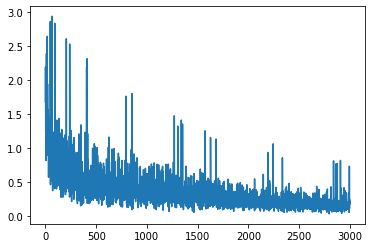

In [13]:
loss_items = []
for l in losses:
  loss_items.append(l.item())
plt.plot(loss_items)
print(min(loss_items))

In [14]:
# check model on other dataset
model.eval()

#sample = from_smiles('CC12CCC3C(CCC4=CC(=O)CCC34C)C2CCC1C(=O)CO')
#print(sample)

#loader = DataLoader([sample], batch_size=batch_size, shuffle=False)
preds = []
embs = []
test_losses = []
test_loader = DataLoader(data[int(data_size * 0.8):], batch_size=1, shuffle=False)
print(len(test_loader.dataset))
for batch in test_loader:
  batch.to(device)  
  pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
  preds.append(pred)
  embs.append(embedding)
  test_losses.append(torch.sqrt(loss_fn(pred, batch.y)))
#print(preds[0])  

Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='CC12CCC3C(CCC4=CC(=O)CCC34C)C2CCC1C(=O)CO')
226


226


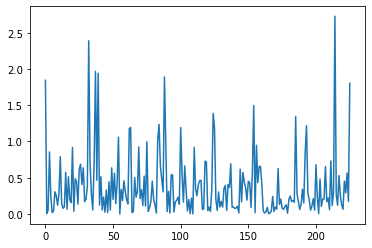

In [15]:
print(len(test_losses))
pred_loss_items = []
for l in test_losses:
  pred_loss_items.append(l.item())
plt.plot(pred_loss_items)